## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


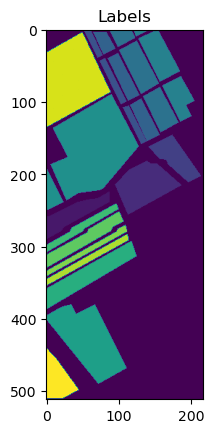

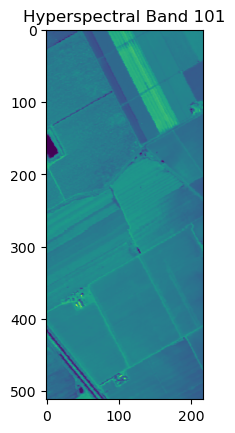

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices for clas


 -- Test set created with: 
	53969 samples
	shape (53969, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(80, 5, 5, 204)
(80, 5, 5, 204)
(53969, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1569, PSNR: 7.0860


	 Training Batch [200/677], Loss: 0.0862, PSNR: 9.6608


	 Training Batch [400/677], Loss: 0.0447, PSNR: 12.6701


	 Training Batch [600/677], Loss: 0.0244, PSNR: 15.2220


Epoch [1/50] Training Loss: 0.0658, PSNR: 11.7042
	[Val]   Batch [1/170] Loss: 0.0211, PSNR: 15.8469
	[Val]   Batch [10/170] Loss: 0.0207, PSNR: 16.0271
	[Val]   Batch [20/170] Loss: 0.0208, PSNR: 15.9221
	[Val]   Batch [30/170] Loss: 0.0216, PSNR: 15.7100
	[Val]   Batch [40/170] Loss: 0.0217, PSNR: 15.7819


	[Val]   Batch [50/170] Loss: 0.0205, PSNR: 15.9936
	[Val]   Batch [60/170] Loss: 0.0215, PSNR: 15.8649
	[Val]   Batch [70/170] Loss: 0.0210, PSNR: 15.9502
	[Val]   Batch [80/170] Loss: 0.0214, PSNR: 15.7743


	[Val]   Batch [90/170] Loss: 0.0207, PSNR: 16.0083
	[Val]   Batch [100/170] Loss: 0.0208, PSNR: 15.9323
	[Val]   Batch [110/170] Loss: 0.0208, PSNR: 15.9224
	[Val]   Batch [120/170] Loss: 0.0196, PSNR: 14.2340
	[Val]   Batch [130/170] Loss: 0.0207, PSNR: 16.0166


	[Val]   Batch [140/170] Loss: 0.0203, PSNR: 16.0743
	[Val]   Batch [150/170] Loss: 0.0217, PSNR: 15.8121
	[Val]   Batch [160/170] Loss: 0.0213, PSNR: 15.8531
	[Val]   Batch [170/170] Loss: 0.0220, PSNR: 15.1643
Epoch [1/50] Validation Loss: 0.0210, PSNR: 15.8415

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0208, PSNR: 15.8608


	 Training Batch [200/677], Loss: 0.0151, PSNR: 17.2199


	 Training Batch [400/677], Loss: 0.0114, PSNR: 18.5742


	 Training Batch [600/677], Loss: 0.0091, PSNR: 19.4168


Epoch [2/50] Training Loss: 0.0130, PSNR: 18.0734
	[Val]   Batch [1/170] Loss: 0.0087, PSNR: 19.6962
	[Val]   Batch [10/170] Loss: 0.0082, PSNR: 20.0506
	[Val]   Batch [20/170] Loss: 0.0083, PSNR: 19.9182
	[Val]   Batch [30/170] Loss: 0.0090, PSNR: 19.5162
	[Val]   Batch [40/170] Loss: 0.0092, PSNR: 19.4927


	[Val]   Batch [50/170] Loss: 0.0080, PSNR: 20.0571
	[Val]   Batch [60/170] Loss: 0.0090, PSNR: 19.6488
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7473
	[Val]   Batch [80/170] Loss: 0.0088, PSNR: 19.6102
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8983


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.8276
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8822
	[Val]   Batch [120/170] Loss: 0.0073, PSNR: 18.5280
	[Val]   Batch [130/170] Loss: 0.0084, PSNR: 19.9187
	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1919


	[Val]   Batch [150/170] Loss: 0.0092, PSNR: 19.5448
	[Val]   Batch [160/170] Loss: 0.0089, PSNR: 19.6426
	[Val]   Batch [170/170] Loss: 0.0092, PSNR: 18.9799
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7486

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0085, PSNR: 19.8691


	 Training Batch [200/677], Loss: 0.0073, PSNR: 20.5159


	 Training Batch [400/677], Loss: 0.0057, PSNR: 21.5312


	 Training Batch [600/677], Loss: 0.0051, PSNR: 21.9691


Epoch [3/50] Training Loss: 0.0066, PSNR: 20.9717
	[Val]   Batch [1/170] Loss: 0.0048, PSNR: 22.2834
	[Val]   Batch [10/170] Loss: 0.0045, PSNR: 22.6244
	[Val]   Batch [20/170] Loss: 0.0046, PSNR: 22.5006
	[Val]   Batch [30/170] Loss: 0.0050, PSNR: 22.0653
	[Val]   Batch [40/170] Loss: 0.0051, PSNR: 22.0668


	[Val]   Batch [50/170] Loss: 0.0045, PSNR: 22.5711
	[Val]   Batch [60/170] Loss: 0.0050, PSNR: 22.2155
	[Val]   Batch [70/170] Loss: 0.0048, PSNR: 22.3413
	[Val]   Batch [80/170] Loss: 0.0049, PSNR: 22.2096
	[Val]   Batch [90/170] Loss: 0.0047, PSNR: 22.4503


	[Val]   Batch [100/170] Loss: 0.0047, PSNR: 22.3411
	[Val]   Batch [110/170] Loss: 0.0046, PSNR: 22.4318
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 21.0114
	[Val]   Batch [130/170] Loss: 0.0047, PSNR: 22.4392
	[Val]   Batch [140/170] Loss: 0.0043, PSNR: 22.7850


	[Val]   Batch [150/170] Loss: 0.0051, PSNR: 22.1236
	[Val]   Batch [160/170] Loss: 0.0049, PSNR: 22.2204
	[Val]   Batch [170/170] Loss: 0.0050, PSNR: 21.6072
Epoch [3/50] Validation Loss: 0.0047, PSNR: 22.3168

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0045, PSNR: 22.1772


	 Training Batch [200/677], Loss: 0.0040, PSNR: 23.0942


	 Training Batch [400/677], Loss: 0.0038, PSNR: 23.3732


	 Training Batch [600/677], Loss: 0.0027, PSNR: 24.7646


Epoch [4/50] Training Loss: 0.0037, PSNR: 23.4975
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.8083
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0930
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.9431
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4961
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.6899
	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9282


	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.7145
	[Val]   Batch [70/170] Loss: 0.0027, PSNR: 24.9327
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.7586
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.9281
	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6904


	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9664
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.1999
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7722
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.2286
	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.6688


	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.7670
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.1167
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7863

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0029, PSNR: 24.5758


	 Training Batch [200/677], Loss: 0.0025, PSNR: 25.0055


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.3485


	 Training Batch [600/677], Loss: 0.0019, PSNR: 26.3435


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3358
	[Val]   Batch [1/170] Loss: 0.0018, PSNR: 26.4712
	[Val]   Batch [10/170] Loss: 0.0017, PSNR: 26.7667
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.5593
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 26.0523
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.4276


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.5406
	[Val]   Batch [60/170] Loss: 0.0019, PSNR: 26.3263
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.6526
	[Val]   Batch [80/170] Loss: 0.0018, PSNR: 26.4114
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5900


	[Val]   Batch [100/170] Loss: 0.0019, PSNR: 26.2308
	[Val]   Batch [110/170] Loss: 0.0017, PSNR: 26.7510
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.7547
	[Val]   Batch [130/170] Loss: 0.0019, PSNR: 26.2981
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.8986


	[Val]   Batch [150/170] Loss: 0.0019, PSNR: 26.2833
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.4198
	[Val]   Batch [170/170] Loss: 0.0019, PSNR: 25.7294
Epoch [5/50] Validation Loss: 0.0018, PSNR: 26.4148

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0022, PSNR: 25.7325


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.2770


	 Training Batch [400/677], Loss: 0.0016, PSNR: 27.1912


	 Training Batch [600/677], Loss: 0.0015, PSNR: 27.4640


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5918
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6686
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.9451
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6960
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.1537
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6811


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6386
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4865
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9134
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5925
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.8022


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3432
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0280
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.8286
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.4101
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0797


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4325
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6093
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8930
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5744

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 26.9717


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.3631


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.6229


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.4385


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5972
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.8125
	[Val]   Batch [10/170] Loss: 0.0010, PSNR: 29.0953
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.8046
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.2363
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.8592


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.6974
	[Val]   Batch [60/170] Loss: 0.0011, PSNR: 28.6076
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 29.0912
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.7596
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.9431


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.3961
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.2601
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.8372
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.4802
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.2365


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.5429
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.7514
	[Val]   Batch [170/170] Loss: 0.0011, PSNR: 28.1144
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.6996

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.2561


	 Training Batch [200/677], Loss: 0.0014, PSNR: 27.7126


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.6062


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.3606


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.4135
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6893
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 29.9823
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.6541
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 29.1024
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.7605


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.5502
	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.4645
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9793
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.6417
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.8596


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.2749
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.1722
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.6846
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.3437
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.1312


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3953
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.6035
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.9650
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.5615

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.2623


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.8452


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.4078


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.9651


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.1736
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.7041
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.9995
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.6487
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 30.0975
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.8028


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.4852
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.4761
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 31.0100
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.6984
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.9276


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 30.2879
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.2355
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.6473
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.3534


	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.1669
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.4077
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.5917
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.0826
Epoch [9/50] Validation Loss: 0.0007, PSNR: 30.5742

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 29.7691


	 Training Batch [200/677], Loss: 0.0008, PSNR: 29.9555


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.4599


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.8900


Epoch [10/50] Training Loss: 0.0008, PSNR: 29.8288
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.2949
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.6225
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.2331
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.7392
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.3859
	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.0445


	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.0966
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.5838
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.3310
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.5863
	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 30.9796


	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.8358
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.2991
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.0437
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 31.7626


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 31.0371
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.1619
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.8186
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.1861

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.6752


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.0165


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.9012


	 Training Batch [600/677], Loss: 0.0007, PSNR: 29.4982


Epoch [11/50] Training Loss: 0.0007, PSNR: 30.4413
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.1717
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.5206
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.1004
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.6634
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.2792


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.8417
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.0345
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.4630
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.2739
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.5232


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.9372
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.7582
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.1014
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 31.9881
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.6406


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.0097
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.0363
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.9011
Epoch [11/50] Validation Loss: 0.0005, PSNR: 32.0879

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.2909


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.1472


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.9313


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4388


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.9443
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.6258
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.0331
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.5622
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.1914
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.7593


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.2783
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.5470
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.8822
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.7901


	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.0562
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.5066
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.2080
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.5800
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.5845


	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.1115
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5564
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.4711
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.4683
Epoch [12/50] Validation Loss: 0.0004, PSNR: 32.5856

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.4847


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5455


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6861


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5768


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.3411
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.3018
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.6865
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.1758
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.8866
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.4355


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.9801
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.2480
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.5159
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.4596
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.7697


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.1529
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.8944
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.2631
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.2418
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7796


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.1962
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.0798
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.1991
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.2357

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0252


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.6610


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.8419


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8647


Epoch [14/50] Training Loss: 0.0005, PSNR: 31.7362
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.8529
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.2385
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.6719
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4380
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.9851


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3725
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8233
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0531
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.0674
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3692


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.7562
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4594
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7356
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.8678
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3274


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.8206
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6111
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.9292
Epoch [14/50] Validation Loss: 0.0003, PSNR: 33.8036

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4307


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.8585


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9242


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1121


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0602
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2791
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.6388
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.0533
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.8927
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.3950


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8430
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.2555
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.3892
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.4582
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.8117


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.1567
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8350
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.1351
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.2953
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.7259


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.2037
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.9513
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3735
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.1869

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.9360


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.5468


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.7839


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.5377


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3391
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6367
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0296
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.4396
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.2823
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7712


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1681
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.6597
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7632
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8618


	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.2351
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6009
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.2312
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5492
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.7288


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.1122
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.6349
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3137
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8409
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5778

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.6078


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7585


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.3944


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.7530


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6690
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9576
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.3264
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7001
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6370
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0608


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4284
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.0170
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0200
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.1931
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5708


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9641
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5249
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.8598
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.1048
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4079


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.0151
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6024
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.1688
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8912

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1345


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.9965


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0443


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.0959


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8917
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.3416
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.7518
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 35.0835
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 35.0492
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4688


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8381
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.4506
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4002
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.6172
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.0465


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.3852
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.9570
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.2393
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.5384
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.8466


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.4211
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9528
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.5872
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.2850

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0003, PSNR: 33.5702


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.2502


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.7281


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.4941


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.1377
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.5187
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.9873
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.3276
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.3200


	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.6298
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9132
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.7143
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.5723
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.9512


	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.2291
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.6617
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.1638
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4025
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.8376


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.0164
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.7901
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.1826
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.1566
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.5454
Early stopping triggered at epoch 19. No improvement for 3 epochs.


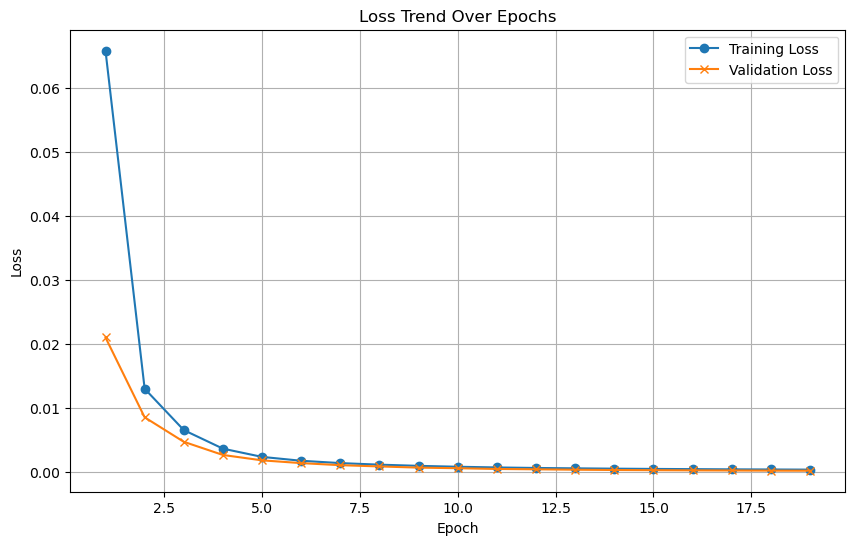

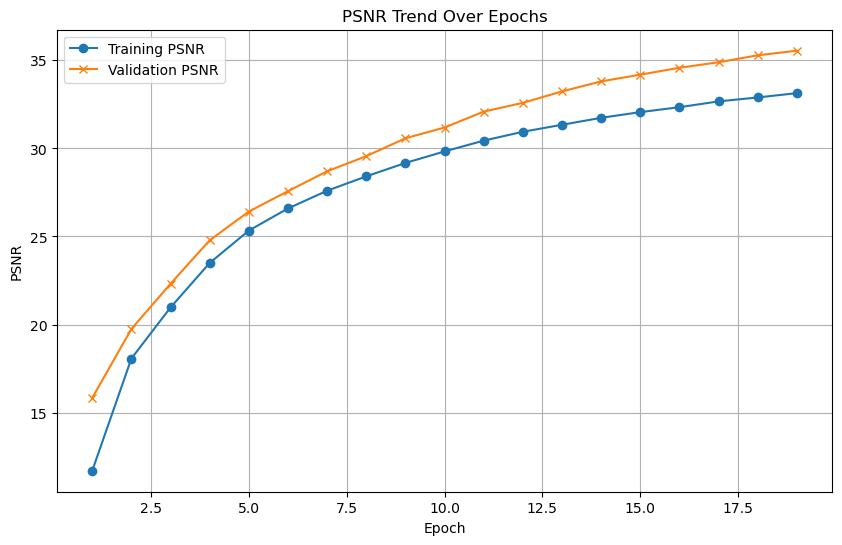

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7906
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7784. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7528
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7784. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7152
    Validation Batch [1/1], Loss: 2.7783
Validation Loss: 2.7783, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7783. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6988
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss improved from 2.7783 to 2.7782. Saving model...

LOG: Epoch [5/1000] - 

Epoch [21/1000] completed, Average Training Loss: 2.5094
    Validation Batch [1/1], Loss: 2.7741
Validation Loss: 2.7741, Validation Accuracy: 6.25%
Validation loss improved from 2.7749 to 2.7741. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4752
    Validation Batch [1/1], Loss: 2.7733
Validation Loss: 2.7733, Validation Accuracy: 6.25%
Validation loss improved from 2.7741 to 2.7733. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4697
    Validation Batch [1/1], Loss: 2.7722
Validation Loss: 2.7722, Validation Accuracy: 6.25%
Validation loss improved from 2.7733 to 2.7722. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4475
    Validation Batch [1/1], Loss: 2.7708
Validation Loss: 2.7708, Validation Accuracy: 6.25%
Validation loss improved from 2.7722 to 2.7708. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/10

Epoch [48/1000] completed, Average Training Loss: 2.2849
    Validation Batch [1/1], Loss: 2.5948
Validation Loss: 2.5948, Validation Accuracy: 27.50%
Validation loss improved from 2.6124 to 2.5948. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2816
    Validation Batch [1/1], Loss: 2.5754
Validation Loss: 2.5754, Validation Accuracy: 30.00%
Validation loss improved from 2.5948 to 2.5754. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2770
    Validation Batch [1/1], Loss: 2.5566
Validation Loss: 2.5566, Validation Accuracy: 30.00%
Validation loss improved from 2.5754 to 2.5566. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.2484
    Validation Batch [1/1], Loss: 2.5377
Validation Loss: 2.5377, Validation Accuracy: 32.50%
Validation loss improved from 2.5566 to 2.5377. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [5

Epoch [75/1000] completed, Average Training Loss: 2.0923
    Validation Batch [1/1], Loss: 2.1910
Validation Loss: 2.1910, Validation Accuracy: 62.50%
Validation loss improved from 2.2003 to 2.1910. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.0731
    Validation Batch [1/1], Loss: 2.1746
Validation Loss: 2.1746, Validation Accuracy: 61.25%
Validation loss improved from 2.1910 to 2.1746. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.1111
    Validation Batch [1/1], Loss: 2.1586
Validation Loss: 2.1586, Validation Accuracy: 57.50%
Validation loss improved from 2.1746 to 2.1586. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0995
    Validation Batch [1/1], Loss: 2.1514
Validation Loss: 2.1514, Validation Accuracy: 61.25%
Validation loss improved from 2.1586 to 2.1514. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [7

Epoch [106/1000] completed, Average Training Loss: 1.8503
    Validation Batch [1/1], Loss: 1.9034
Validation Loss: 1.9034, Validation Accuracy: 66.25%
Validation loss improved from 1.9094 to 1.9034. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.8668
    Validation Batch [1/1], Loss: 1.9002
Validation Loss: 1.9002, Validation Accuracy: 70.00%
Validation loss improved from 1.9034 to 1.9002. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.8535
    Validation Batch [1/1], Loss: 1.8989
Validation Loss: 1.8989, Validation Accuracy: 70.00%
Validation loss improved from 1.9002 to 1.8989. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.8363
    Validation Batch [1/1], Loss: 1.8947
Validation Loss: 1.8947, Validation Accuracy: 70.00%
Validation loss improved from 1.8989 to 1.8947. Saving model...

LOG: Epoch [110/1000] - Training


Epoch [137/1000] completed, Average Training Loss: 1.5698
    Validation Batch [1/1], Loss: 1.6494
Validation Loss: 1.6494, Validation Accuracy: 73.75%
Validation loss improved from 1.6515 to 1.6494. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.5648
    Validation Batch [1/1], Loss: 1.6516
Validation Loss: 1.6516, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.5871
    Validation Batch [1/1], Loss: 1.6501
Validation Loss: 1.6501, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5099
    Validation Batch [1/1], Loss: 1.6323
Validation Loss: 1.6323, Validation Accuracy: 76.25%
Validation loss improved from 1.6494 to 1.6323. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Av

Epoch [166/1000] completed, Average Training Loss: 1.3740
    Validation Batch [1/1], Loss: 1.4539
Validation Loss: 1.4539, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.3206
    Validation Batch [1/1], Loss: 1.4630
Validation Loss: 1.4630, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.3175
    Validation Batch [1/1], Loss: 1.4175
Validation Loss: 1.4175, Validation Accuracy: 82.50%
Validation loss improved from 1.4275 to 1.4175. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.2716
    Validation Batch [1/1], Loss: 1.3895
Validation Loss: 1.3895, Validation Accuracy: 83.75%
Validation loss improved from 1.4175 to 1.3895. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Av

Epoch [195/1000] completed, Average Training Loss: 1.0918
    Validation Batch [1/1], Loss: 1.2168
Validation Loss: 1.2168, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0892
    Validation Batch [1/1], Loss: 1.2017
Validation Loss: 1.2017, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.0869
    Validation Batch [1/1], Loss: 1.1805
Validation Loss: 1.1805, Validation Accuracy: 88.75%
Validation loss improved from 1.1837 to 1.1805. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.0199
    Validation Batch [1/1], Loss: 1.1733
Validation Loss: 1.1733, Validation Accuracy: 90.00%
Validation loss improved from 1.1805 to 1.1733. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Av

Epoch [226/1000] completed, Average Training Loss: 0.9056
    Validation Batch [1/1], Loss: 0.9910
Validation Loss: 0.9910, Validation Accuracy: 90.00%
Validation loss improved from 0.9967 to 0.9910. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.8121
    Validation Batch [1/1], Loss: 0.9937
Validation Loss: 0.9937, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.8590
    Validation Batch [1/1], Loss: 0.9841
Validation Loss: 0.9841, Validation Accuracy: 91.25%
Validation loss improved from 0.9910 to 0.9841. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.8552
    Validation Batch [1/1], Loss: 0.9652
Validation Loss: 0.9652, Validation Accuracy: 91.25%
Validation loss improved from 0.9841 to 0.9652. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000

Epoch [256/1000] completed, Average Training Loss: 0.7130
    Validation Batch [1/1], Loss: 0.8211
Validation Loss: 0.8211, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.6367
    Validation Batch [1/1], Loss: 0.8011
Validation Loss: 0.8011, Validation Accuracy: 91.25%
Validation loss improved from 0.8077 to 0.8011. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.6217
    Validation Batch [1/1], Loss: 0.8020
Validation Loss: 0.8020, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.6404
    Validation Batch [1/1], Loss: 0.8059
Validation Loss: 0.8059, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6577
Validation Loss: 0.6577, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.5044
    Validation Batch [1/1], Loss: 0.6669
Validation Loss: 0.6669, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.5385
    Validation Batch [1/1], Loss: 0.6465
Validation Loss: 0.6465, Validation Accuracy: 92.50%
Validation loss improved from 0.6495 to 0.6465. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.5287
    Validation Batch [1/1], Loss: 0.6439
Validation Loss: 0.6439, Validation Accuracy: 92.50%
Validation loss improved from 0.6465 to 0.6439. Saving model...

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4542
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.5595
Validation Loss: 0.5595, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4047
    Validation Batch [1/1], Loss: 0.5649
Validation Loss: 0.5649, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3574
    Validation Batch [1/1], Loss: 0.5552
Validation Loss: 0.5552, Validation Accuracy: 88.75%
Validation loss improved from 0.5563 to 0.5552. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.4083
    Validation Batch [1/1], Loss: 0.5471
Validation Loss: 0.5471, Validation Accuracy: 91.25%
Validation loss improved from 0.5552 to 0.5471. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3808
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.4706
Validation Loss: 0.4706, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.3193
    Validation Batch [1/1], Loss: 0.4598
Validation Loss: 0.4598, Validation Accuracy: 91.25%
Validation loss improved from 0.4667 to 0.4598. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.3042
    Validation Batch [1/1], Loss: 0.4612
Validation Loss: 0.4612, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2909
    Validation Batch [1/1], Loss: 0.4678
Validation Loss: 0.4678, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.3063
    Validation Batch [1/1], Loss: 0.4763
Vali

Epoch [371/1000] completed, Average Training Loss: 0.2908
    Validation Batch [1/1], Loss: 0.4622
Validation Loss: 0.4622, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1967
    Validation Batch [1/1], Loss: 0.4432
Validation Loss: 0.4432, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2453
    Validation Batch [1/1], Loss: 0.4203
Validation Loss: 0.4203, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.2325
    Validation Batch [1/1], Loss: 0.4422
Validation Loss: 0.4422, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2669
  

Epoch [401/1000] completed, Average Training Loss: 0.1814
    Validation Batch [1/1], Loss: 0.3656
Validation Loss: 0.3656, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1753
    Validation Batch [1/1], Loss: 0.3701
Validation Loss: 0.3701, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1791
    Validation Batch [1/1], Loss: 0.3748
Validation Loss: 0.3748, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1858
    Validation Batch [1/1], Loss: 0.3734
Validation Loss: 0.3734, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.2152
  

Epoch [430/1000] completed, Average Training Loss: 0.1694
    Validation Batch [1/1], Loss: 0.3555
Validation Loss: 0.3555, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1519
    Validation Batch [1/1], Loss: 0.3419
Validation Loss: 0.3419, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1755
    Validation Batch [1/1], Loss: 0.3294
Validation Loss: 0.3294, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1486
    Validation Batch [1/1], Loss: 0.3240
Validation Loss: 0.3240, Validation Accuracy: 93.75%
Validation loss improved from 0.3268 to 0.3240. Saving model...

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Traini

    Validation Batch [1/1], Loss: 0.3126
Validation Loss: 0.3126, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.1317
    Validation Batch [1/1], Loss: 0.3114
Validation Loss: 0.3114, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1771
    Validation Batch [1/1], Loss: 0.3139
Validation Loss: 0.3139, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1413
    Validation Batch [1/1], Loss: 0.3149
Validation Loss: 0.3149, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1060
    Validation Batch [1/1], Loss: 0.3139
Validation Loss: 0.

Epoch [485/1000] completed, Average Training Loss: 0.1136
    Validation Batch [1/1], Loss: 0.2868
Validation Loss: 0.2868, Validation Accuracy: 93.75%
Validation loss improved from 0.2963 to 0.2868. Saving model...

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1082
    Validation Batch [1/1], Loss: 0.2930
Validation Loss: 0.2930, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1278
    Validation Batch [1/1], Loss: 0.2901
Validation Loss: 0.2901, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.1255
    Validation Batch [1/1], Loss: 0.2893
Validation Loss: 0.2893, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2902
Validation Loss: 0.2902, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.1313
    Validation Batch [1/1], Loss: 0.2842
Validation Loss: 0.2842, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0873
    Validation Batch [1/1], Loss: 0.2840
Validation Loss: 0.2840, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.1079
    Validation Batch [1/1], Loss: 0.2944
Validation Loss: 0.2944, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0954
    Validation Batch [1/1], Loss: 0.2994
Validation Loss

Epoch [541/1000] completed, Average Training Loss: 0.0918
    Validation Batch [1/1], Loss: 0.2784
Validation Loss: 0.2784, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0845
    Validation Batch [1/1], Loss: 0.2706
Validation Loss: 0.2706, Validation Accuracy: 90.00%
Validation loss improved from 0.2729 to 0.2706. Saving model...

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.1043
    Validation Batch [1/1], Loss: 0.2650
Validation Loss: 0.2650, Validation Accuracy: 91.25%
Validation loss improved from 0.2706 to 0.2650. Saving model...

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0950
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 91.25%
Validation loss improved from 0.2650 to 0.2630. Saving model...

LOG: Epoch [545/1000] - Training
Epoch [545/100

Epoch [570/1000] completed, Average Training Loss: 0.0938
    Validation Batch [1/1], Loss: 0.2646
Validation Loss: 0.2646, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0840
    Validation Batch [1/1], Loss: 0.2643
Validation Loss: 0.2643, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0878
    Validation Batch [1/1], Loss: 0.2569
Validation Loss: 0.2569, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0800
    Validation Batch [1/1], Loss: 0.2638
Validation Loss: 0.2638, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0825
  

    Validation Batch [1/1], Loss: 0.2445
Validation Loss: 0.2445, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.2469
Validation Loss: 0.2469, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.2466
Validation Loss: 0.2466, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.2557
Validation Loss: 0.2557, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0995
    Validation Batch [1/1], Loss: 0.2757
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.2514
Validation Loss: 0.2514, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.2588
Validation Loss: 0.2588, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0482
    Validation Batch [1/1], Loss: 0.2692
Validation Loss: 0.2692, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.2762
Validation Loss: 0.2762, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.2734
Validation Loss

    Validation Batch [1/1], Loss: 0.2672
Validation Loss: 0.2672, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.3156
Validation Loss: 0.3156, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0595
    Validation Batch [1/1], Loss: 0.3232
Validation Loss: 0.3232, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.2760
Validation Loss: 0.2760, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.2497
Validation Loss:

Epoch [686/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.2490
Validation Loss: 0.2490, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.2615
Validation Loss: 0.2615, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.2676
Validation Loss: 0.2676, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.2584
Validation Loss: 0.2584, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.047

Epoch [716/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.2337
Validation Loss: 0.2337, Validation Accuracy: 92.50%
Validation loss improved from 0.2340 to 0.2337. Saving model...

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0498
    Validation Batch [1/1], Loss: 0.2355
Validation Loss: 0.2355, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.2391
Validation Loss: 0.2391, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.2421
Validation Loss: 0.2421, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training 

Validation Loss: 0.2385, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.2421
Validation Loss: 0.2421, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0456
    Validation Batch [1/1], Loss: 0.2458
Validation Loss: 0.2458, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.2567
Validation Loss: 0.2567, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.2636
Validation Loss: 0.2636, Validation Accuracy: 92.50%
Val

    Validation Batch [1/1], Loss: 0.2665
Validation Loss: 0.2665, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.2709
Validation Loss: 0.2709, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.2780
Validation Loss: 0.2780, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.2681
Validation Loss: 0.2681, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.2485
Validation Loss

Epoch [806/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.2470
Validation Loss: 0.2470, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.2225
Validation Loss: 0.2225, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [808/1000] - Training
Epoch [808/1000] completed, Average Training Loss: 0.0373
    Validation Batch [1/1], Loss: 0.3006
Validation Loss: 0.3006, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [809/1000] - Training
Epoch [809/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.2502
Validation Loss: 0.2502, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [810/1000] - Training
Epoch [810/1000] completed, Average Training Loss: 0.036

    Validation Batch [1/1], Loss: 0.2617
Validation Loss: 0.2617, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [838/1000] - Training
Epoch [838/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.2337
Validation Loss: 0.2337, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [839/1000] - Training
Epoch [839/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.2255
Validation Loss: 0.2255, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [840/1000] - Training
Epoch [840/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.2415
Validation Loss: 0.2415, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [841/1000] - Training
Epoch [841/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.2462
Validation Loss: 0.

Epoch [867/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.2189
Validation Loss: 0.2189, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [868/1000] - Training
Epoch [868/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.2227
Validation Loss: 0.2227, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [869/1000] - Training
Epoch [869/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.2294
Validation Loss: 0.2294, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [870/1000] - Training
Epoch [870/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.2313
Validation Loss: 0.2313, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [871/1000] - Training
Epoch [871/1000] completed, Average Training Loss: 0.027

Epoch [898/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.2333
Validation Loss: 0.2333, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [899/1000] - Training
Epoch [899/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.2357
Validation Loss: 0.2357, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [900/1000] - Training
Epoch [900/1000] completed, Average Training Loss: 0.0377
    Validation Batch [1/1], Loss: 0.2503
Validation Loss: 0.2503, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [901/1000] - Training
Epoch [901/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.2730
Validation Loss: 0.2730, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [902/1000] - Training
Epoch [902/1000] completed, Average Training Loss: 0.022

    Validation Batch [1/1], Loss: 0.2553
Validation Loss: 0.2553, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [929/1000] - Training
Epoch [929/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.2735
Validation Loss: 0.2735, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [930/1000] - Training
Epoch [930/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.2731
Validation Loss: 0.2731, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [931/1000] - Training
Epoch [931/1000] completed, Average Training Loss: 0.0291
    Validation Batch [1/1], Loss: 0.2583
Validation Loss: 0.2583, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [932/1000] - Training
Epoch [932/1000] completed, Average Training Loss: 0.0326
    Validation Batch [1/1], Loss: 0.2423
Validation Loss

Epoch [957/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.2445
Validation Loss: 0.2445, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [958/1000] - Training
Epoch [958/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.2573
Validation Loss: 0.2573, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [959/1000] - Training
Epoch [959/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.2578
Validation Loss: 0.2578, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [960/1000] - Training
Epoch [960/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.2424
Validation Loss: 0.2424, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [961/1000] - Training
Epoch [961/1000] completed, Average Training Loss: 0.016

    Validation Batch [1/1], Loss: 0.2404
Validation Loss: 0.2404, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [989/1000] - Training
Epoch [989/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.2602
Validation Loss: 0.2602, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [990/1000] - Training
Epoch [990/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.2749
Validation Loss: 0.2749, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [991/1000] - Training
Epoch [991/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.2750
Validation Loss: 0.2750, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [992/1000] - Training
Epoch [992/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.2641
Validation Loss

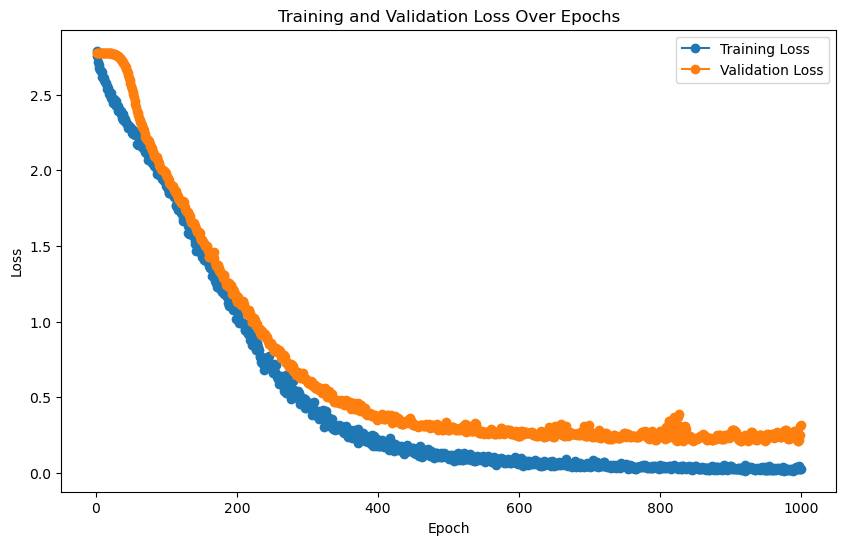

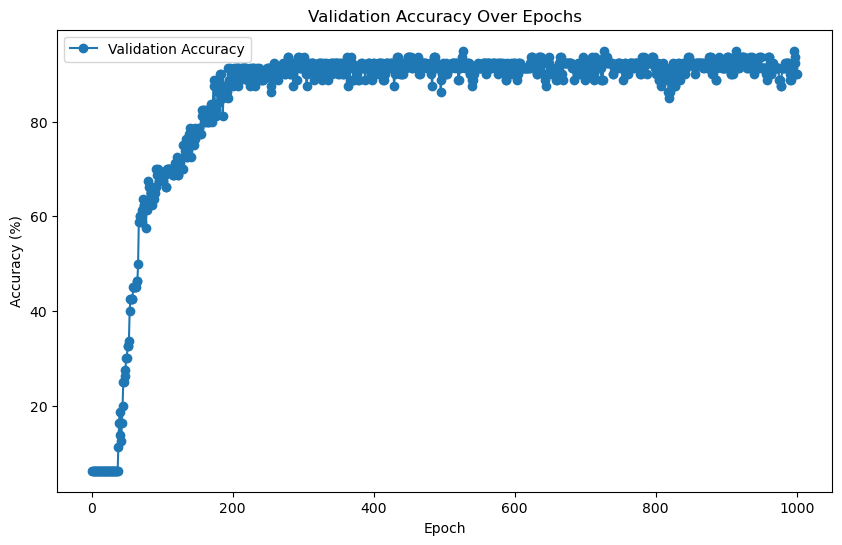


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.5218



Final Test Loss: 0.6088, Test Accuracy: 84.75%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53969, 64), Test labels shape: (53969,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.57      0.80      0.67         5
           8       0.71      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53969, 64)
Test labels shape: (53969,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0403  |  Val Loss: 2.8842
Validation loss improved from inf to 2.8842.
[Epoch 2/1000] Train Loss: 2.8571  |  Val Loss: 2.7790
Validation loss improved from 2.8842 to 2.7790.
[Epoch 3/1000] Train Loss: 2.7443  |  Val Loss: 2.6984
Validation loss improved from 2.7790 to 2.6984.
[Epoch 4/1000] Train Loss: 2.6549  |  Val Loss: 2.6324
Validation loss improved from 2.6984 to 2.6324.
[Epoch 5/1000] Train Loss: 2.5940  |  Val Loss: 2.5851
Validation loss improved from 2.6324 to 2.5851.
[Epoch 6/1000] Train Loss: 2.5377  |  Val Loss: 2.5498
Validation loss improved from 2.5851 to 2.5498.
[Epoch 7/1000] Train Loss: 2.4981  |  Val Loss: 2.5124
Validation loss improved from 2.5498 to 2.5124.
[Epoch 8/1000] Train Loss: 2.4518  |  Val Loss: 2.4795
Validation loss improved from 2.5124 to 2.4795.
[Epoch 9/1000] Train Loss: 2.4136  |  Val Loss: 2.4519
Validation loss improved from 2.4795 to 2.4519.
[Epoch 10/1000] Train Loss: 2.3800  |  Val Loss: 2.4207
Validation loss impr

[Epoch 22/1000] Train Loss: 1.9111  |  Val Loss: 1.9861
Validation loss improved from 2.0243 to 1.9861.
[Epoch 23/1000] Train Loss: 1.8679  |  Val Loss: 1.9523
Validation loss improved from 1.9861 to 1.9523.
[Epoch 24/1000] Train Loss: 1.8350  |  Val Loss: 1.9195
Validation loss improved from 1.9523 to 1.9195.
[Epoch 25/1000] Train Loss: 1.7970  |  Val Loss: 1.8864
Validation loss improved from 1.9195 to 1.8864.
[Epoch 26/1000] Train Loss: 1.7601  |  Val Loss: 1.8543
Validation loss improved from 1.8864 to 1.8543.
[Epoch 27/1000] Train Loss: 1.7235  |  Val Loss: 1.8206
Validation loss improved from 1.8543 to 1.8206.
[Epoch 28/1000] Train Loss: 1.6855  |  Val Loss: 1.7859
Validation loss improved from 1.8206 to 1.7859.
[Epoch 29/1000] Train Loss: 1.6450  |  Val Loss: 1.7529
Validation loss improved from 1.7859 to 1.7529.
[Epoch 30/1000] Train Loss: 1.6077  |  Val Loss: 1.7225
Validation loss improved from 1.7529 to 1.7225.
[Epoch 31/1000] Train Loss: 1.5772  |  Val Loss: 1.6896
Validati

[Epoch 43/1000] Train Loss: 1.1675  |  Val Loss: 1.3240
Validation loss improved from 1.3546 to 1.3240.
[Epoch 44/1000] Train Loss: 1.1369  |  Val Loss: 1.2964
Validation loss improved from 1.3240 to 1.2964.
[Epoch 45/1000] Train Loss: 1.1101  |  Val Loss: 1.2648
Validation loss improved from 1.2964 to 1.2648.
[Epoch 46/1000] Train Loss: 1.0774  |  Val Loss: 1.2418
Validation loss improved from 1.2648 to 1.2418.
[Epoch 47/1000] Train Loss: 1.0514  |  Val Loss: 1.2217
Validation loss improved from 1.2418 to 1.2217.
[Epoch 48/1000] Train Loss: 1.0274  |  Val Loss: 1.1963
Validation loss improved from 1.2217 to 1.1963.
[Epoch 49/1000] Train Loss: 0.9970  |  Val Loss: 1.1729
Validation loss improved from 1.1963 to 1.1729.
[Epoch 50/1000] Train Loss: 0.9768  |  Val Loss: 1.1564
Validation loss improved from 1.1729 to 1.1564.
[Epoch 51/1000] Train Loss: 0.9573  |  Val Loss: 1.1161
Validation loss improved from 1.1564 to 1.1161.
[Epoch 52/1000] Train Loss: 0.9265  |  Val Loss: 1.0891
Validati

[Epoch 67/1000] Train Loss: 0.6456  |  Val Loss: 0.8411
Validation loss improved from 0.8587 to 0.8411.
[Epoch 68/1000] Train Loss: 0.6315  |  Val Loss: 0.8342
Validation loss improved from 0.8411 to 0.8342.
[Epoch 69/1000] Train Loss: 0.6201  |  Val Loss: 0.8226
Validation loss improved from 0.8342 to 0.8226.
[Epoch 70/1000] Train Loss: 0.6048  |  Val Loss: 0.8042
Validation loss improved from 0.8226 to 0.8042.
[Epoch 71/1000] Train Loss: 0.5872  |  Val Loss: 0.8046
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 0.5875  |  Val Loss: 0.7998
Validation loss improved from 0.8042 to 0.7998.
[Epoch 73/1000] Train Loss: 0.5808  |  Val Loss: 0.7892
Validation loss improved from 0.7998 to 0.7892.
[Epoch 74/1000] Train Loss: 0.5663  |  Val Loss: 0.7814
Validation loss improved from 0.7892 to 0.7814.
[Epoch 75/1000] Train Loss: 0.5511  |  Val Loss: 0.7694
Validation loss improved from 0.7814 to 0.7694.
[Epoch 76/1000] Train Loss: 0.5341  |  Val Loss: 0.7499
Va

[Epoch 84/1000] Train Loss: 0.4755  |  Val Loss: 0.6961
Validation loss improved from 0.7106 to 0.6961.
[Epoch 85/1000] Train Loss: 0.4598  |  Val Loss: 0.7019
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.4660  |  Val Loss: 0.7037
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 0.4632  |  Val Loss: 0.6802
Validation loss improved from 0.6961 to 0.6802.
[Epoch 88/1000] Train Loss: 0.4317  |  Val Loss: 0.6736
Validation loss improved from 0.6802 to 0.6736.
[Epoch 89/1000] Train Loss: 0.4241  |  Val Loss: 0.7001
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 0.4378  |  Val Loss: 0.6957
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 0.4330  |  Val Loss: 0.6663
Validation loss improved from 0.6736 to 0.6663.
[Epoch 92/1000] Train Loss: 0.4120  |  Val Loss: 0.6428
Validation loss improved from 0.6663 to 0.6428.
[Epoch 93/1000] Train Loss: 0.4024  |  V

[Epoch 105/1000] Train Loss: 0.3371  |  Val Loss: 0.6093
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 0.3348  |  Val Loss: 0.6252
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 0.3393  |  Val Loss: 0.6316
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 0.3392  |  Val Loss: 0.6297
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 109/1000] Train Loss: 0.3488  |  Val Loss: 0.6108
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 110/1000] Train Loss: 0.3333  |  Val Loss: 0.5850
Validation loss improved from 0.6044 to 0.5850.
[Epoch 111/1000] Train Loss: 0.3152  |  Val Loss: 0.5828
Validation loss improved from 0.5850 to 0.5828.
[Epoch 112/1000] Train Loss: 0.3098  |  Val Loss: 0.5958
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 0.3195  |  Val Loss: 0.6109
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/10

[Epoch 120/1000] Train Loss: 0.2864  |  Val Loss: 0.5701
Validation loss improved from 0.5713 to 0.5701.
[Epoch 121/1000] Train Loss: 0.2897  |  Val Loss: 0.5587
Validation loss improved from 0.5701 to 0.5587.
[Epoch 122/1000] Train Loss: 0.2800  |  Val Loss: 0.5575
Validation loss improved from 0.5587 to 0.5575.
[Epoch 123/1000] Train Loss: 0.2752  |  Val Loss: 0.5667
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.2729  |  Val Loss: 0.5727
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 125/1000] Train Loss: 0.2717  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 126/1000] Train Loss: 0.2615  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 127/1000] Train Loss: 0.2588  |  Val Loss: 0.5914
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 128/1000] Train Loss: 0.2630  |  Val Loss: 0.5846
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 129/1000] Tr

[Epoch 149/1000] Train Loss: 0.2046  |  Val Loss: 0.5481
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 150/1000] Train Loss: 0.2003  |  Val Loss: 0.5562
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 151/1000] Train Loss: 0.2025  |  Val Loss: 0.5554
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 152/1000] Train Loss: 0.2052  |  Val Loss: 0.5396
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 153/1000] Train Loss: 0.1969  |  Val Loss: 0.5232
Validation loss improved from 0.5382 to 0.5232.
[Epoch 154/1000] Train Loss: 0.1928  |  Val Loss: 0.5212
Validation loss improved from 0.5232 to 0.5212.
[Epoch 155/1000] Train Loss: 0.1932  |  Val Loss: 0.5231
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 0.1916  |  Val Loss: 0.5216
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 0.1854  |  Val Loss: 0.5221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/10

[Epoch 165/1000] Train Loss: 0.1847  |  Val Loss: 0.5486
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 166/1000] Train Loss: 0.1866  |  Val Loss: 0.5533
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 167/1000] Train Loss: 0.1856  |  Val Loss: 0.5485
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 168/1000] Train Loss: 0.1732  |  Val Loss: 0.5314
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 169/1000] Train Loss: 0.1701  |  Val Loss: 0.5291
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 170/1000] Train Loss: 0.1737  |  Val Loss: 0.5270
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 171/1000] Train Loss: 0.1743  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 172/1000] Train Loss: 0.1669  |  Val Loss: 0.5387
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 173/1000] Train Loss: 0.1685  |  Val Loss: 0.5621
!! Validation loss did NOT improve !! Patience:

[Epoch 191/1000] Train Loss: 0.1365  |  Val Loss: 0.5673
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 192/1000] Train Loss: 0.1566  |  Val Loss: 0.5995
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 193/1000] Train Loss: 0.1726  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 194/1000] Train Loss: 0.1565  |  Val Loss: 0.5361
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 195/1000] Train Loss: 0.1437  |  Val Loss: 0.5295
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 196/1000] Train Loss: 0.1448  |  Val Loss: 0.5352
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 197/1000] Train Loss: 0.1456  |  Val Loss: 0.5315
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 198/1000] Train Loss: 0.1416  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 199/1000] Train Loss: 0.1372  |  Val Loss: 0.5529
!! Validation loss did NOT improve !! Patience:

[Epoch 209/1000] Train Loss: 0.1235  |  Val Loss: 0.5402
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 0.1290  |  Val Loss: 0.5653
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 211/1000] Train Loss: 0.1406  |  Val Loss: 0.5424
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 212/1000] Train Loss: 0.1269  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 213/1000] Train Loss: 0.1283  |  Val Loss: 0.5388
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 214/1000] Train Loss: 0.1315  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 215/1000] Train Loss: 0.1231  |  Val Loss: 0.5170
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 216/1000] Train Loss: 0.1201  |  Val Loss: 0.5220
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 217/1000] Train Loss: 0.1230  |  Val Loss: 0.5304
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 232/1000] Train Loss: 0.1059  |  Val Loss: 0.5353
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 233/1000] Train Loss: 0.1135  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 234/1000] Train Loss: 0.1151  |  Val Loss: 0.5500
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 235/1000] Train Loss: 0.1059  |  Val Loss: 0.5445
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 236/1000] Train Loss: 0.1080  |  Val Loss: 0.5338
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 237/1000] Train Loss: 0.1039  |  Val Loss: 0.5307
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 238/1000] Train Loss: 0.1060  |  Val Loss: 0.5382
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 239/1000] Train Loss: 0.1065  |  Val Loss: 0.5365
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 240/1000] Train Loss: 0.1027  |  Val Loss: 0.5295
!! Validation loss did NOT improve !! Patience:

[Epoch 251/1000] Train Loss: 0.1077  |  Val Loss: 0.5167
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 252/1000] Train Loss: 0.1014  |  Val Loss: 0.5305
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 253/1000] Train Loss: 0.0954  |  Val Loss: 0.5514
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 254/1000] Train Loss: 0.0965  |  Val Loss: 0.5618
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 255/1000] Train Loss: 0.0941  |  Val Loss: 0.5631
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 256/1000] Train Loss: 0.0960  |  Val Loss: 0.5607
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 257/1000] Train Loss: 0.0985  |  Val Loss: 0.5566
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 258/1000] Train Loss: 0.1005  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 259/1000] Train Loss: 0.0963  |  Val Loss: 0.5380
!! Validation loss did NOT improve !! Patience:

[Epoch 275/1000] Train Loss: 0.0849  |  Val Loss: 0.5503
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 0.0873  |  Val Loss: 0.5600
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 0.0856  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/1000] Train Loss: 0.0823  |  Val Loss: 0.5443
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 0.0814  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 0.0804  |  Val Loss: 0.5327
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 0.0789  |  Val Loss: 0.5428
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 0.0831  |  Val Loss: 0.5501
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 283/1000] Train Loss: 0.0855  |  Val Loss: 0.5442
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 295/1000] Train Loss: 0.0816  |  Val Loss: 0.5735
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 296/1000] Train Loss: 0.0836  |  Val Loss: 0.5503
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 297/1000] Train Loss: 0.0778  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 298/1000] Train Loss: 0.0772  |  Val Loss: 0.5100
Validation loss improved from 0.5105 to 0.5100.
[Epoch 299/1000] Train Loss: 0.0803  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 0.0834  |  Val Loss: 0.5287
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 301/1000] Train Loss: 0.0835  |  Val Loss: 0.5461
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 302/1000] Train Loss: 0.0720  |  Val Loss: 0.6019
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 303/1000] Train Loss: 0.0969  |  Val Loss: 0.6273
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 309/1000] Train Loss: 0.0769  |  Val Loss: 0.4985
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 310/1000] Train Loss: 0.0690  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 311/1000] Train Loss: 0.0697  |  Val Loss: 0.5452
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 312/1000] Train Loss: 0.0807  |  Val Loss: 0.5253
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 313/1000] Train Loss: 0.0775  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 314/1000] Train Loss: 0.0664  |  Val Loss: 0.5382
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 315/1000] Train Loss: 0.0732  |  Val Loss: 0.5429
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 316/1000] Train Loss: 0.0755  |  Val Loss: 0.5223
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 317/1000] Train Loss: 0.0704  |  Val Loss: 0.5116
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 332/1000] Train Loss: 0.0612  |  Val Loss: 0.5614
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 333/1000] Train Loss: 0.0647  |  Val Loss: 0.5743
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 334/1000] Train Loss: 0.0684  |  Val Loss: 0.5732
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 335/1000] Train Loss: 0.0648  |  Val Loss: 0.5670
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 336/1000] Train Loss: 0.0630  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 337/1000] Train Loss: 0.0640  |  Val Loss: 0.5375
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 338/1000] Train Loss: 0.0627  |  Val Loss: 0.5185
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 339/1000] Train Loss: 0.0584  |  Val Loss: 0.5061
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 340/1000] Train Loss: 0.0570  |  Val Loss: 0.4968
!! Validation loss did NOT improve !! Patience:

[Epoch 347/1000] Train Loss: 0.0580  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 0.0565  |  Val Loss: 0.5043
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Train Loss: 0.0543  |  Val Loss: 0.5185
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 350/1000] Train Loss: 0.0537  |  Val Loss: 0.5393
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 351/1000] Train Loss: 0.0569  |  Val Loss: 0.5426
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 352/1000] Train Loss: 0.0550  |  Val Loss: 0.5302
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 353/1000] Train Loss: 0.0655  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 354/1000] Train Loss: 0.0537  |  Val Loss: 0.5308
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 355/1000] Train Loss: 0.0564  |  Val Loss: 0.5985
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 371/1000] Train Loss: 0.0512  |  Val Loss: 0.5013
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 372/1000] Train Loss: 0.0486  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 373/1000] Train Loss: 0.0495  |  Val Loss: 0.5313
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 374/1000] Train Loss: 0.0524  |  Val Loss: 0.5405
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 375/1000] Train Loss: 0.0520  |  Val Loss: 0.5367
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 376/1000] Train Loss: 0.0464  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 377/1000] Train Loss: 0.0494  |  Val Loss: 0.5232
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 378/1000] Train Loss: 0.0637  |  Val Loss: 0.4998
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 379/1000] Train Loss: 0.0594  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience:

[Epoch 385/1000] Train Loss: 0.0498  |  Val Loss: 0.5423
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 386/1000] Train Loss: 0.0489  |  Val Loss: 0.5448
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 387/1000] Train Loss: 0.0491  |  Val Loss: 0.5352
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 388/1000] Train Loss: 0.0500  |  Val Loss: 0.5071
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 389/1000] Train Loss: 0.0463  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 390/1000] Train Loss: 0.0446  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 391/1000] Train Loss: 0.0464  |  Val Loss: 0.5053
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 392/1000] Train Loss: 0.0474  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 393/1000] Train Loss: 0.0472  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience:

[Epoch 412/1000] Train Loss: 0.0537  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 413/1000] Train Loss: 0.0414  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 414/1000] Train Loss: 0.0442  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 415/1000] Train Loss: 0.0476  |  Val Loss: 0.4974
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 416/1000] Train Loss: 0.0434  |  Val Loss: 0.5108
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 417/1000] Train Loss: 0.0434  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 418/1000] Train Loss: 0.0412  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 419/1000] Train Loss: 0.0398  |  Val Loss: 0.5035
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 420/1000] Train Loss: 0.0404  |  Val Loss: 0.4999
!! Validation loss did NOT improve !! Patience:

[Epoch 428/1000] Train Loss: 0.0563  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 429/1000] Train Loss: 0.0413  |  Val Loss: 0.5056
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 430/1000] Train Loss: 0.0322  |  Val Loss: 0.5599
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 431/1000] Train Loss: 0.0550  |  Val Loss: 0.5649
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 432/1000] Train Loss: 0.0544  |  Val Loss: 0.5261
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 433/1000] Train Loss: 0.0390  |  Val Loss: 0.5203
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 434/1000] Train Loss: 0.0391  |  Val Loss: 0.5183
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 435/1000] Train Loss: 0.0398  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 436/1000] Train Loss: 0.0414  |  Val Loss: 0.5087
!! Validation loss did NOT improve !! Patience:

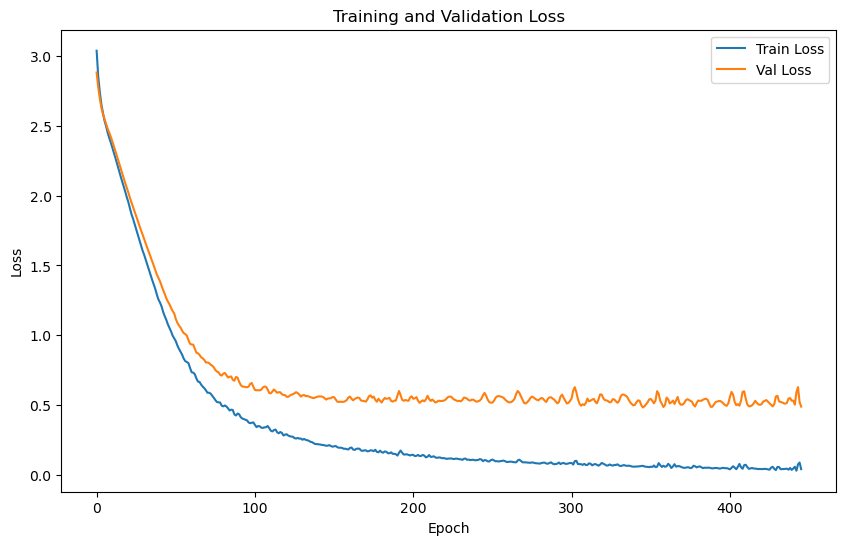

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9692 | Test Accuracy: 80.18%


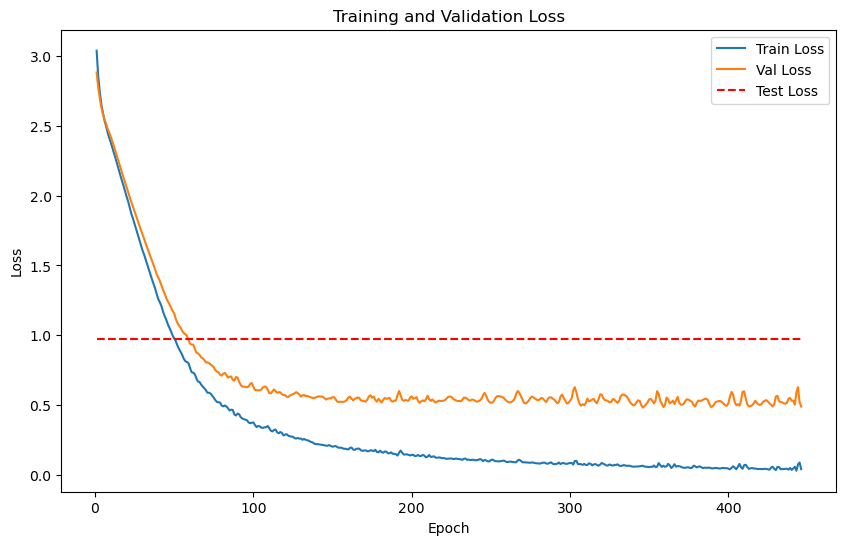

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.7617


Epoch [1/2000], Avg Train Loss: 7.7617
Epoch [1/2000], Avg Val Loss: 3.0120
Validation loss improved from inf to 3.0120. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.5208
Epoch [2/2000], Avg Train Loss: 7.5208
Epoch [2/2000], Avg Val Loss: 3.0013
Validation loss improved from 3.0120 to 3.0013. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.4623
Epoch [3/2000], Avg Train Loss: 7.4623
Epoch [3/2000], Avg Val Loss: 2.9911
Validation loss improved from 3.0013 to 2.9911. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4108
Epoch [4/2000], Avg Train Loss: 7.4108
Epoch [4/2000], Avg Val Loss: 2.9811
Validation loss improved from 2.9911 to 2.9811. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9348
Epoch [5/2000], Avg Train Loss: 7.9348
Epoch [5/2000], Avg Val Loss: 2.9714
Validation loss improved from 2.9811 to 2.9714. Saving model...

LOG: Epoch [6/2000] - Training

Epoch [23/2000], Avg Val Loss: 2.8524
Validation loss improved from 2.8565 to 2.8524. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.3896
Epoch [24/2000], Avg Train Loss: 6.3896
Epoch [24/2000], Avg Val Loss: 2.8485
Validation loss improved from 2.8524 to 2.8485. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.5831
Epoch [25/2000], Avg Train Loss: 6.5831
Epoch [25/2000], Avg Val Loss: 2.8448
Validation loss improved from 2.8485 to 2.8448. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.5037
Epoch [26/2000], Avg Train Loss: 6.5037
Epoch [26/2000], Avg Val Loss: 2.8413
Validation loss improved from 2.8448 to 2.8413. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.2705
Epoch [27/2000], Avg Train Loss: 6.2705
Epoch [27/2000], Avg Val Loss: 2.8380
Validation loss improved from 2.8413 to 2.8380. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Trai

Epoch [42/2000], Avg Val Loss: 2.8097
Validation loss improved from 2.8106 to 2.8097. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.9597
Epoch [43/2000], Avg Train Loss: 5.9597
Epoch [43/2000], Avg Val Loss: 2.8089
Validation loss improved from 2.8097 to 2.8089. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.5245
Epoch [44/2000], Avg Train Loss: 5.5245
Epoch [44/2000], Avg Val Loss: 2.8083
Validation loss improved from 2.8089 to 2.8083. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.6415
Epoch [45/2000], Avg Train Loss: 5.6415
Epoch [45/2000], Avg Val Loss: 2.8078
Validation loss improved from 2.8083 to 2.8078. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.6741
Epoch [46/2000], Avg Train Loss: 5.6741
Epoch [46/2000], Avg Val Loss: 2.8074
Validation loss improved from 2.8078 to 2.8074. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9292
Epoch [69/2000], Avg Train Loss: 4.9292
Epoch [69/2000], Avg Val Loss: 2.8198
Validation loss did not improve. Patience: 20/100

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.5723
Epoch [70/2000], Avg Train Loss: 4.5723
Epoch [70/2000], Avg Val Loss: 2.8209
Validation loss did not improve. Patience: 21/100

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.9270
Epoch [71/2000], Avg Train Loss: 4.9270
Epoch [71/2000], Avg Val Loss: 2.8220
Validation loss did not improve. Patience: 22/100

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.7823
Epoch [72/2000], Avg Train Loss: 4.7823
Epoch [72/2000], Avg Val Loss: 2.8232
Validation loss did not improve. Patience: 23/100

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.6254
Epoch [73/2000], Avg Train Loss: 4.6254
Epoch [73/2000], Avg Val Loss: 2.8244
Validation loss did not improve. Patience: 24/100

LOG: Epoch [74/2000] - Training
    Batch [1/1]

Epoch [89/2000], Avg Val Loss: 2.8439
Validation loss did not improve. Patience: 40/100

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.3316
Epoch [90/2000], Avg Train Loss: 4.3316
Epoch [90/2000], Avg Val Loss: 2.8450
Validation loss did not improve. Patience: 41/100

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.3117
Epoch [91/2000], Avg Train Loss: 4.3117
Epoch [91/2000], Avg Val Loss: 2.8461
Validation loss did not improve. Patience: 42/100

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.4167
Epoch [92/2000], Avg Train Loss: 4.4167
Epoch [92/2000], Avg Val Loss: 2.8473
Validation loss did not improve. Patience: 43/100

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.4681
Epoch [93/2000], Avg Train Loss: 4.4681
Epoch [93/2000], Avg Val Loss: 2.8484
Validation loss did not improve. Patience: 44/100

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.4807
Epoch [94/2000], Avg Train Loss: 4.4807
Epoch [94/2000]

    Batch [1/1], Train Loss: 4.1203
Epoch [119/2000], Avg Train Loss: 4.1203
Epoch [119/2000], Avg Val Loss: 2.8759
Validation loss did not improve. Patience: 70/100

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.0148
Epoch [120/2000], Avg Train Loss: 4.0148
Epoch [120/2000], Avg Val Loss: 2.8767
Validation loss did not improve. Patience: 71/100

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 3.9750
Epoch [121/2000], Avg Train Loss: 3.9750
Epoch [121/2000], Avg Val Loss: 2.8775
Validation loss did not improve. Patience: 72/100

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.0633
Epoch [122/2000], Avg Train Loss: 4.0633
Epoch [122/2000], Avg Val Loss: 2.8782
Validation loss did not improve. Patience: 73/100

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 3.9529
Epoch [123/2000], Avg Train Loss: 3.9529
Epoch [123/2000], Avg Val Loss: 2.8790
Validation loss did not improve. Patience: 74/100

LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 3.8723
Epoch [136/2000], Avg Train Loss: 3.8723
Epoch [136/2000], Avg Val Loss: 2.8860
Validation loss did not improve. Patience: 87/100

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 3.6987
Epoch [137/2000], Avg Train Loss: 3.6987
Epoch [137/2000], Avg Val Loss: 2.8863
Validation loss did not improve. Patience: 88/100

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 3.8375
Epoch [138/2000], Avg Train Loss: 3.8375
Epoch [138/2000], Avg Val Loss: 2.8867
Validation loss did not improve. Patience: 89/100

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.0289
Epoch [139/2000], Avg Train Loss: 4.0289
Epoch [139/2000], Avg Val Loss: 2.8870
Validation loss did not improve. Patience: 90/100

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 3.8803
Epoch [140/2000], Avg Train Loss: 3.8803
Epoch [140/2000], Avg Val Loss: 2.8874
Validation loss did not improve. Patience: 91/100

LOG: Epoch [141/2000] - Training


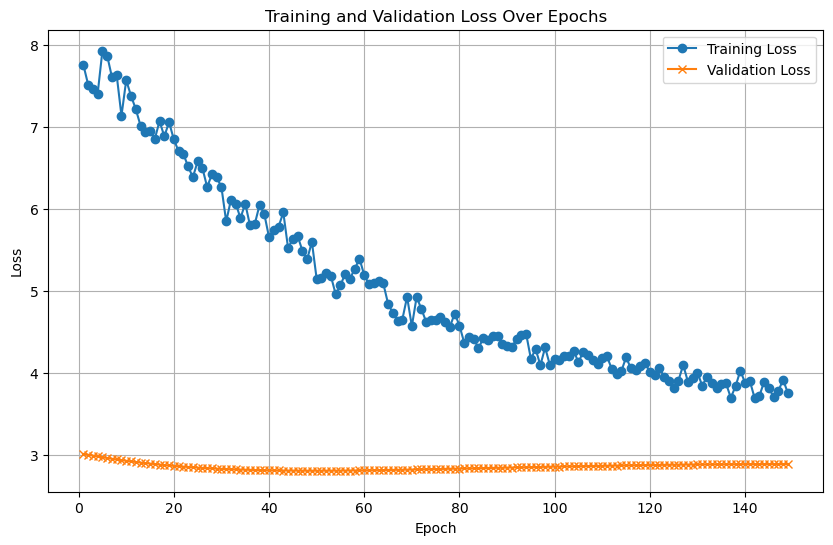

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 5.1704
Test Batch [20/211], Loss: 4.9456
Test Batch [30/211], Loss: 4.8340


Test Batch [40/211], Loss: 4.7675
Test Batch [50/211], Loss: 4.1327
Test Batch [60/211], Loss: 4.5810
Test Batch [70/211], Loss: 4.8684
Test Batch [80/211], Loss: 4.8829
Test Batch [90/211], Loss: 4.6804
Test Batch [100/211], Loss: 5.0202
Test Batch [110/211], Loss: 5.0531
Test Batch [120/211], Loss: 5.1446
Test Batch [130/211], Loss: 4.8913
Test Batch [140/211], Loss: 4.7788
Test Batch [150/211], Loss: 4.8295


Test Batch [160/211], Loss: 4.8544
Test Batch [170/211], Loss: 4.9142
Test Batch [180/211], Loss: 5.0019
Test Batch [190/211], Loss: 4.9865


Test Batch [200/211], Loss: 5.0589
Test Batch [210/211], Loss: 5.2273

Test Loss: 4.8898


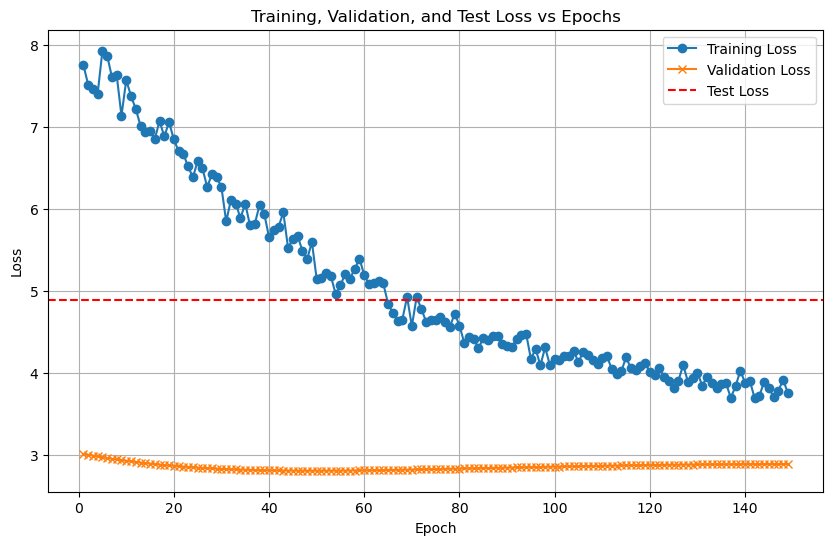

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...


Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.


  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.


  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.


  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.


  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.


  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.44      0.80      0.57         5
           8       0.56      1.00      0.71         5
           9       1.00      0.80      0.89         5
          10       0.00      0.00      0.00         5
          11       0.71      1.00      0.83         5
          12       0.83      1.00      0.91         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7638  |  Val Loss: 2.7507
Validation loss improved from inf to 2.7507.
[Epoch 2/1000] Train Loss: 2.7569  |  Val Loss: 2.7458
Validation loss improved from 2.7507 to 2.7458.
[Epoch 3/1000] Train Loss: 2.7511  |  Val Loss: 2.7410
Validation loss improved from 2.7458 to 2.7410.
[Epoch 4/1000] Train Loss: 2.7456  |  Val Loss: 2.7362
Validation loss improved from 2.7410 to 2.7362.
[Epoch 5/1000] Train Loss: 2.7400  |  Val Loss: 2.7316
Validation loss improved from 2.7362 to 2.7316.
[Epoch 6/1000] Train Loss: 2.7341  |  Val Loss: 2.7270
Validation loss improved from 2.7316 to 2.7270.
[Epoch 7/1000] Train Loss: 2.7287  |  Val Loss: 2.7226
Validation loss improved from 2.7270 to 2.7226.
[Epoch 8/1000] Train Loss: 2.7233  |  Val Loss: 2.7182
Validation loss improved from 2.7226 to 2.7182.
[Epoch 9/1000] Train Loss: 2.7180  |  Val Loss: 2.7136
Validation loss improved from 2.7182 to 2.7136.
[Epoch 10/1000] Train Loss: 2.7129  |  Val Loss: 2.7092
Validation loss impr

[Epoch 35/1000] Train Loss: 2.5972  |  Val Loss: 2.6049
Validation loss improved from 2.6088 to 2.6049.
[Epoch 36/1000] Train Loss: 2.5929  |  Val Loss: 2.6011
Validation loss improved from 2.6049 to 2.6011.
[Epoch 37/1000] Train Loss: 2.5887  |  Val Loss: 2.5974
Validation loss improved from 2.6011 to 2.5974.
[Epoch 38/1000] Train Loss: 2.5844  |  Val Loss: 2.5937
Validation loss improved from 2.5974 to 2.5937.
[Epoch 39/1000] Train Loss: 2.5805  |  Val Loss: 2.5900
Validation loss improved from 2.5937 to 2.5900.
[Epoch 40/1000] Train Loss: 2.5763  |  Val Loss: 2.5864
Validation loss improved from 2.5900 to 2.5864.
[Epoch 41/1000] Train Loss: 2.5721  |  Val Loss: 2.5828
Validation loss improved from 2.5864 to 2.5828.
[Epoch 42/1000] Train Loss: 2.5679  |  Val Loss: 2.5792
Validation loss improved from 2.5828 to 2.5792.
[Epoch 43/1000] Train Loss: 2.5639  |  Val Loss: 2.5756
Validation loss improved from 2.5792 to 2.5756.


[Epoch 44/1000] Train Loss: 2.5596  |  Val Loss: 2.5720
Validation loss improved from 2.5756 to 2.5720.
[Epoch 45/1000] Train Loss: 2.5556  |  Val Loss: 2.5683
Validation loss improved from 2.5720 to 2.5683.
[Epoch 46/1000] Train Loss: 2.5510  |  Val Loss: 2.5647
Validation loss improved from 2.5683 to 2.5647.
[Epoch 47/1000] Train Loss: 2.5469  |  Val Loss: 2.5610
Validation loss improved from 2.5647 to 2.5610.
[Epoch 48/1000] Train Loss: 2.5424  |  Val Loss: 2.5572
Validation loss improved from 2.5610 to 2.5572.
[Epoch 49/1000] Train Loss: 2.5383  |  Val Loss: 2.5534
Validation loss improved from 2.5572 to 2.5534.
[Epoch 50/1000] Train Loss: 2.5339  |  Val Loss: 2.5495
Validation loss improved from 2.5534 to 2.5495.
[Epoch 51/1000] Train Loss: 2.5299  |  Val Loss: 2.5458
Validation loss improved from 2.5495 to 2.5458.
[Epoch 52/1000] Train Loss: 2.5253  |  Val Loss: 2.5421
Validation loss improved from 2.5458 to 2.5421.
[Epoch 53/1000] Train Loss: 2.5211  |  Val Loss: 2.5382
Validati

[Epoch 78/1000] Train Loss: 2.4014  |  Val Loss: 2.4240
Validation loss improved from 2.4289 to 2.4240.
[Epoch 79/1000] Train Loss: 2.3960  |  Val Loss: 2.4191
Validation loss improved from 2.4240 to 2.4191.
[Epoch 80/1000] Train Loss: 2.3910  |  Val Loss: 2.4142
Validation loss improved from 2.4191 to 2.4142.
[Epoch 81/1000] Train Loss: 2.3855  |  Val Loss: 2.4091
Validation loss improved from 2.4142 to 2.4091.
[Epoch 82/1000] Train Loss: 2.3802  |  Val Loss: 2.4040
Validation loss improved from 2.4091 to 2.4040.
[Epoch 83/1000] Train Loss: 2.3749  |  Val Loss: 2.3989
Validation loss improved from 2.4040 to 2.3989.
[Epoch 84/1000] Train Loss: 2.3694  |  Val Loss: 2.3937
Validation loss improved from 2.3989 to 2.3937.


[Epoch 85/1000] Train Loss: 2.3640  |  Val Loss: 2.3887
Validation loss improved from 2.3937 to 2.3887.
[Epoch 86/1000] Train Loss: 2.3583  |  Val Loss: 2.3836
Validation loss improved from 2.3887 to 2.3836.
[Epoch 87/1000] Train Loss: 2.3529  |  Val Loss: 2.3785
Validation loss improved from 2.3836 to 2.3785.
[Epoch 88/1000] Train Loss: 2.3474  |  Val Loss: 2.3734
Validation loss improved from 2.3785 to 2.3734.
[Epoch 89/1000] Train Loss: 2.3418  |  Val Loss: 2.3683
Validation loss improved from 2.3734 to 2.3683.
[Epoch 90/1000] Train Loss: 2.3361  |  Val Loss: 2.3632
Validation loss improved from 2.3683 to 2.3632.
[Epoch 91/1000] Train Loss: 2.3306  |  Val Loss: 2.3579
Validation loss improved from 2.3632 to 2.3579.
[Epoch 92/1000] Train Loss: 2.3248  |  Val Loss: 2.3525
Validation loss improved from 2.3579 to 2.3525.
[Epoch 93/1000] Train Loss: 2.3191  |  Val Loss: 2.3471
Validation loss improved from 2.3525 to 2.3471.
[Epoch 94/1000] Train Loss: 2.3134  |  Val Loss: 2.3416
Validati

[Epoch 116/1000] Train Loss: 2.1815  |  Val Loss: 2.2186
Validation loss improved from 2.2241 to 2.2186.
[Epoch 117/1000] Train Loss: 2.1754  |  Val Loss: 2.2132
Validation loss improved from 2.2186 to 2.2132.
[Epoch 118/1000] Train Loss: 2.1693  |  Val Loss: 2.2079
Validation loss improved from 2.2132 to 2.2079.
[Epoch 119/1000] Train Loss: 2.1633  |  Val Loss: 2.2026
Validation loss improved from 2.2079 to 2.2026.
[Epoch 120/1000] Train Loss: 2.1574  |  Val Loss: 2.1972
Validation loss improved from 2.2026 to 2.1972.
[Epoch 121/1000] Train Loss: 2.1515  |  Val Loss: 2.1916
Validation loss improved from 2.1972 to 2.1916.
[Epoch 122/1000] Train Loss: 2.1457  |  Val Loss: 2.1860
Validation loss improved from 2.1916 to 2.1860.


[Epoch 123/1000] Train Loss: 2.1399  |  Val Loss: 2.1807
Validation loss improved from 2.1860 to 2.1807.
[Epoch 124/1000] Train Loss: 2.1342  |  Val Loss: 2.1753
Validation loss improved from 2.1807 to 2.1753.
[Epoch 125/1000] Train Loss: 2.1282  |  Val Loss: 2.1700
Validation loss improved from 2.1753 to 2.1700.
[Epoch 126/1000] Train Loss: 2.1224  |  Val Loss: 2.1648
Validation loss improved from 2.1700 to 2.1648.
[Epoch 127/1000] Train Loss: 2.1162  |  Val Loss: 2.1594
Validation loss improved from 2.1648 to 2.1594.
[Epoch 128/1000] Train Loss: 2.1103  |  Val Loss: 2.1539
Validation loss improved from 2.1594 to 2.1539.
[Epoch 129/1000] Train Loss: 2.1042  |  Val Loss: 2.1486
Validation loss improved from 2.1539 to 2.1486.
[Epoch 130/1000] Train Loss: 2.0981  |  Val Loss: 2.1433
Validation loss improved from 2.1486 to 2.1433.
[Epoch 131/1000] Train Loss: 2.0920  |  Val Loss: 2.1379
Validation loss improved from 2.1433 to 2.1379.
[Epoch 132/1000] Train Loss: 2.0863  |  Val Loss: 2.132

[Epoch 158/1000] Train Loss: 1.9371  |  Val Loss: 1.9978
Validation loss improved from 2.0029 to 1.9978.
[Epoch 159/1000] Train Loss: 1.9319  |  Val Loss: 1.9928
Validation loss improved from 1.9978 to 1.9928.
[Epoch 160/1000] Train Loss: 1.9263  |  Val Loss: 1.9878
Validation loss improved from 1.9928 to 1.9878.
[Epoch 161/1000] Train Loss: 1.9205  |  Val Loss: 1.9826
Validation loss improved from 1.9878 to 1.9826.
[Epoch 162/1000] Train Loss: 1.9146  |  Val Loss: 1.9773
Validation loss improved from 1.9826 to 1.9773.
[Epoch 163/1000] Train Loss: 1.9087  |  Val Loss: 1.9718
Validation loss improved from 1.9773 to 1.9718.
[Epoch 164/1000] Train Loss: 1.9029  |  Val Loss: 1.9663
Validation loss improved from 1.9718 to 1.9663.
[Epoch 165/1000] Train Loss: 1.8971  |  Val Loss: 1.9607
Validation loss improved from 1.9663 to 1.9607.
[Epoch 166/1000] Train Loss: 1.8913  |  Val Loss: 1.9553
Validation loss improved from 1.9607 to 1.9553.


[Epoch 167/1000] Train Loss: 1.8854  |  Val Loss: 1.9500
Validation loss improved from 1.9553 to 1.9500.
[Epoch 168/1000] Train Loss: 1.8797  |  Val Loss: 1.9450
Validation loss improved from 1.9500 to 1.9450.
[Epoch 169/1000] Train Loss: 1.8738  |  Val Loss: 1.9401
Validation loss improved from 1.9450 to 1.9401.
[Epoch 170/1000] Train Loss: 1.8679  |  Val Loss: 1.9353
Validation loss improved from 1.9401 to 1.9353.
[Epoch 171/1000] Train Loss: 1.8625  |  Val Loss: 1.9305
Validation loss improved from 1.9353 to 1.9305.
[Epoch 172/1000] Train Loss: 1.8565  |  Val Loss: 1.9257
Validation loss improved from 1.9305 to 1.9257.
[Epoch 173/1000] Train Loss: 1.8511  |  Val Loss: 1.9208
Validation loss improved from 1.9257 to 1.9208.
[Epoch 174/1000] Train Loss: 1.8453  |  Val Loss: 1.9158
Validation loss improved from 1.9208 to 1.9158.
[Epoch 175/1000] Train Loss: 1.8395  |  Val Loss: 1.9108
Validation loss improved from 1.9158 to 1.9108.
[Epoch 176/1000] Train Loss: 1.8336  |  Val Loss: 1.905

[Epoch 199/1000] Train Loss: 1.7061  |  Val Loss: 1.7875
Validation loss improved from 1.7930 to 1.7875.
[Epoch 200/1000] Train Loss: 1.7008  |  Val Loss: 1.7820
Validation loss improved from 1.7875 to 1.7820.
[Epoch 201/1000] Train Loss: 1.6958  |  Val Loss: 1.7768
Validation loss improved from 1.7820 to 1.7768.
[Epoch 202/1000] Train Loss: 1.6903  |  Val Loss: 1.7717
Validation loss improved from 1.7768 to 1.7717.
[Epoch 203/1000] Train Loss: 1.6850  |  Val Loss: 1.7667
Validation loss improved from 1.7717 to 1.7667.
[Epoch 204/1000] Train Loss: 1.6797  |  Val Loss: 1.7618
Validation loss improved from 1.7667 to 1.7618.
[Epoch 205/1000] Train Loss: 1.6745  |  Val Loss: 1.7571
Validation loss improved from 1.7618 to 1.7571.
[Epoch 206/1000] Train Loss: 1.6691  |  Val Loss: 1.7524
Validation loss improved from 1.7571 to 1.7524.
[Epoch 207/1000] Train Loss: 1.6642  |  Val Loss: 1.7479
Validation loss improved from 1.7524 to 1.7479.
[Epoch 208/1000] Train Loss: 1.6589  |  Val Loss: 1.743

[Epoch 209/1000] Train Loss: 1.6535  |  Val Loss: 1.7389
Validation loss improved from 1.7434 to 1.7389.
[Epoch 210/1000] Train Loss: 1.6483  |  Val Loss: 1.7345
Validation loss improved from 1.7389 to 1.7345.
[Epoch 211/1000] Train Loss: 1.6432  |  Val Loss: 1.7300
Validation loss improved from 1.7345 to 1.7300.
[Epoch 212/1000] Train Loss: 1.6380  |  Val Loss: 1.7252
Validation loss improved from 1.7300 to 1.7252.
[Epoch 213/1000] Train Loss: 1.6329  |  Val Loss: 1.7203
Validation loss improved from 1.7252 to 1.7203.
[Epoch 214/1000] Train Loss: 1.6275  |  Val Loss: 1.7154
Validation loss improved from 1.7203 to 1.7154.
[Epoch 215/1000] Train Loss: 1.6227  |  Val Loss: 1.7105
Validation loss improved from 1.7154 to 1.7105.
[Epoch 216/1000] Train Loss: 1.6173  |  Val Loss: 1.7058
Validation loss improved from 1.7105 to 1.7058.
[Epoch 217/1000] Train Loss: 1.6123  |  Val Loss: 1.7012
Validation loss improved from 1.7058 to 1.7012.
[Epoch 218/1000] Train Loss: 1.6069  |  Val Loss: 1.696

[Epoch 241/1000] Train Loss: 1.4892  |  Val Loss: 1.5933
Validation loss improved from 1.5974 to 1.5933.
[Epoch 242/1000] Train Loss: 1.4843  |  Val Loss: 1.5888
Validation loss improved from 1.5933 to 1.5888.
[Epoch 243/1000] Train Loss: 1.4791  |  Val Loss: 1.5839
Validation loss improved from 1.5888 to 1.5839.
[Epoch 244/1000] Train Loss: 1.4742  |  Val Loss: 1.5791
Validation loss improved from 1.5839 to 1.5791.
[Epoch 245/1000] Train Loss: 1.4691  |  Val Loss: 1.5743
Validation loss improved from 1.5791 to 1.5743.
[Epoch 246/1000] Train Loss: 1.4641  |  Val Loss: 1.5697
Validation loss improved from 1.5743 to 1.5697.
[Epoch 247/1000] Train Loss: 1.4590  |  Val Loss: 1.5650
Validation loss improved from 1.5697 to 1.5650.
[Epoch 248/1000] Train Loss: 1.4540  |  Val Loss: 1.5605
Validation loss improved from 1.5650 to 1.5605.
[Epoch 249/1000] Train Loss: 1.4495  |  Val Loss: 1.5559
Validation loss improved from 1.5605 to 1.5559.


[Epoch 250/1000] Train Loss: 1.4446  |  Val Loss: 1.5513
Validation loss improved from 1.5559 to 1.5513.
[Epoch 251/1000] Train Loss: 1.4394  |  Val Loss: 1.5467
Validation loss improved from 1.5513 to 1.5467.
[Epoch 252/1000] Train Loss: 1.4343  |  Val Loss: 1.5420
Validation loss improved from 1.5467 to 1.5420.
[Epoch 253/1000] Train Loss: 1.4293  |  Val Loss: 1.5374
Validation loss improved from 1.5420 to 1.5374.
[Epoch 254/1000] Train Loss: 1.4246  |  Val Loss: 1.5331
Validation loss improved from 1.5374 to 1.5331.
[Epoch 255/1000] Train Loss: 1.4199  |  Val Loss: 1.5287
Validation loss improved from 1.5331 to 1.5287.
[Epoch 256/1000] Train Loss: 1.4153  |  Val Loss: 1.5244
Validation loss improved from 1.5287 to 1.5244.
[Epoch 257/1000] Train Loss: 1.4105  |  Val Loss: 1.5197
Validation loss improved from 1.5244 to 1.5197.
[Epoch 258/1000] Train Loss: 1.4054  |  Val Loss: 1.5150
Validation loss improved from 1.5197 to 1.5150.
[Epoch 259/1000] Train Loss: 1.4006  |  Val Loss: 1.510

[Epoch 285/1000] Train Loss: 1.2868  |  Val Loss: 1.4065
Validation loss improved from 1.4107 to 1.4065.
[Epoch 286/1000] Train Loss: 1.2820  |  Val Loss: 1.4023
Validation loss improved from 1.4065 to 1.4023.
[Epoch 287/1000] Train Loss: 1.2778  |  Val Loss: 1.3982
Validation loss improved from 1.4023 to 1.3982.
[Epoch 288/1000] Train Loss: 1.2740  |  Val Loss: 1.3942
Validation loss improved from 1.3982 to 1.3942.
[Epoch 289/1000] Train Loss: 1.2699  |  Val Loss: 1.3902
Validation loss improved from 1.3942 to 1.3902.
[Epoch 290/1000] Train Loss: 1.2658  |  Val Loss: 1.3862
Validation loss improved from 1.3902 to 1.3862.
[Epoch 291/1000] Train Loss: 1.2615  |  Val Loss: 1.3822
Validation loss improved from 1.3862 to 1.3822.
[Epoch 292/1000] Train Loss: 1.2571  |  Val Loss: 1.3784
Validation loss improved from 1.3822 to 1.3784.
[Epoch 293/1000] Train Loss: 1.2532  |  Val Loss: 1.3748
Validation loss improved from 1.3784 to 1.3748.
[Epoch 294/1000] Train Loss: 1.2493  |  Val Loss: 1.371

[Epoch 297/1000] Train Loss: 1.2360  |  Val Loss: 1.3602
Validation loss improved from 1.3639 to 1.3602.
[Epoch 298/1000] Train Loss: 1.2319  |  Val Loss: 1.3563
Validation loss improved from 1.3602 to 1.3563.
[Epoch 299/1000] Train Loss: 1.2278  |  Val Loss: 1.3525
Validation loss improved from 1.3563 to 1.3525.
[Epoch 300/1000] Train Loss: 1.2237  |  Val Loss: 1.3487
Validation loss improved from 1.3525 to 1.3487.
[Epoch 301/1000] Train Loss: 1.2196  |  Val Loss: 1.3449
Validation loss improved from 1.3487 to 1.3449.
[Epoch 302/1000] Train Loss: 1.2155  |  Val Loss: 1.3410
Validation loss improved from 1.3449 to 1.3410.
[Epoch 303/1000] Train Loss: 1.2114  |  Val Loss: 1.3372
Validation loss improved from 1.3410 to 1.3372.
[Epoch 304/1000] Train Loss: 1.2071  |  Val Loss: 1.3334
Validation loss improved from 1.3372 to 1.3334.
[Epoch 305/1000] Train Loss: 1.2033  |  Val Loss: 1.3299
Validation loss improved from 1.3334 to 1.3299.
[Epoch 306/1000] Train Loss: 1.1994  |  Val Loss: 1.326

[Epoch 327/1000] Train Loss: 1.1210  |  Val Loss: 1.2526
Validation loss improved from 1.2557 to 1.2526.
[Epoch 328/1000] Train Loss: 1.1173  |  Val Loss: 1.2495
Validation loss improved from 1.2526 to 1.2495.
[Epoch 329/1000] Train Loss: 1.1138  |  Val Loss: 1.2467
Validation loss improved from 1.2495 to 1.2467.
[Epoch 330/1000] Train Loss: 1.1105  |  Val Loss: 1.2438
Validation loss improved from 1.2467 to 1.2438.
[Epoch 331/1000] Train Loss: 1.1067  |  Val Loss: 1.2411
Validation loss improved from 1.2438 to 1.2411.
[Epoch 332/1000] Train Loss: 1.1035  |  Val Loss: 1.2381
Validation loss improved from 1.2411 to 1.2381.
[Epoch 333/1000] Train Loss: 1.1000  |  Val Loss: 1.2345
Validation loss improved from 1.2381 to 1.2345.
[Epoch 334/1000] Train Loss: 1.0966  |  Val Loss: 1.2305
Validation loss improved from 1.2345 to 1.2305.
[Epoch 335/1000] Train Loss: 1.0926  |  Val Loss: 1.2264
Validation loss improved from 1.2305 to 1.2264.
[Epoch 336/1000] Train Loss: 1.0891  |  Val Loss: 1.222

[Epoch 340/1000] Train Loss: 1.0749  |  Val Loss: 1.2103
Validation loss improved from 1.2129 to 1.2103.
[Epoch 341/1000] Train Loss: 1.0717  |  Val Loss: 1.2076
Validation loss improved from 1.2103 to 1.2076.
[Epoch 342/1000] Train Loss: 1.0681  |  Val Loss: 1.2047
Validation loss improved from 1.2076 to 1.2047.
[Epoch 343/1000] Train Loss: 1.0646  |  Val Loss: 1.2015
Validation loss improved from 1.2047 to 1.2015.
[Epoch 344/1000] Train Loss: 1.0608  |  Val Loss: 1.1986
Validation loss improved from 1.2015 to 1.1986.
[Epoch 345/1000] Train Loss: 1.0573  |  Val Loss: 1.1958
Validation loss improved from 1.1986 to 1.1958.
[Epoch 346/1000] Train Loss: 1.0536  |  Val Loss: 1.1929
Validation loss improved from 1.1958 to 1.1929.
[Epoch 347/1000] Train Loss: 1.0503  |  Val Loss: 1.1898
Validation loss improved from 1.1929 to 1.1898.
[Epoch 348/1000] Train Loss: 1.0472  |  Val Loss: 1.1863
Validation loss improved from 1.1898 to 1.1863.
[Epoch 349/1000] Train Loss: 1.0437  |  Val Loss: 1.182

[Epoch 370/1000] Train Loss: 0.9758  |  Val Loss: 1.1216
Validation loss improved from 1.1242 to 1.1216.
[Epoch 371/1000] Train Loss: 0.9724  |  Val Loss: 1.1191
Validation loss improved from 1.1216 to 1.1191.
[Epoch 372/1000] Train Loss: 0.9695  |  Val Loss: 1.1163
Validation loss improved from 1.1191 to 1.1163.
[Epoch 373/1000] Train Loss: 0.9662  |  Val Loss: 1.1131
Validation loss improved from 1.1163 to 1.1131.
[Epoch 374/1000] Train Loss: 0.9630  |  Val Loss: 1.1099
Validation loss improved from 1.1131 to 1.1099.
[Epoch 375/1000] Train Loss: 0.9593  |  Val Loss: 1.1066
Validation loss improved from 1.1099 to 1.1066.
[Epoch 376/1000] Train Loss: 0.9561  |  Val Loss: 1.1037
Validation loss improved from 1.1066 to 1.1037.
[Epoch 377/1000] Train Loss: 0.9528  |  Val Loss: 1.1008
Validation loss improved from 1.1037 to 1.1008.
[Epoch 378/1000] Train Loss: 0.9505  |  Val Loss: 1.0978
Validation loss improved from 1.1008 to 1.0978.


[Epoch 379/1000] Train Loss: 0.9476  |  Val Loss: 1.0950
Validation loss improved from 1.0978 to 1.0950.
[Epoch 380/1000] Train Loss: 0.9451  |  Val Loss: 1.0921
Validation loss improved from 1.0950 to 1.0921.
[Epoch 381/1000] Train Loss: 0.9425  |  Val Loss: 1.0893
Validation loss improved from 1.0921 to 1.0893.
[Epoch 382/1000] Train Loss: 0.9397  |  Val Loss: 1.0864
Validation loss improved from 1.0893 to 1.0864.
[Epoch 383/1000] Train Loss: 0.9362  |  Val Loss: 1.0837
Validation loss improved from 1.0864 to 1.0837.
[Epoch 384/1000] Train Loss: 0.9327  |  Val Loss: 1.0815
Validation loss improved from 1.0837 to 1.0815.
[Epoch 385/1000] Train Loss: 0.9299  |  Val Loss: 1.0797
Validation loss improved from 1.0815 to 1.0797.
[Epoch 386/1000] Train Loss: 0.9270  |  Val Loss: 1.0780
Validation loss improved from 1.0797 to 1.0780.
[Epoch 387/1000] Train Loss: 0.9242  |  Val Loss: 1.0758
Validation loss improved from 1.0780 to 1.0758.
[Epoch 388/1000] Train Loss: 0.9217  |  Val Loss: 1.073

[Epoch 412/1000] Train Loss: 0.8563  |  Val Loss: 1.0127
Validation loss improved from 1.0152 to 1.0127.
[Epoch 413/1000] Train Loss: 0.8534  |  Val Loss: 1.0100
Validation loss improved from 1.0127 to 1.0100.
[Epoch 414/1000] Train Loss: 0.8506  |  Val Loss: 1.0076
Validation loss improved from 1.0100 to 1.0076.
[Epoch 415/1000] Train Loss: 0.8481  |  Val Loss: 1.0055
Validation loss improved from 1.0076 to 1.0055.
[Epoch 416/1000] Train Loss: 0.8459  |  Val Loss: 1.0037
Validation loss improved from 1.0055 to 1.0037.
[Epoch 417/1000] Train Loss: 0.8436  |  Val Loss: 1.0020
Validation loss improved from 1.0037 to 1.0020.
[Epoch 418/1000] Train Loss: 0.8411  |  Val Loss: 1.0004
Validation loss improved from 1.0020 to 1.0004.
[Epoch 419/1000] Train Loss: 0.8392  |  Val Loss: 0.9986
Validation loss improved from 1.0004 to 0.9986.
[Epoch 420/1000] Train Loss: 0.8366  |  Val Loss: 0.9967
Validation loss improved from 0.9986 to 0.9967.


[Epoch 421/1000] Train Loss: 0.8347  |  Val Loss: 0.9947
Validation loss improved from 0.9967 to 0.9947.
[Epoch 422/1000] Train Loss: 0.8320  |  Val Loss: 0.9928
Validation loss improved from 0.9947 to 0.9928.
[Epoch 423/1000] Train Loss: 0.8292  |  Val Loss: 0.9911
Validation loss improved from 0.9928 to 0.9911.
[Epoch 424/1000] Train Loss: 0.8268  |  Val Loss: 0.9894
Validation loss improved from 0.9911 to 0.9894.
[Epoch 425/1000] Train Loss: 0.8245  |  Val Loss: 0.9877
Validation loss improved from 0.9894 to 0.9877.
[Epoch 426/1000] Train Loss: 0.8226  |  Val Loss: 0.9857
Validation loss improved from 0.9877 to 0.9857.
[Epoch 427/1000] Train Loss: 0.8204  |  Val Loss: 0.9834
Validation loss improved from 0.9857 to 0.9834.
[Epoch 428/1000] Train Loss: 0.8177  |  Val Loss: 0.9809
Validation loss improved from 0.9834 to 0.9809.
[Epoch 429/1000] Train Loss: 0.8154  |  Val Loss: 0.9783
Validation loss improved from 0.9809 to 0.9783.
[Epoch 430/1000] Train Loss: 0.8124  |  Val Loss: 0.976

[Epoch 455/1000] Train Loss: 0.7570  |  Val Loss: 0.9246
Validation loss improved from 0.9266 to 0.9246.
[Epoch 456/1000] Train Loss: 0.7550  |  Val Loss: 0.9226
Validation loss improved from 0.9246 to 0.9226.
[Epoch 457/1000] Train Loss: 0.7528  |  Val Loss: 0.9207
Validation loss improved from 0.9226 to 0.9207.
[Epoch 458/1000] Train Loss: 0.7507  |  Val Loss: 0.9188
Validation loss improved from 0.9207 to 0.9188.
[Epoch 459/1000] Train Loss: 0.7486  |  Val Loss: 0.9170
Validation loss improved from 0.9188 to 0.9170.
[Epoch 460/1000] Train Loss: 0.7464  |  Val Loss: 0.9150
Validation loss improved from 0.9170 to 0.9150.
[Epoch 461/1000] Train Loss: 0.7445  |  Val Loss: 0.9131
Validation loss improved from 0.9150 to 0.9131.
[Epoch 462/1000] Train Loss: 0.7427  |  Val Loss: 0.9113
Validation loss improved from 0.9131 to 0.9113.
[Epoch 463/1000] Train Loss: 0.7407  |  Val Loss: 0.9099
Validation loss improved from 0.9113 to 0.9099.


[Epoch 464/1000] Train Loss: 0.7390  |  Val Loss: 0.9086
Validation loss improved from 0.9099 to 0.9086.
[Epoch 465/1000] Train Loss: 0.7374  |  Val Loss: 0.9074
Validation loss improved from 0.9086 to 0.9074.
[Epoch 466/1000] Train Loss: 0.7365  |  Val Loss: 0.9057
Validation loss improved from 0.9074 to 0.9057.
[Epoch 467/1000] Train Loss: 0.7343  |  Val Loss: 0.9034
Validation loss improved from 0.9057 to 0.9034.
[Epoch 468/1000] Train Loss: 0.7319  |  Val Loss: 0.9009
Validation loss improved from 0.9034 to 0.9009.
[Epoch 469/1000] Train Loss: 0.7294  |  Val Loss: 0.8983
Validation loss improved from 0.9009 to 0.8983.
[Epoch 470/1000] Train Loss: 0.7273  |  Val Loss: 0.8957
Validation loss improved from 0.8983 to 0.8957.
[Epoch 471/1000] Train Loss: 0.7251  |  Val Loss: 0.8931
Validation loss improved from 0.8957 to 0.8931.
[Epoch 472/1000] Train Loss: 0.7234  |  Val Loss: 0.8910
Validation loss improved from 0.8931 to 0.8910.
[Epoch 473/1000] Train Loss: 0.7213  |  Val Loss: 0.889

[Epoch 495/1000] Train Loss: 0.6811  |  Val Loss: 0.8557
Validation loss improved from 0.8567 to 0.8557.
[Epoch 496/1000] Train Loss: 0.6794  |  Val Loss: 0.8549
Validation loss improved from 0.8557 to 0.8549.
[Epoch 497/1000] Train Loss: 0.6780  |  Val Loss: 0.8539
Validation loss improved from 0.8549 to 0.8539.
[Epoch 498/1000] Train Loss: 0.6763  |  Val Loss: 0.8525
Validation loss improved from 0.8539 to 0.8525.
[Epoch 499/1000] Train Loss: 0.6747  |  Val Loss: 0.8510
Validation loss improved from 0.8525 to 0.8510.
[Epoch 500/1000] Train Loss: 0.6733  |  Val Loss: 0.8494
Validation loss improved from 0.8510 to 0.8494.
[Epoch 501/1000] Train Loss: 0.6715  |  Val Loss: 0.8479
Validation loss improved from 0.8494 to 0.8479.
[Epoch 502/1000] Train Loss: 0.6704  |  Val Loss: 0.8462
Validation loss improved from 0.8479 to 0.8462.
[Epoch 503/1000] Train Loss: 0.6685  |  Val Loss: 0.8444
Validation loss improved from 0.8462 to 0.8444.


[Epoch 504/1000] Train Loss: 0.6665  |  Val Loss: 0.8424
Validation loss improved from 0.8444 to 0.8424.
[Epoch 505/1000] Train Loss: 0.6650  |  Val Loss: 0.8407
Validation loss improved from 0.8424 to 0.8407.
[Epoch 506/1000] Train Loss: 0.6624  |  Val Loss: 0.8391
Validation loss improved from 0.8407 to 0.8391.
[Epoch 507/1000] Train Loss: 0.6611  |  Val Loss: 0.8379
Validation loss improved from 0.8391 to 0.8379.
[Epoch 508/1000] Train Loss: 0.6602  |  Val Loss: 0.8368
Validation loss improved from 0.8379 to 0.8368.
[Epoch 509/1000] Train Loss: 0.6584  |  Val Loss: 0.8355
Validation loss improved from 0.8368 to 0.8355.
[Epoch 510/1000] Train Loss: 0.6569  |  Val Loss: 0.8341
Validation loss improved from 0.8355 to 0.8341.
[Epoch 511/1000] Train Loss: 0.6547  |  Val Loss: 0.8329
Validation loss improved from 0.8341 to 0.8329.
[Epoch 512/1000] Train Loss: 0.6529  |  Val Loss: 0.8318
Validation loss improved from 0.8329 to 0.8318.
[Epoch 513/1000] Train Loss: 0.6513  |  Val Loss: 0.830

[Epoch 539/1000] Train Loss: 0.6106  |  Val Loss: 0.7960
Validation loss improved from 0.7977 to 0.7960.


[Epoch 540/1000] Train Loss: 0.6100  |  Val Loss: 0.7948
Validation loss improved from 0.7960 to 0.7948.
[Epoch 541/1000] Train Loss: 0.6094  |  Val Loss: 0.7940
Validation loss improved from 0.7948 to 0.7940.
[Epoch 542/1000] Train Loss: 0.6078  |  Val Loss: 0.7930
Validation loss improved from 0.7940 to 0.7930.
[Epoch 543/1000] Train Loss: 0.6070  |  Val Loss: 0.7917
Validation loss improved from 0.7930 to 0.7917.
[Epoch 544/1000] Train Loss: 0.6054  |  Val Loss: 0.7901
Validation loss improved from 0.7917 to 0.7901.
[Epoch 545/1000] Train Loss: 0.6041  |  Val Loss: 0.7884
Validation loss improved from 0.7901 to 0.7884.
[Epoch 546/1000] Train Loss: 0.6022  |  Val Loss: 0.7868
Validation loss improved from 0.7884 to 0.7868.
[Epoch 547/1000] Train Loss: 0.6006  |  Val Loss: 0.7851
Validation loss improved from 0.7868 to 0.7851.
[Epoch 548/1000] Train Loss: 0.5988  |  Val Loss: 0.7833
Validation loss improved from 0.7851 to 0.7833.
[Epoch 549/1000] Train Loss: 0.5974  |  Val Loss: 0.781

[Epoch 579/1000] Train Loss: 0.5580  |  Val Loss: 0.7507
Validation loss improved from 0.7520 to 0.7507.
[Epoch 580/1000] Train Loss: 0.5565  |  Val Loss: 0.7497
Validation loss improved from 0.7507 to 0.7497.
[Epoch 581/1000] Train Loss: 0.5554  |  Val Loss: 0.7489
Validation loss improved from 0.7497 to 0.7489.
[Epoch 582/1000] Train Loss: 0.5548  |  Val Loss: 0.7485
Validation loss improved from 0.7489 to 0.7485.
[Epoch 583/1000] Train Loss: 0.5537  |  Val Loss: 0.7481
Validation loss improved from 0.7485 to 0.7481.
[Epoch 584/1000] Train Loss: 0.5529  |  Val Loss: 0.7478
Validation loss improved from 0.7481 to 0.7478.
[Epoch 585/1000] Train Loss: 0.5517  |  Val Loss: 0.7472
Validation loss improved from 0.7478 to 0.7472.
[Epoch 586/1000] Train Loss: 0.5507  |  Val Loss: 0.7464
Validation loss improved from 0.7472 to 0.7464.
[Epoch 587/1000] Train Loss: 0.5492  |  Val Loss: 0.7453
Validation loss improved from 0.7464 to 0.7453.
[Epoch 588/1000] Train Loss: 0.5480  |  Val Loss: 0.744

[Epoch 620/1000] Train Loss: 0.5116  |  Val Loss: 0.7144
Validation loss improved from 0.7154 to 0.7144.
[Epoch 621/1000] Train Loss: 0.5103  |  Val Loss: 0.7135
Validation loss improved from 0.7144 to 0.7135.
[Epoch 622/1000] Train Loss: 0.5095  |  Val Loss: 0.7127
Validation loss improved from 0.7135 to 0.7127.
[Epoch 623/1000] Train Loss: 0.5083  |  Val Loss: 0.7119
Validation loss improved from 0.7127 to 0.7119.
[Epoch 624/1000] Train Loss: 0.5072  |  Val Loss: 0.7110
Validation loss improved from 0.7119 to 0.7110.
[Epoch 625/1000] Train Loss: 0.5063  |  Val Loss: 0.7101
Validation loss improved from 0.7110 to 0.7101.
[Epoch 626/1000] Train Loss: 0.5049  |  Val Loss: 0.7096
Validation loss improved from 0.7101 to 0.7096.
[Epoch 627/1000] Train Loss: 0.5044  |  Val Loss: 0.7093
Validation loss improved from 0.7096 to 0.7093.
[Epoch 628/1000] Train Loss: 0.5040  |  Val Loss: 0.7089
Validation loss improved from 0.7093 to 0.7089.
[Epoch 629/1000] Train Loss: 0.5032  |  Val Loss: 0.708

[Epoch 659/1000] Train Loss: 0.4727  |  Val Loss: 0.6837
Validation loss improved from 0.6846 to 0.6837.
[Epoch 660/1000] Train Loss: 0.4727  |  Val Loss: 0.6831
Validation loss improved from 0.6837 to 0.6831.
[Epoch 661/1000] Train Loss: 0.4725  |  Val Loss: 0.6824
Validation loss improved from 0.6831 to 0.6824.
[Epoch 662/1000] Train Loss: 0.4728  |  Val Loss: 0.6816
Validation loss improved from 0.6824 to 0.6816.
[Epoch 663/1000] Train Loss: 0.4713  |  Val Loss: 0.6808
Validation loss improved from 0.6816 to 0.6808.
[Epoch 664/1000] Train Loss: 0.4705  |  Val Loss: 0.6799
Validation loss improved from 0.6808 to 0.6799.
[Epoch 665/1000] Train Loss: 0.4687  |  Val Loss: 0.6790
Validation loss improved from 0.6799 to 0.6790.
[Epoch 666/1000] Train Loss: 0.4675  |  Val Loss: 0.6781
Validation loss improved from 0.6790 to 0.6781.
[Epoch 667/1000] Train Loss: 0.4658  |  Val Loss: 0.6771
Validation loss improved from 0.6781 to 0.6771.
[Epoch 668/1000] Train Loss: 0.4642  |  Val Loss: 0.676

[Epoch 700/1000] Train Loss: 0.4354  |  Val Loss: 0.6575
Validation loss improved from 0.6586 to 0.6575.
[Epoch 701/1000] Train Loss: 0.4340  |  Val Loss: 0.6561
Validation loss improved from 0.6575 to 0.6561.
[Epoch 702/1000] Train Loss: 0.4344  |  Val Loss: 0.6549
Validation loss improved from 0.6561 to 0.6549.
[Epoch 703/1000] Train Loss: 0.4340  |  Val Loss: 0.6540
Validation loss improved from 0.6549 to 0.6540.
[Epoch 704/1000] Train Loss: 0.4334  |  Val Loss: 0.6530
Validation loss improved from 0.6540 to 0.6530.
[Epoch 705/1000] Train Loss: 0.4328  |  Val Loss: 0.6521
Validation loss improved from 0.6530 to 0.6521.
[Epoch 706/1000] Train Loss: 0.4329  |  Val Loss: 0.6514
Validation loss improved from 0.6521 to 0.6514.
[Epoch 707/1000] Train Loss: 0.4320  |  Val Loss: 0.6508
Validation loss improved from 0.6514 to 0.6508.
[Epoch 708/1000] Train Loss: 0.4308  |  Val Loss: 0.6502
Validation loss improved from 0.6508 to 0.6502.
[Epoch 709/1000] Train Loss: 0.4297  |  Val Loss: 0.649

[Epoch 741/1000] Train Loss: 0.4026  |  Val Loss: 0.6292
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 742/1000] Train Loss: 0.4021  |  Val Loss: 0.6294
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 743/1000] Train Loss: 0.4014  |  Val Loss: 0.6297
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 744/1000] Train Loss: 0.4009  |  Val Loss: 0.6301
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 745/1000] Train Loss: 0.4003  |  Val Loss: 0.6303
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 746/1000] Train Loss: 0.3993  |  Val Loss: 0.6303
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 747/1000] Train Loss: 0.3987  |  Val Loss: 0.6303
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 748/1000] Train Loss: 0.3983  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 749/1000] Train Loss: 0.3976  |  Val Loss: 0.6299
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 783/1000] Train Loss: 0.3733  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 784/1000] Train Loss: 0.3724  |  Val Loss: 0.6141
Validation loss improved from 0.6141 to 0.6141.
[Epoch 785/1000] Train Loss: 0.3719  |  Val Loss: 0.6135
Validation loss improved from 0.6141 to 0.6135.
[Epoch 786/1000] Train Loss: 0.3708  |  Val Loss: 0.6123
Validation loss improved from 0.6135 to 0.6123.
[Epoch 787/1000] Train Loss: 0.3694  |  Val Loss: 0.6111
Validation loss improved from 0.6123 to 0.6111.
[Epoch 788/1000] Train Loss: 0.3692  |  Val Loss: 0.6102
Validation loss improved from 0.6111 to 0.6102.
[Epoch 789/1000] Train Loss: 0.3677  |  Val Loss: 0.6097
Validation loss improved from 0.6102 to 0.6097.
[Epoch 790/1000] Train Loss: 0.3674  |  Val Loss: 0.6093
Validation loss improved from 0.6097 to 0.6093.
[Epoch 791/1000] Train Loss: 0.3666  |  Val Loss: 0.6089
Validation loss improved from 0.6093 to 0.6089.
[Epoch 792/1000] Train Loss: 0.3664  |  Val Loss:

[Epoch 824/1000] Train Loss: 0.3451  |  Val Loss: 0.5933
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 825/1000] Train Loss: 0.3447  |  Val Loss: 0.5933
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 826/1000] Train Loss: 0.3438  |  Val Loss: 0.5930
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 827/1000] Train Loss: 0.3431  |  Val Loss: 0.5926
Validation loss improved from 0.5930 to 0.5926.
[Epoch 828/1000] Train Loss: 0.3427  |  Val Loss: 0.5920
Validation loss improved from 0.5926 to 0.5920.
[Epoch 829/1000] Train Loss: 0.3422  |  Val Loss: 0.5917
Validation loss improved from 0.5920 to 0.5917.
[Epoch 830/1000] Train Loss: 0.3411  |  Val Loss: 0.5919
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 831/1000] Train Loss: 0.3408  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 832/1000] Train Loss: 0.3402  |  Val Loss: 0.5925
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 833/1000] Tr

[Epoch 865/1000] Train Loss: 0.3207  |  Val Loss: 0.5823
Validation loss improved from 0.5829 to 0.5823.
[Epoch 866/1000] Train Loss: 0.3202  |  Val Loss: 0.5818
Validation loss improved from 0.5823 to 0.5818.
[Epoch 867/1000] Train Loss: 0.3194  |  Val Loss: 0.5815
Validation loss improved from 0.5818 to 0.5815.
[Epoch 868/1000] Train Loss: 0.3187  |  Val Loss: 0.5815
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 869/1000] Train Loss: 0.3185  |  Val Loss: 0.5818
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 870/1000] Train Loss: 0.3184  |  Val Loss: 0.5819
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 871/1000] Train Loss: 0.3178  |  Val Loss: 0.5819
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 872/1000] Train Loss: 0.3172  |  Val Loss: 0.5817
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 873/1000] Train Loss: 0.3167  |  Val Loss: 0.5817
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 874/1000] Tr

[Epoch 903/1000] Train Loss: 0.3015  |  Val Loss: 0.5741
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 904/1000] Train Loss: 0.3008  |  Val Loss: 0.5740
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 905/1000] Train Loss: 0.3002  |  Val Loss: 0.5738
Validation loss improved from 0.5740 to 0.5738.
[Epoch 906/1000] Train Loss: 0.2997  |  Val Loss: 0.5730
Validation loss improved from 0.5738 to 0.5730.
[Epoch 907/1000] Train Loss: 0.2987  |  Val Loss: 0.5722
Validation loss improved from 0.5730 to 0.5722.
[Epoch 908/1000] Train Loss: 0.2979  |  Val Loss: 0.5714
Validation loss improved from 0.5722 to 0.5714.
[Epoch 909/1000] Train Loss: 0.2976  |  Val Loss: 0.5705
Validation loss improved from 0.5714 to 0.5705.
[Epoch 910/1000] Train Loss: 0.2972  |  Val Loss: 0.5700
Validation loss improved from 0.5705 to 0.5700.
[Epoch 911/1000] Train Loss: 0.2965  |  Val Loss: 0.5701
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 912/1000] Train Loss: 0.2961  

[Epoch 946/1000] Train Loss: 0.2815  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 947/1000] Train Loss: 0.2814  |  Val Loss: 0.5704
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 948/1000] Train Loss: 0.2811  |  Val Loss: 0.5693
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 949/1000] Train Loss: 0.2804  |  Val Loss: 0.5677
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 950/1000] Train Loss: 0.2791  |  Val Loss: 0.5658
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 951/1000] Train Loss: 0.2781  |  Val Loss: 0.5641
Validation loss improved from 0.5657 to 0.5641.
[Epoch 952/1000] Train Loss: 0.2769  |  Val Loss: 0.5627
Validation loss improved from 0.5641 to 0.5627.
[Epoch 953/1000] Train Loss: 0.2766  |  Val Loss: 0.5616
Validation loss improved from 0.5627 to 0.5616.
[Epoch 954/1000] Train Loss: 0.2758  |  Val Loss: 0.5609
Validation loss improved from 0.5616 to 0.5609.
[Epoch 955/1000] Tra

[Epoch 986/1000] Train Loss: 0.2621  |  Val Loss: 0.5603
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 987/1000] Train Loss: 0.2620  |  Val Loss: 0.5602
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 988/1000] Train Loss: 0.2618  |  Val Loss: 0.5597
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 989/1000] Train Loss: 0.2612  |  Val Loss: 0.5588
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 990/1000] Train Loss: 0.2612  |  Val Loss: 0.5579
Validation loss improved from 0.5585 to 0.5579.
[Epoch 991/1000] Train Loss: 0.2606  |  Val Loss: 0.5572
Validation loss improved from 0.5579 to 0.5572.
[Epoch 992/1000] Train Loss: 0.2599  |  Val Loss: 0.5567
Validation loss improved from 0.5572 to 0.5567.
[Epoch 993/1000] Train Loss: 0.2593  |  Val Loss: 0.5561
Validation loss improved from 0.5567 to 0.5561.
[Epoch 994/1000] Train Loss: 0.2588  |  Val Loss: 0.5558
Validation loss improved from 0.5561 to 0.5558.
[Epoch 995/1000] Train Loss

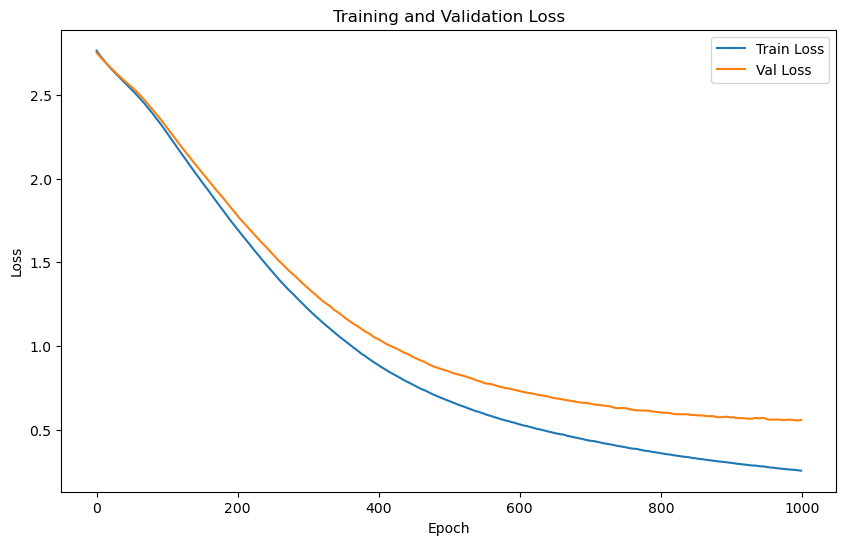

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6677 | Test Accuracy: 81.75%


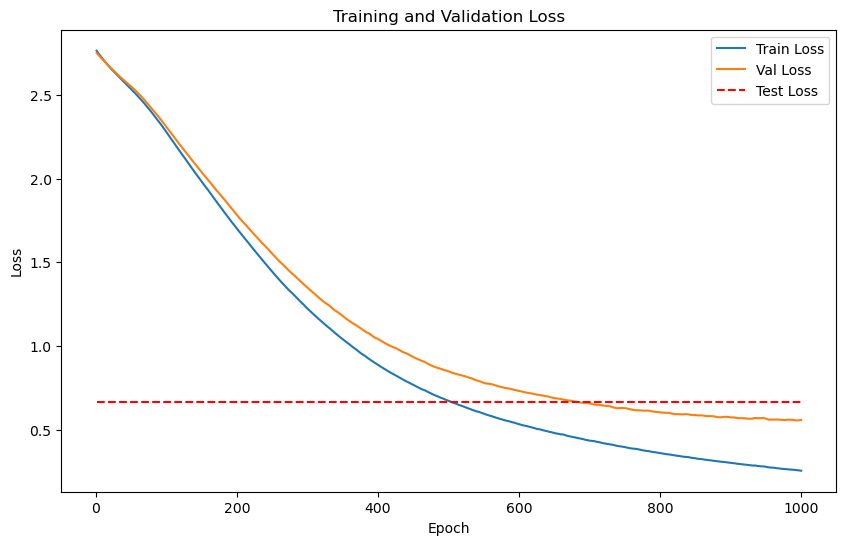

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.3523
Epoch [1/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.3566

Validation loss improved from inf to 0.3566. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.3478
Epoch [2/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.3549

Validation loss improved from 0.3566 to 0.3549. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.3441
Epoch [3/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3531

Validation loss improved from 0.3549 to 0.3531. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.3410
Epoch [4/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.3518

Validation loss improved from 0.3531 to 0.3518. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.3389
Epoch [5/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.3511

Validation loss improved from 0.3518 to 0.3511. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.3371
Epoch [6/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.3510

Validation loss improved from 0.3511 to 0.3510. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.3351
Epoch [7/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.3514

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.3327
Epoch [8/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.3295
Epoch [9/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.3498

Validation loss improved from 0.3510 to 0.3498. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.3267
Epoch [10/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3487

Validation loss improved from 0.3498 to 0.3487. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.3243
Epoch [11/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3476

Validation loss improved from 0.3487 to 0.3476. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.3220
Epoch [12/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.3467

Validation loss improved from 0.3476 to 0.3467. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.3203
Epoch [13/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3458

Validation loss improved from 0.3467 to 0.3458. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.3184
Epoch [14/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.3448

Validation loss improved from 0.3458 to 0.3448. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.3163
Epoch [15/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.3435

Validation loss improved from 0.3448 to 0.3435. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.3141
Epoch [16/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.3420

Validation loss improved from 0.3435 to 0.3420. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3691
    Batch [2/2], Val Loss: 0.3120
Epoch [17/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.3406

Validation loss improved from 0.3420 to 0.3406. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.3102
Epoch [18/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3393

Validation loss improved from 0.3406 to 0.3393. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.3088
Epoch [19/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3382

Validation loss improved from 0.3393 to 0.3382. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.3080
Epoch [20/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3373

Validation loss improved from 0.3382 to 0.3373. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.3077
Epoch [21/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.3366

Validation loss improved from 0.3373 to 0.3366. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.3074
Epoch [22/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3359

Validation loss improved from 0.3366 to 0.3359. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.3070
Epoch [23/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3351

Validation loss improved from 0.3359 to 0.3351. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.3066
Epoch [24/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3343

Validation loss improved from 0.3351 to 0.3343. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.3062
Epoch [25/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3336

Validation loss improved from 0.3343 to 0.3336. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3599
    Batch [2/2], Val Loss: 0.3058
Epoch [26/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3328

Validation loss improved from 0.3336 to 0.3328. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.3054
Epoch [27/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3321

Validation loss improved from 0.3328 to 0.3321. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.3051
Epoch [28/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3314

Validation loss improved from 0.3321 to 0.3314. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.3049
Epoch [29/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3308

Validation loss improved from 0.3314 to 0.3308. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.3045
Epoch [30/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3302

Validation loss improved from 0.3308 to 0.3302. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.3042
Epoch [31/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3296

Validation loss improved from 0.3302 to 0.3296. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.3039
Epoch [32/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3290

Validation loss improved from 0.3296 to 0.3290. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3532
    Batch [2/2], Val Loss: 0.3036
Epoch [33/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3284

Validation loss improved from 0.3290 to 0.3284. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.3033
Epoch [34/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.3278

Validation loss improved from 0.3284 to 0.3278. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.3030
Epoch [35/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3273

Validation loss improved from 0.3278 to 0.3273. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.3028
Epoch [36/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3268

Validation loss improved from 0.3273 to 0.3268. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.3025
Epoch [37/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3263

Validation loss improved from 0.3268 to 0.3263. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.3022
Epoch [38/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3258

Validation loss improved from 0.3263 to 0.3258. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.3019
Epoch [39/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3253

Validation loss improved from 0.3258 to 0.3253. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.3017
Epoch [40/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3248

Validation loss improved from 0.3253 to 0.3248. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.3014
Epoch [41/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.3243

Validation loss improved from 0.3248 to 0.3243. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.3012
Epoch [42/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3239

Validation loss improved from 0.3243 to 0.3239. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3459
    Batch [2/2], Val Loss: 0.3009
Epoch [43/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3234

Validation loss improved from 0.3239 to 0.3234. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3453
    Batch [2/2], Val Loss: 0.3007
Epoch [44/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3230

Validation loss improved from 0.3234 to 0.3230. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.3004
Epoch [45/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3225

Validation loss improved from 0.3230 to 0.3225. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.3002
Epoch [46/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3221

Validation loss improved from 0.3225 to 0.3221. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3434
    Batch [2/2], Val Loss: 0.2999
Epoch [47/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3216

Validation loss improved from 0.3221 to 0.3216. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3427
    Batch [2/2], Val Loss: 0.2997
Epoch [48/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3212

Validation loss improved from 0.3216 to 0.3212. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.2995
Epoch [49/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3207

Validation loss improved from 0.3212 to 0.3207. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.2992
Epoch [50/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3203

Validation loss improved from 0.3207 to 0.3203. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3407
    Batch [2/2], Val Loss: 0.2990
Epoch [51/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3198

Validation loss improved from 0.3203 to 0.3198. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.2988
Epoch [52/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3194

Validation loss improved from 0.3198 to 0.3194. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3393
    Batch [2/2], Val Loss: 0.2985
Epoch [53/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3189

Validation loss improved from 0.3194 to 0.3189. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.2982
Epoch [54/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3184

Validation loss improved from 0.3189 to 0.3184. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.2979
Epoch [55/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3180

Validation loss improved from 0.3184 to 0.3180. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.2976
Epoch [56/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3175

Validation loss improved from 0.3180 to 0.3175. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.2973
Epoch [57/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3171

Validation loss improved from 0.3175 to 0.3171. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.2969
Epoch [58/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3165

Validation loss improved from 0.3171 to 0.3165. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3355
    Batch [2/2], Val Loss: 0.2966
Epoch [59/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.3160

Validation loss improved from 0.3165 to 0.3160. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.2961
Epoch [60/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.3155

Validation loss improved from 0.3160 to 0.3155. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.2957
Epoch [61/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3149

Validation loss improved from 0.3155 to 0.3149. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.2952
Epoch [62/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3144

Validation loss improved from 0.3149 to 0.3144. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3330
    Batch [2/2], Val Loss: 0.2947
Epoch [63/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3138

Validation loss improved from 0.3144 to 0.3138. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.2942
Epoch [64/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3133

Validation loss improved from 0.3138 to 0.3133. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3318
    Batch [2/2], Val Loss: 0.2937
Epoch [65/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3127

Validation loss improved from 0.3133 to 0.3127. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3312
    Batch [2/2], Val Loss: 0.2932
Epoch [66/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3122

Validation loss improved from 0.3127 to 0.3122. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3306
    Batch [2/2], Val Loss: 0.2927
Epoch [67/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3117

Validation loss improved from 0.3122 to 0.3117. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3301
    Batch [2/2], Val Loss: 0.2923
Epoch [68/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3112

Validation loss improved from 0.3117 to 0.3112. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3296
    Batch [2/2], Val Loss: 0.2918
Epoch [69/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3107

Validation loss improved from 0.3112 to 0.3107. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3290
    Batch [2/2], Val Loss: 0.2913
Epoch [70/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.3102

Validation loss improved from 0.3107 to 0.3102. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.2908
Epoch [71/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3096

Validation loss improved from 0.3102 to 0.3096. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.2902
Epoch [72/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3090

Validation loss improved from 0.3096 to 0.3090. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3273
    Batch [2/2], Val Loss: 0.2897
Epoch [73/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3085

Validation loss improved from 0.3090 to 0.3085. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3267
    Batch [2/2], Val Loss: 0.2892
Epoch [74/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.3079

Validation loss improved from 0.3085 to 0.3079. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3261
    Batch [2/2], Val Loss: 0.2887
Epoch [75/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3074

Validation loss improved from 0.3079 to 0.3074. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.2882
Epoch [76/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3068

Validation loss improved from 0.3074 to 0.3068. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.2877
Epoch [77/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3063

Validation loss improved from 0.3068 to 0.3063. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3244
    Batch [2/2], Val Loss: 0.2872
Epoch [78/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3058

Validation loss improved from 0.3063 to 0.3058. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3238
    Batch [2/2], Val Loss: 0.2868
Epoch [79/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3053

Validation loss improved from 0.3058 to 0.3053. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3233
    Batch [2/2], Val Loss: 0.2863
Epoch [80/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3048

Validation loss improved from 0.3053 to 0.3048. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.2859
Epoch [81/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.3043

Validation loss improved from 0.3048 to 0.3043. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3223
    Batch [2/2], Val Loss: 0.2855
Epoch [82/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3039

Validation loss improved from 0.3043 to 0.3039. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3218
    Batch [2/2], Val Loss: 0.2850
Epoch [83/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3034

Validation loss improved from 0.3039 to 0.3034. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.2845
Epoch [84/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3029

Validation loss improved from 0.3034 to 0.3029. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3209
    Batch [2/2], Val Loss: 0.2841
Epoch [85/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3025

Validation loss improved from 0.3029 to 0.3025. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3205
    Batch [2/2], Val Loss: 0.2837
Epoch [86/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.3021

Validation loss improved from 0.3025 to 0.3021. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3201
    Batch [2/2], Val Loss: 0.2834
Epoch [87/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3017

Validation loss improved from 0.3021 to 0.3017. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3197
    Batch [2/2], Val Loss: 0.2831
Epoch [88/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3014

Validation loss improved from 0.3017 to 0.3014. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.2828
Epoch [89/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3010

Validation loss improved from 0.3014 to 0.3010. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3189
    Batch [2/2], Val Loss: 0.2825
Epoch [90/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3007

Validation loss improved from 0.3010 to 0.3007. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.2822
Epoch [91/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3004

Validation loss improved from 0.3007 to 0.3004. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3182
    Batch [2/2], Val Loss: 0.2819
Epoch [92/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3001

Validation loss improved from 0.3004 to 0.3001. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3179
    Batch [2/2], Val Loss: 0.2816
Epoch [93/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2997

Validation loss improved from 0.3001 to 0.2997. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.2813
Epoch [94/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2994

Validation loss improved from 0.2997 to 0.2994. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.2810
Epoch [95/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2991

Validation loss improved from 0.2994 to 0.2991. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.2808
Epoch [96/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2987

Validation loss improved from 0.2991 to 0.2987. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.2805
Epoch [97/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2984

Validation loss improved from 0.2987 to 0.2984. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.2803
Epoch [98/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2981

Validation loss improved from 0.2984 to 0.2981. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.2800
Epoch [99/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2977

Validation loss improved from 0.2981 to 0.2977. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.2798
Epoch [100/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2974

Validation loss improved from 0.2977 to 0.2974. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.2795
Epoch [101/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2970

Validation loss improved from 0.2974 to 0.2970. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.2792
Epoch [102/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2967

Validation loss improved from 0.2970 to 0.2967. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3136
    Batch [2/2], Val Loss: 0.2790
Epoch [103/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2963

Validation loss improved from 0.2967 to 0.2963. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.2787
Epoch [104/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2960

Validation loss improved from 0.2963 to 0.2960. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3128
    Batch [2/2], Val Loss: 0.2785
Epoch [105/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2957

Validation loss improved from 0.2960 to 0.2957. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3124
    Batch [2/2], Val Loss: 0.2783
Epoch [106/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2954

Validation loss improved from 0.2957 to 0.2954. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3121
    Batch [2/2], Val Loss: 0.2780
Epoch [107/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2950

Validation loss improved from 0.2954 to 0.2950. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.2778
Epoch [108/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.2775
Epoch [109/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2945

Validation loss improved from 0.2947 to 0.2945. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3111
    Batch [2/2], Val Loss: 0.2773
Epoch [110/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2942

Validation loss improved from 0.2945 to 0.2942. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.2770
Epoch [111/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2939

Validation loss improved from 0.2942 to 0.2939. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.2766
Epoch [112/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2936

Validation loss improved from 0.2939 to 0.2936. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3102
    Batch [2/2], Val Loss: 0.2762
Epoch [113/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2932

Validation loss improved from 0.2936 to 0.2932. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3099
    Batch [2/2], Val Loss: 0.2757
Epoch [114/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2928

Validation loss improved from 0.2932 to 0.2928. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.2752
Epoch [115/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2924

Validation loss improved from 0.2928 to 0.2924. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3093
    Batch [2/2], Val Loss: 0.2748
Epoch [116/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2921

Validation loss improved from 0.2924 to 0.2921. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.2742
Epoch [117/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2917

Validation loss improved from 0.2921 to 0.2917. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3089
    Batch [2/2], Val Loss: 0.2737
Epoch [118/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2913

Validation loss improved from 0.2917 to 0.2913. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3086
    Batch [2/2], Val Loss: 0.2732
Epoch [119/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2909

Validation loss improved from 0.2913 to 0.2909. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3084
    Batch [2/2], Val Loss: 0.2727
Epoch [120/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2905

Validation loss improved from 0.2909 to 0.2905. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3081
    Batch [2/2], Val Loss: 0.2722
Epoch [121/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2901

Validation loss improved from 0.2905 to 0.2901. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.2717
Epoch [122/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2897

Validation loss improved from 0.2901 to 0.2897. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.2712
Epoch [123/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2893

Validation loss improved from 0.2897 to 0.2893. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3071
    Batch [2/2], Val Loss: 0.2708
Epoch [124/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2890

Validation loss improved from 0.2893 to 0.2890. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3069
    Batch [2/2], Val Loss: 0.2703
Epoch [125/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2886

Validation loss improved from 0.2890 to 0.2886. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.2698
Epoch [126/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2882

Validation loss improved from 0.2886 to 0.2882. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.2693
Epoch [127/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2878

Validation loss improved from 0.2882 to 0.2878. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3059
    Batch [2/2], Val Loss: 0.2689
Epoch [128/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2874

Validation loss improved from 0.2878 to 0.2874. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.2685
Epoch [129/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2871

Validation loss improved from 0.2874 to 0.2871. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3054
    Batch [2/2], Val Loss: 0.2681
Epoch [130/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2868

Validation loss improved from 0.2871 to 0.2868. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.2677
Epoch [131/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2864

Validation loss improved from 0.2868 to 0.2864. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3049
    Batch [2/2], Val Loss: 0.2673
Epoch [132/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2861

Validation loss improved from 0.2864 to 0.2861. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3047
    Batch [2/2], Val Loss: 0.2669
Epoch [133/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2858

Validation loss improved from 0.2861 to 0.2858. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.2666
Epoch [134/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2855

Validation loss improved from 0.2858 to 0.2855. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3042
    Batch [2/2], Val Loss: 0.2662
Epoch [135/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2852

Validation loss improved from 0.2855 to 0.2852. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3039
    Batch [2/2], Val Loss: 0.2659
Epoch [136/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2849

Validation loss improved from 0.2852 to 0.2849. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3036
    Batch [2/2], Val Loss: 0.2656
Epoch [137/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2846

Validation loss improved from 0.2849 to 0.2846. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.2653
Epoch [138/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3031
    Batch [2/2], Val Loss: 0.2649
Epoch [139/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2840

Validation loss improved from 0.2843 to 0.2840. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3029
    Batch [2/2], Val Loss: 0.2646
Epoch [140/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2837

Validation loss improved from 0.2840 to 0.2837. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.2642
Epoch [141/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2834

Validation loss improved from 0.2837 to 0.2834. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3023
    Batch [2/2], Val Loss: 0.2638
Epoch [142/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2831

Validation loss improved from 0.2834 to 0.2831. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.2635
Epoch [143/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2827

Validation loss improved from 0.2831 to 0.2827. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.2631
Epoch [144/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2824

Validation loss improved from 0.2827 to 0.2824. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3014
    Batch [2/2], Val Loss: 0.2628
Epoch [145/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2821

Validation loss improved from 0.2824 to 0.2821. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.2625
Epoch [146/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2818

Validation loss improved from 0.2821 to 0.2818. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.2622
Epoch [147/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2815

Validation loss improved from 0.2818 to 0.2815. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.2619
Epoch [148/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2812

Validation loss improved from 0.2815 to 0.2812. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3003
    Batch [2/2], Val Loss: 0.2615
Epoch [149/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.2612
Epoch [150/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2806

Validation loss improved from 0.2809 to 0.2806. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2996
    Batch [2/2], Val Loss: 0.2609
Epoch [151/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2803

Validation loss improved from 0.2806 to 0.2803. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.2606
Epoch [152/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2800

Validation loss improved from 0.2803 to 0.2800. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2990
    Batch [2/2], Val Loss: 0.2603
Epoch [153/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2797

Validation loss improved from 0.2800 to 0.2797. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2988
    Batch [2/2], Val Loss: 0.2600
Epoch [154/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2794

Validation loss improved from 0.2797 to 0.2794. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.2598
Epoch [155/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2791

Validation loss improved from 0.2794 to 0.2791. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2982
    Batch [2/2], Val Loss: 0.2595
Epoch [156/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2789

Validation loss improved from 0.2791 to 0.2789. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2980
    Batch [2/2], Val Loss: 0.2593
Epoch [157/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2787

Validation loss improved from 0.2789 to 0.2787. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2977
    Batch [2/2], Val Loss: 0.2591
Epoch [158/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2784

Validation loss improved from 0.2787 to 0.2784. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2975
    Batch [2/2], Val Loss: 0.2589
Epoch [159/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2782

Validation loss improved from 0.2784 to 0.2782. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.2586
Epoch [160/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2779

Validation loss improved from 0.2782 to 0.2779. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.2583
Epoch [161/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.2579
Epoch [162/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2773

Validation loss improved from 0.2776 to 0.2773. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.2576
Epoch [163/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2962
    Batch [2/2], Val Loss: 0.2572
Epoch [164/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2767

Validation loss improved from 0.2770 to 0.2767. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2959
    Batch [2/2], Val Loss: 0.2569
Epoch [165/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2764

Validation loss improved from 0.2767 to 0.2764. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2957
    Batch [2/2], Val Loss: 0.2565
Epoch [166/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2761

Validation loss improved from 0.2764 to 0.2761. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2955
    Batch [2/2], Val Loss: 0.2561
Epoch [167/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2758

Validation loss improved from 0.2761 to 0.2758. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.2556
Epoch [168/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2755

Validation loss improved from 0.2758 to 0.2755. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2951
    Batch [2/2], Val Loss: 0.2552
Epoch [169/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2751

Validation loss improved from 0.2755 to 0.2751. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2547
Epoch [170/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2748

Validation loss improved from 0.2751 to 0.2748. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.2541
Epoch [171/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2745

Validation loss improved from 0.2748 to 0.2745. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.2537
Epoch [172/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2741

Validation loss improved from 0.2745 to 0.2741. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.2532
Epoch [173/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2738

Validation loss improved from 0.2741 to 0.2738. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.2527
Epoch [174/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2734

Validation loss improved from 0.2738 to 0.2734. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.2523
Epoch [175/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2731

Validation loss improved from 0.2734 to 0.2731. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.2520
Epoch [176/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2728

Validation loss improved from 0.2731 to 0.2728. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.2517
Epoch [177/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2725

Validation loss improved from 0.2728 to 0.2725. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.2514
Epoch [178/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2722

Validation loss improved from 0.2725 to 0.2722. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.2512
Epoch [179/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.2509
Epoch [180/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2717

Validation loss improved from 0.2720 to 0.2717. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2922
    Batch [2/2], Val Loss: 0.2506
Epoch [181/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2714

Validation loss improved from 0.2717 to 0.2714. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.2503
Epoch [182/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2711

Validation loss improved from 0.2714 to 0.2711. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2916
    Batch [2/2], Val Loss: 0.2499
Epoch [183/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2708

Validation loss improved from 0.2711 to 0.2708. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2913
    Batch [2/2], Val Loss: 0.2496
Epoch [184/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2705

Validation loss improved from 0.2708 to 0.2705. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2911
    Batch [2/2], Val Loss: 0.2493
Epoch [185/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2702

Validation loss improved from 0.2705 to 0.2702. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2908
    Batch [2/2], Val Loss: 0.2489
Epoch [186/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2698

Validation loss improved from 0.2702 to 0.2698. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2905
    Batch [2/2], Val Loss: 0.2485
Epoch [187/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.2482
Epoch [188/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2692

Validation loss improved from 0.2695 to 0.2692. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.2479
Epoch [189/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2690

Validation loss improved from 0.2692 to 0.2690. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2475
Epoch [190/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2687

Validation loss improved from 0.2690 to 0.2687. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.2470
Epoch [191/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2683

Validation loss improved from 0.2687 to 0.2683. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.2466
Epoch [192/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2680

Validation loss improved from 0.2683 to 0.2680. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.2461
Epoch [193/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2676

Validation loss improved from 0.2680 to 0.2676. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.2457
Epoch [194/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.2673

Validation loss improved from 0.2676 to 0.2673. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2452
Epoch [195/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2670

Validation loss improved from 0.2673 to 0.2670. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.2447
Epoch [196/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2667

Validation loss improved from 0.2670 to 0.2667. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.2443
Epoch [197/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2663

Validation loss improved from 0.2667 to 0.2663. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.2438
Epoch [198/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2660

Validation loss improved from 0.2663 to 0.2660. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.2434
Epoch [199/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2657

Validation loss improved from 0.2660 to 0.2657. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.2430
Epoch [200/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2654

Validation loss improved from 0.2657 to 0.2654. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2877
    Batch [2/2], Val Loss: 0.2426
Epoch [201/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2652

Validation loss improved from 0.2654 to 0.2652. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.2423
Epoch [202/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2650

Validation loss improved from 0.2652 to 0.2650. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2875
    Batch [2/2], Val Loss: 0.2420
Epoch [203/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2874
    Batch [2/2], Val Loss: 0.2417
Epoch [204/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2646

Validation loss improved from 0.2648 to 0.2646. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2874
    Batch [2/2], Val Loss: 0.2414
Epoch [205/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2872
    Batch [2/2], Val Loss: 0.2411
Epoch [206/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2871
    Batch [2/2], Val Loss: 0.2408
Epoch [207/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2639

Validation loss improved from 0.2642 to 0.2639. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2869
    Batch [2/2], Val Loss: 0.2405
Epoch [208/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2867
    Batch [2/2], Val Loss: 0.2402
Epoch [209/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2865
    Batch [2/2], Val Loss: 0.2400
Epoch [210/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.2397
Epoch [211/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2630

Validation loss improved from 0.2633 to 0.2630. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2861
    Batch [2/2], Val Loss: 0.2395
Epoch [212/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2859
    Batch [2/2], Val Loss: 0.2392
Epoch [213/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2626

Validation loss improved from 0.2628 to 0.2626. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.2390
Epoch [214/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2623

Validation loss improved from 0.2626 to 0.2623. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2855
    Batch [2/2], Val Loss: 0.2387
Epoch [215/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2621

Validation loss improved from 0.2623 to 0.2621. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.2384
Epoch [216/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2618

Validation loss improved from 0.2621 to 0.2618. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.2381
Epoch [217/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2616

Validation loss improved from 0.2618 to 0.2616. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.2379
Epoch [218/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2613

Validation loss improved from 0.2616 to 0.2613. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.2376
Epoch [219/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2611

Validation loss improved from 0.2613 to 0.2611. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.2374
Epoch [220/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2608

Validation loss improved from 0.2611 to 0.2608. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.2372
Epoch [221/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2606

Validation loss improved from 0.2608 to 0.2606. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.2369
Epoch [222/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2603

Validation loss improved from 0.2606 to 0.2603. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2835
    Batch [2/2], Val Loss: 0.2366
Epoch [223/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2600

Validation loss improved from 0.2603 to 0.2600. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.2363
Epoch [224/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2829
    Batch [2/2], Val Loss: 0.2361
Epoch [225/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2595

Validation loss improved from 0.2598 to 0.2595. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.2358
Epoch [226/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.2592

Validation loss improved from 0.2595 to 0.2592. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.2355
Epoch [227/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2589

Validation loss improved from 0.2592 to 0.2589. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.2351
Epoch [228/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2586

Validation loss improved from 0.2589 to 0.2586. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2820
    Batch [2/2], Val Loss: 0.2348
Epoch [229/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2818
    Batch [2/2], Val Loss: 0.2346
Epoch [230/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.2343
Epoch [231/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2580

Validation loss improved from 0.2582 to 0.2580. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2816
    Batch [2/2], Val Loss: 0.2342
Epoch [232/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.2340
Epoch [233/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2814
    Batch [2/2], Val Loss: 0.2339
Epoch [234/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2813
    Batch [2/2], Val Loss: 0.2338
Epoch [235/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.2337
Epoch [236/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.2337
Epoch [237/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.2336
Epoch [238/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.2335
Epoch [239/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.2333
Epoch [240/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.2332
Epoch [241/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.2330
Epoch [242/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.2328
Epoch [243/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2567

Validation loss improved from 0.2569 to 0.2567. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2805
    Batch [2/2], Val Loss: 0.2326
Epoch [244/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.2325
Epoch [245/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2802
    Batch [2/2], Val Loss: 0.2322
Epoch [246/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2562

Validation loss improved from 0.2564 to 0.2562. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.2320
Epoch [247/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2560

Validation loss improved from 0.2562 to 0.2560. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.2318
Epoch [248/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2797
    Batch [2/2], Val Loss: 0.2316
Epoch [249/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.2314
Epoch [250/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2555

Validation loss improved from 0.2557 to 0.2555. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.2311
Epoch [251/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2793
    Batch [2/2], Val Loss: 0.2309
Epoch [252/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2551

Validation loss improved from 0.2553 to 0.2551. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.2307
Epoch [253/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2549

Validation loss improved from 0.2551 to 0.2549. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2790
    Batch [2/2], Val Loss: 0.2304
Epoch [254/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2547

Validation loss improved from 0.2549 to 0.2547. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.2302
Epoch [255/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.2545

Validation loss improved from 0.2547 to 0.2545. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.2300
Epoch [256/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2543

Validation loss improved from 0.2545 to 0.2543. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.2298
Epoch [257/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.2295
Epoch [258/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2540

Validation loss improved from 0.2542 to 0.2540. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2293
Epoch [259/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2538

Validation loss improved from 0.2540 to 0.2538. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2292
Epoch [260/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.2290
Epoch [261/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.2289
Epoch [262/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2780
    Batch [2/2], Val Loss: 0.2287
Epoch [263/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.2285
Epoch [264/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.2283
Epoch [265/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2530

Validation loss improved from 0.2532 to 0.2530. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.2280
Epoch [266/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.2277
Epoch [267/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2527

Validation loss improved from 0.2529 to 0.2527. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.2273
Epoch [268/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2525

Validation loss improved from 0.2527 to 0.2525. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2774
    Batch [2/2], Val Loss: 0.2269
Epoch [269/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.2522

Validation loss improved from 0.2525 to 0.2522. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.2265
Epoch [270/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2519

Validation loss improved from 0.2522 to 0.2519. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.2261
Epoch [271/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2516

Validation loss improved from 0.2519 to 0.2516. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2257
Epoch [272/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2513

Validation loss improved from 0.2516 to 0.2513. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2767
    Batch [2/2], Val Loss: 0.2252
Epoch [273/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2510

Validation loss improved from 0.2513 to 0.2510. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2766
    Batch [2/2], Val Loss: 0.2248
Epoch [274/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2507

Validation loss improved from 0.2510 to 0.2507. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2764
    Batch [2/2], Val Loss: 0.2245
Epoch [275/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2504

Validation loss improved from 0.2507 to 0.2504. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.2242
Epoch [276/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2502

Validation loss improved from 0.2504 to 0.2502. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2762
    Batch [2/2], Val Loss: 0.2239
Epoch [277/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2500

Validation loss improved from 0.2502 to 0.2500. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.2237
Epoch [278/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2759
    Batch [2/2], Val Loss: 0.2236
Epoch [279/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2497

Validation loss improved from 0.2499 to 0.2497. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2757
    Batch [2/2], Val Loss: 0.2235
Epoch [280/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.2234
Epoch [281/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2233
Epoch [282/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2493

Validation loss improved from 0.2495 to 0.2493. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2232
Epoch [283/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2230
Epoch [284/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2490

Validation loss improved from 0.2492 to 0.2490. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2229
Epoch [285/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.2488

Validation loss improved from 0.2490 to 0.2488. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.2227
Epoch [286/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.2225
Epoch [287/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.2223
Epoch [288/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.2222
Epoch [289/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2481

Validation loss improved from 0.2483 to 0.2481. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2220
Epoch [290/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2479

Validation loss improved from 0.2481 to 0.2479. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2737
    Batch [2/2], Val Loss: 0.2219
Epoch [291/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.2218
Epoch [292/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2217
Epoch [293/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2216
Epoch [294/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2215
Epoch [295/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2473

Validation loss improved from 0.2475 to 0.2473. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2214
Epoch [296/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2728
    Batch [2/2], Val Loss: 0.2213
Epoch [297/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2726
    Batch [2/2], Val Loss: 0.2212
Epoch [298/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.2211
Epoch [299/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2467

Validation loss improved from 0.2469 to 0.2467. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2722
    Batch [2/2], Val Loss: 0.2209
Epoch [300/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.2207
Epoch [301/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.2464

Validation loss improved from 0.2466 to 0.2464. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.2205
Epoch [302/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2717
    Batch [2/2], Val Loss: 0.2203
Epoch [303/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2460

Validation loss improved from 0.2462 to 0.2460. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2715
    Batch [2/2], Val Loss: 0.2201
Epoch [304/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2458

Validation loss improved from 0.2460 to 0.2458. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2713
    Batch [2/2], Val Loss: 0.2199
Epoch [305/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2712
    Batch [2/2], Val Loss: 0.2196
Epoch [306/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.2194
Epoch [307/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.2191
Epoch [308/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2450

Validation loss improved from 0.2452 to 0.2450. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.2188
Epoch [309/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.2448

Validation loss improved from 0.2450 to 0.2448. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2707
    Batch [2/2], Val Loss: 0.2185
Epoch [310/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2706
    Batch [2/2], Val Loss: 0.2183
Epoch [311/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2444

Validation loss improved from 0.2446 to 0.2444. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.2181
Epoch [312/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2703
    Batch [2/2], Val Loss: 0.2179
Epoch [313/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2441

Validation loss improved from 0.2443 to 0.2441. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.2178
Epoch [314/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.2176
Epoch [315/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2438

Validation loss improved from 0.2440 to 0.2438. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2698
    Batch [2/2], Val Loss: 0.2176
Epoch [316/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.2176
Epoch [317/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.2176
Epoch [318/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.2176
Epoch [319/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2691
    Batch [2/2], Val Loss: 0.2176
Epoch [320/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2689
    Batch [2/2], Val Loss: 0.2176
Epoch [321/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.2176
Epoch [322/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.2177
Epoch [323/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2177
Epoch [324/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2177
Epoch [325/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2177
Epoch [326/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2178
Epoch [327/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2177
Epoch [328/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.2177
Epoch [329/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.2176
Epoch [330/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.2175
Epoch [331/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.2174
Epoch [332/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.2174
Epoch [333/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2680
    Batch [2/2], Val Loss: 0.2173
Epoch [334/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.2426

Validation loss improved from 0.2428 to 0.2426. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2679
    Batch [2/2], Val Loss: 0.2171
Epoch [335/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.2170
Epoch [336/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2677
    Batch [2/2], Val Loss: 0.2169
Epoch [337/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2942
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.2168
Epoch [338/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.2167
Epoch [339/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2420

Validation loss improved from 0.2422 to 0.2420. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2673
    Batch [2/2], Val Loss: 0.2166
Epoch [340/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.2164
Epoch [341/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.2163
Epoch [342/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2418

Validation loss improved from 0.2418 to 0.2418. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.2161
Epoch [343/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.2161
Epoch [344/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.2159
Epoch [345/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.2158
Epoch [346/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2415

Validation loss improved from 0.2415 to 0.2415. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.2158
Epoch [347/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.2157
Epoch [348/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2669
    Batch [2/2], Val Loss: 0.2157
Epoch [349/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.2413

Validation loss improved from 0.2413 to 0.2413. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.2156
Epoch [350/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2666
    Batch [2/2], Val Loss: 0.2155
Epoch [351/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2664
    Batch [2/2], Val Loss: 0.2155
Epoch [352/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.2155
Epoch [353/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2661
    Batch [2/2], Val Loss: 0.2155
Epoch [354/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.2155
Epoch [355/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2657
    Batch [2/2], Val Loss: 0.2154
Epoch [356/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2405

Validation loss improved from 0.2407 to 0.2405. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.2153
Epoch [357/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2653
    Batch [2/2], Val Loss: 0.2152
Epoch [358/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2402

Validation loss improved from 0.2404 to 0.2402. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.2151
Epoch [359/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2650
    Batch [2/2], Val Loss: 0.2150
Epoch [360/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.2151
Epoch [361/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2400

Validation loss improved from 0.2400 to 0.2400. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.2150
Epoch [362/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2398

Validation loss improved from 0.2400 to 0.2398. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2646
    Batch [2/2], Val Loss: 0.2149
Epoch [363/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2644
    Batch [2/2], Val Loss: 0.2148
Epoch [364/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.2147
Epoch [365/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.2146
Epoch [366/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.2145
Epoch [367/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2641
    Batch [2/2], Val Loss: 0.2144
Epoch [368/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2640
    Batch [2/2], Val Loss: 0.2143
Epoch [369/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2639
    Batch [2/2], Val Loss: 0.2141
Epoch [370/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2140
Epoch [371/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2139
Epoch [372/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2637
    Batch [2/2], Val Loss: 0.2138
Epoch [373/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.2138
Epoch [374/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.2137
Epoch [375/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2634
    Batch [2/2], Val Loss: 0.2135
Epoch [376/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2633
    Batch [2/2], Val Loss: 0.2134
Epoch [377/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2383

Validation loss improved from 0.2385 to 0.2383. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2632
    Batch [2/2], Val Loss: 0.2132
Epoch [378/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2382

Validation loss improved from 0.2383 to 0.2382. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2631
    Batch [2/2], Val Loss: 0.2130
Epoch [379/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2380

Validation loss improved from 0.2382 to 0.2380. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2630
    Batch [2/2], Val Loss: 0.2128
Epoch [380/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2629
    Batch [2/2], Val Loss: 0.2125
Epoch [381/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2377

Validation loss improved from 0.2379 to 0.2377. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.2123
Epoch [382/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2375

Validation loss improved from 0.2377 to 0.2375. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.2121
Epoch [383/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2375

Validation loss improved from 0.2375 to 0.2375. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.2120
Epoch [384/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2626
    Batch [2/2], Val Loss: 0.2119
Epoch [385/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.2118
Epoch [386/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2624
    Batch [2/2], Val Loss: 0.2117
Epoch [387/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.2117
Epoch [388/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.2117
Epoch [389/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2621
    Batch [2/2], Val Loss: 0.2117
Epoch [390/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2369

Validation loss improved from 0.2369 to 0.2369. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2619
    Batch [2/2], Val Loss: 0.2116
Epoch [391/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.2115
Epoch [392/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2366

Validation loss improved from 0.2368 to 0.2366. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.2115
Epoch [393/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2366

Validation loss improved from 0.2366 to 0.2366. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2615
    Batch [2/2], Val Loss: 0.2115
Epoch [394/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2614
    Batch [2/2], Val Loss: 0.2116
Epoch [395/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2613
    Batch [2/2], Val Loss: 0.2115
Epoch [396/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2611
    Batch [2/2], Val Loss: 0.2115
Epoch [397/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2610
    Batch [2/2], Val Loss: 0.2114
Epoch [398/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2609
    Batch [2/2], Val Loss: 0.2112
Epoch [399/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.2111
Epoch [400/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2359

Validation loss improved from 0.2361 to 0.2359. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2607
    Batch [2/2], Val Loss: 0.2109
Epoch [401/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.2108
Epoch [402/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2105
Epoch [403/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2355

Validation loss improved from 0.2357 to 0.2355. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.2104
Epoch [404/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2354

Validation loss improved from 0.2355 to 0.2354. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.2102
Epoch [405/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2353

Validation loss improved from 0.2354 to 0.2353. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2100
Epoch [406/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2351

Validation loss improved from 0.2353 to 0.2351. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2097
Epoch [407/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2349

Validation loss improved from 0.2351 to 0.2349. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2095
Epoch [408/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2348

Validation loss improved from 0.2349 to 0.2348. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2094
Epoch [409/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2347

Validation loss improved from 0.2348 to 0.2347. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2093
Epoch [410/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2347

Validation loss improved from 0.2347 to 0.2347. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2092
Epoch [411/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2347

Validation loss improved from 0.2347 to 0.2347. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2092
Epoch [412/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2346

Validation loss improved from 0.2347 to 0.2346. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2091
Epoch [413/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2091
Epoch [414/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.2091
Epoch [415/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.2091
Epoch [416/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.2091
Epoch [417/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2091
Epoch [418/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2091
Epoch [419/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2092
Epoch [420/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2092
Epoch [421/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2094
Epoch [422/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2094
Epoch [423/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2095
Epoch [424/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2095
Epoch [425/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.2096
Epoch [426/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.2097
Epoch [427/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2098
Epoch [428/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2099
Epoch [429/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.2100
Epoch [430/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2599
    Batch [2/2], Val Loss: 0.2100
Epoch [431/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2597
    Batch [2/2], Val Loss: 0.2099
Epoch [432/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.2099
Epoch [433/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.2099
Epoch [434/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2591
    Batch [2/2], Val Loss: 0.2097
Epoch [435/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2344

Validation loss improved from 0.2346 to 0.2344. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.2096
Epoch [436/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.2095
Epoch [437/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.2094
Epoch [438/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.2094
Epoch [439/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2583
    Batch [2/2], Val Loss: 0.2092
Epoch [440/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.2090
Epoch [441/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2336

Validation loss improved from 0.2338 to 0.2336. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2581
    Batch [2/2], Val Loss: 0.2089
Epoch [442/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.2088
Epoch [443/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2577
    Batch [2/2], Val Loss: 0.2087
Epoch [444/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2332

Validation loss improved from 0.2334 to 0.2332. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.2086
Epoch [445/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2330

Validation loss improved from 0.2332 to 0.2330. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.2085
Epoch [446/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2571
    Batch [2/2], Val Loss: 0.2083
Epoch [447/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2327

Validation loss improved from 0.2329 to 0.2327. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2082
Epoch [448/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2569
    Batch [2/2], Val Loss: 0.2081
Epoch [449/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.2080
Epoch [450/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2323

Validation loss improved from 0.2325 to 0.2323. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2566
    Batch [2/2], Val Loss: 0.2078
Epoch [451/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.2077
Epoch [452/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.2076
Epoch [453/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.2075
Epoch [454/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2074
Epoch [455/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2073
Epoch [456/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2075
Epoch [457/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2319

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2076
Epoch [458/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2077
Epoch [459/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.2079
Epoch [460/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.2080
Epoch [461/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.2082
Epoch [462/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.2082
Epoch [463/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.2083
Epoch [464/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2084
Epoch [465/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2084
Epoch [466/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2085
Epoch [467/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2084
Epoch [468/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2083
Epoch [469/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2082
Epoch [470/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.2080
Epoch [471/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2319

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2078
Epoch [472/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2076
Epoch [473/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2074
Epoch [474/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2072
Epoch [475/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2070
Epoch [476/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2315

Validation loss improved from 0.2316 to 0.2315. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2068
Epoch [477/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2065
Epoch [478/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2063
Epoch [479/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2062
Epoch [480/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.2311

Validation loss improved from 0.2312 to 0.2311. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2062
Epoch [481/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.2310

Validation loss improved from 0.2311 to 0.2310. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.2060
Epoch [482/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.2060
Epoch [483/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2307

Validation loss improved from 0.2309 to 0.2307. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2553
    Batch [2/2], Val Loss: 0.2060
Epoch [484/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.2060
Epoch [485/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.2061
Epoch [486/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2062
Epoch [487/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2306

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2062
Epoch [488/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2306

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2064
Epoch [489/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2065
Epoch [490/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2067
Epoch [491/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2308

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2067
Epoch [492/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.2309

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2068
Epoch [493/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.2309

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2068
Epoch [494/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2308

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2548
    Batch [2/2], Val Loss: 0.2068
Epoch [495/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2308

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.2069
Epoch [496/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2308

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2546
    Batch [2/2], Val Loss: 0.2069
Epoch [497/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.2067
Epoch [498/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2306

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.2067
Epoch [499/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.2065
Epoch [500/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.2064
Epoch [501/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2302

Validation loss improved from 0.2304 to 0.2302. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2539
    Batch [2/2], Val Loss: 0.2063
Epoch [502/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.2063
Epoch [503/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.2063
Epoch [504/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2299

Validation loss improved from 0.2300 to 0.2299. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.2063
Epoch [505/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2299

Validation loss improved from 0.2299 to 0.2299. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.2062
Epoch [506/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2298

Validation loss improved from 0.2299 to 0.2298. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2533
    Batch [2/2], Val Loss: 0.2062
Epoch [507/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2298

Validation loss improved from 0.2298 to 0.2298. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2061
Epoch [508/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2060
Epoch [509/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2296

Validation loss improved from 0.2297 to 0.2296. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.2059
Epoch [510/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2295

Validation loss improved from 0.2296 to 0.2295. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.2058
Epoch [511/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.2058
Epoch [512/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.2293

Validation loss improved from 0.2294 to 0.2293. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2526
    Batch [2/2], Val Loss: 0.2057
Epoch [513/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.2057
Epoch [514/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2523
    Batch [2/2], Val Loss: 0.2058
Epoch [515/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.2060
Epoch [516/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.2061
Epoch [517/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.2063
Epoch [518/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.2063
Epoch [519/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.2062
Epoch [520/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.2061
Epoch [521/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.2061
Epoch [522/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2286

Validation loss improved from 0.2288 to 0.2286. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.2061
Epoch [523/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.2062
Epoch [524/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2285

Validation loss improved from 0.2286 to 0.2285. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2061
Epoch [525/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2062
Epoch [526/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2062
Epoch [527/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2063
Epoch [528/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.2063
Epoch [529/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.2064
Epoch [530/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2063
Epoch [531/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2063
Epoch [532/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2063
Epoch [533/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2063
Epoch [534/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2063
Epoch [535/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2063
Epoch [536/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2062
Epoch [537/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2062
Epoch [538/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.2061
Epoch [539/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2061
Epoch [540/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2061
Epoch [541/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2060
Epoch [542/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2060
Epoch [543/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2059
Epoch [544/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.2057
Epoch [545/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.2055
Epoch [546/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2053
Epoch [547/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2052
Epoch [548/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.2279

Validation loss improved from 0.2279 to 0.2279. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2050
Epoch [549/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2047
Epoch [550/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.2277

Validation loss improved from 0.2278 to 0.2277. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2045
Epoch [551/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2276

Validation loss improved from 0.2277 to 0.2276. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2042
Epoch [552/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2275

Validation loss improved from 0.2276 to 0.2275. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2039
Epoch [553/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.2273

Validation loss improved from 0.2275 to 0.2273. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2036
Epoch [554/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.2272

Validation loss improved from 0.2273 to 0.2272. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.2034
Epoch [555/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2270

Validation loss improved from 0.2272 to 0.2270. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2033
Epoch [556/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2269

Validation loss improved from 0.2270 to 0.2269. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2030
Epoch [557/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.2268

Validation loss improved from 0.2269 to 0.2268. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.2026
Epoch [558/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2265

Validation loss improved from 0.2268 to 0.2265. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.2024
Epoch [559/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.2021
Epoch [560/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.2261

Validation loss improved from 0.2264 to 0.2261. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2500
    Batch [2/2], Val Loss: 0.2018
Epoch [561/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.2498
    Batch [2/2], Val Loss: 0.2015
Epoch [562/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2257

Validation loss improved from 0.2259 to 0.2257. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.2012
Epoch [563/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2254

Validation loss improved from 0.2257 to 0.2254. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.2009
Epoch [564/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2252

Validation loss improved from 0.2254 to 0.2252. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.2006
Epoch [565/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2251

Validation loss improved from 0.2252 to 0.2251. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.2004
Epoch [566/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2249

Validation loss improved from 0.2251 to 0.2249. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.2003
Epoch [567/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2248

Validation loss improved from 0.2249 to 0.2248. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.2002
Epoch [568/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2247

Validation loss improved from 0.2248 to 0.2247. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2002
Epoch [569/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2246

Validation loss improved from 0.2247 to 0.2246. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.2003
Epoch [570/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.2003
Epoch [571/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2003
Epoch [572/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2005
Epoch [573/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2006
Epoch [574/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.2008
Epoch [575/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.2009
Epoch [576/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.2010
Epoch [577/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2011
Epoch [578/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2011
Epoch [579/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2012
Epoch [580/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.2013
Epoch [581/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.2014
Epoch [582/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.2014
Epoch [583/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2013
Epoch [584/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2013
Epoch [585/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2013
Epoch [586/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2014
Epoch [587/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2014
Epoch [588/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2015
Epoch [589/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2014
Epoch [590/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2014
Epoch [591/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2014
Epoch [592/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2015
Epoch [593/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2016
Epoch [594/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2016
Epoch [595/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2016
Epoch [596/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2015
Epoch [597/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2013
Epoch [598/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2012
Epoch [599/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2011
Epoch [600/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2010
Epoch [601/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2009
Epoch [602/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2244

Validation loss improved from 0.2245 to 0.2244. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2008
Epoch [603/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2007
Epoch [604/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2007
Epoch [605/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2006
Epoch [606/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2006
Epoch [607/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.2243

Validation loss improved from 0.2244 to 0.2243. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2005
Epoch [608/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2005
Epoch [609/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2005
Epoch [610/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2004
Epoch [611/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2004
Epoch [612/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2003
Epoch [613/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2242

Validation loss improved from 0.2243 to 0.2242. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2003
Epoch [614/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.2242

Validation loss improved from 0.2242 to 0.2242. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2002
Epoch [615/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.2242

Validation loss improved from 0.2242 to 0.2242. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2002
Epoch [616/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2242

Validation loss improved from 0.2242 to 0.2242. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2002
Epoch [617/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2242

Validation loss improved from 0.2242 to 0.2242. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2002
Epoch [618/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2241

Validation loss improved from 0.2242 to 0.2241. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2001
Epoch [619/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2001
Epoch [620/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2001
Epoch [621/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2001
Epoch [622/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [623/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [624/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [625/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [626/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [627/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2240

Validation loss improved from 0.2241 to 0.2240. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2001
Epoch [628/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2000
Epoch [629/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2000
Epoch [630/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2000
Epoch [631/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2239

Validation loss improved from 0.2240 to 0.2239. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2000
Epoch [632/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.1999
Epoch [633/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.1999
Epoch [634/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.1999
Epoch [635/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.1999
Epoch [636/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.1999
Epoch [637/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.1999
Epoch [638/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2238

Validation loss improved from 0.2239 to 0.2238. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.1999
Epoch [639/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.1999
Epoch [640/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.1999
Epoch [641/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.1999
Epoch [642/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.1999
Epoch [643/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.1999
Epoch [644/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.2000
Epoch [645/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.2000
Epoch [646/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.1999
Epoch [647/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [648/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2237

Validation loss improved from 0.2238 to 0.2237. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.1999
Epoch [649/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.1999
Epoch [650/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [651/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [652/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [653/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [654/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [655/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [656/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [657/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [658/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [659/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [660/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [661/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [662/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [663/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [664/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [665/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [666/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [667/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [668/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [669/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [670/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [671/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [672/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [673/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [674/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [675/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [676/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [677/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [678/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [679/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [680/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [681/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [682/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [683/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [684/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [685/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [686/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [687/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [688/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [689/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [690/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [691/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [692/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [693/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [694/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [695/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [696/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [697/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [698/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [699/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [700/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [701/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [702/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [703/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.1999
Epoch [704/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [705/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [706/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [707/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [708/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [709/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [710/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [711/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [712/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [713/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [714/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [715/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2000
Epoch [716/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [717/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [718/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [719/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [720/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [721/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [722/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [723/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [724/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [725/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [726/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [727/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [728/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [729/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [730/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [731/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [732/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [733/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [734/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [735/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [736/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [737/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [738/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [739/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [740/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [741/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [742/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [743/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [744/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [745/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [746/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [747/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [748/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [749/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [750/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [751/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [752/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [753/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [754/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [755/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [756/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [757/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [758/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [759/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [760/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [761/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [762/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [763/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [764/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [765/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [766/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [767/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [768/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [769/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [770/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [771/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [772/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [773/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [774/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [775/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [776/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [777/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [778/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [779/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [780/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [781/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [782/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [783/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [784/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [785/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [786/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [787/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [788/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [789/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [790/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2000
Epoch [791/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 791!!
No improvement for 100 epochs


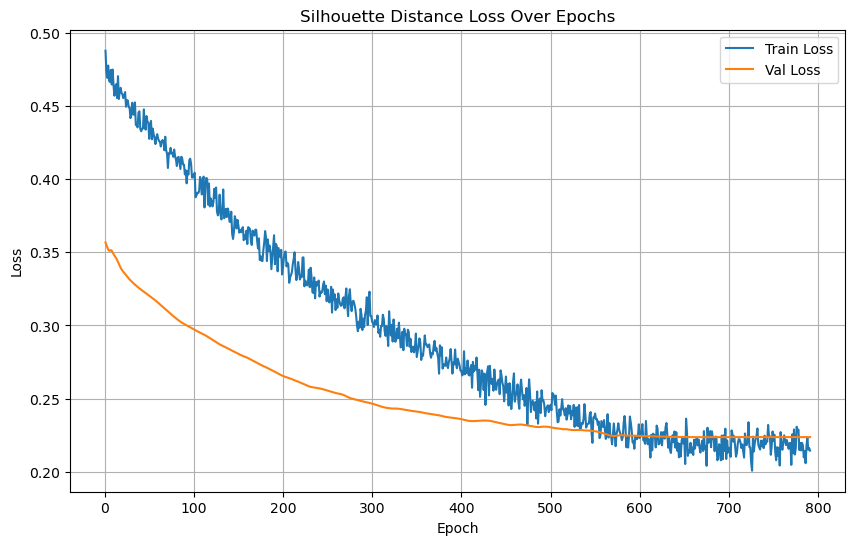

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/844], Loss: 0.0852
Test Batch [20/844], Loss: 0.1806
Test Batch [30/844], Loss: 0.1962
Test Batch [40/844], Loss: 0.1345
Test Batch [50/844], Loss: 0.1730
Test Batch [60/844], Loss: 0.5000
Test Batch [70/844], Loss: 0.1354


Test Batch [80/844], Loss: 0.2762
Test Batch [90/844], Loss: 0.5000
Test Batch [100/844], Loss: 0.2430
Test Batch [110/844], Loss: 0.1839
Test Batch [120/844], Loss: 0.2180
Test Batch [130/844], Loss: 0.5000
Test Batch [140/844], Loss: 0.5000
Test Batch [150/844], Loss: 0.1636


Test Batch [160/844], Loss: 0.2138
Test Batch [170/844], Loss: 0.1831
Test Batch [180/844], Loss: 0.2060
Test Batch [190/844], Loss: 0.1679
Test Batch [200/844], Loss: 0.1187


Test Batch [210/844], Loss: 0.1073
Test Batch [220/844], Loss: 0.0817
Test Batch [230/844], Loss: 0.1287
Test Batch [240/844], Loss: 0.1222


Test Batch [250/844], Loss: 0.1503
Test Batch [260/844], Loss: 0.3186
Test Batch [270/844], Loss: 0.2888
Test Batch [280/844], Loss: 0.3323


Test Batch [290/844], Loss: 0.3014
Test Batch [300/844], Loss: 0.3376
Test Batch [310/844], Loss: 0.2558
Test Batch [320/844], Loss: 0.1413
Test Batch [330/844], Loss: 0.3461


Test Batch [340/844], Loss: 0.3168
Test Batch [350/844], Loss: 0.5000
Test Batch [360/844], Loss: 0.2285
Test Batch [370/844], Loss: 0.5000
Test Batch [380/844], Loss: 0.5000
Test Batch [390/844], Loss: 0.5000
Test Batch [400/844], Loss: 0.5000
Test Batch [410/844], Loss: 0.5000
Test Batch [420/844], Loss: 0.5000
Test Batch [430/844], Loss: 0.0917
Test Batch [440/844], Loss: 0.1016


Test Batch [450/844], Loss: 0.1774
Test Batch [460/844], Loss: 0.1139
Test Batch [470/844], Loss: 0.1157
Test Batch [480/844], Loss: 0.1458
Test Batch [490/844], Loss: 0.5000
Test Batch [500/844], Loss: 0.1584
Test Batch [510/844], Loss: 0.1623
Test Batch [520/844], Loss: 0.1224


Test Batch [530/844], Loss: 0.0530
Test Batch [540/844], Loss: 0.1317
Test Batch [550/844], Loss: 0.1032
Test Batch [560/844], Loss: 0.1139
Test Batch [570/844], Loss: 0.1032


Test Batch [580/844], Loss: 0.1819
Test Batch [590/844], Loss: 0.1539
Test Batch [600/844], Loss: 0.0978
Test Batch [610/844], Loss: 0.1315
Test Batch [620/844], Loss: 0.1734
Test Batch [630/844], Loss: 0.3140


Test Batch [640/844], Loss: 0.1625
Test Batch [650/844], Loss: 0.1096
Test Batch [660/844], Loss: 0.0771
Test Batch [670/844], Loss: 0.1476
Test Batch [680/844], Loss: 0.1070


Test Batch [690/844], Loss: 0.0745
Test Batch [700/844], Loss: 0.3365
Test Batch [710/844], Loss: 0.1141
Test Batch [720/844], Loss: 0.4145
Test Batch [730/844], Loss: 0.0833


Test Batch [740/844], Loss: 0.1331
Test Batch [750/844], Loss: 0.1784
Test Batch [760/844], Loss: 0.1492
Test Batch [770/844], Loss: 0.5000
Test Batch [780/844], Loss: 0.1660
Test Batch [790/844], Loss: 0.2008


Test Batch [800/844], Loss: 0.3672
Test Batch [810/844], Loss: 0.1218
Test Batch [820/844], Loss: 0.1171
Test Batch [830/844], Loss: 0.1318
Test Batch [840/844], Loss: 0.1616

Test Loss: 0.2343


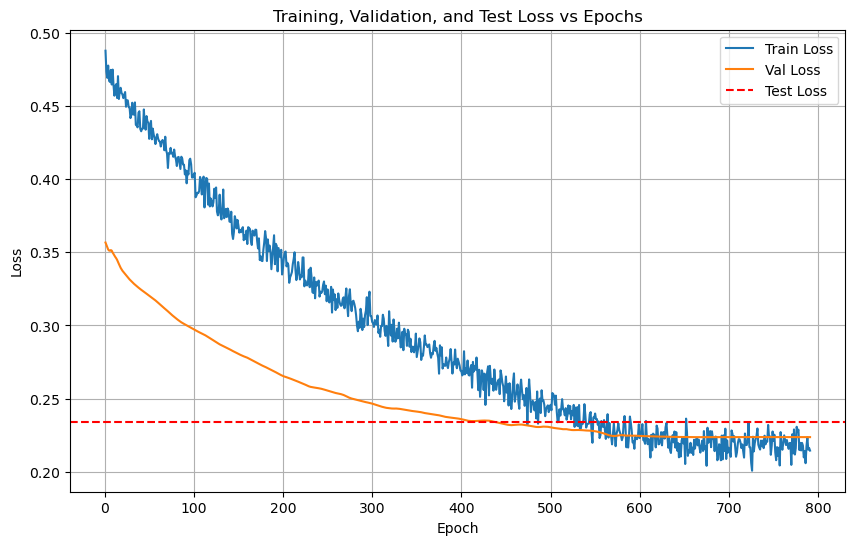

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/844 for test dataset.
  Processed batch 20/844 for test dataset.


  Processed batch 30/844 for test dataset.
  Processed batch 40/844 for test dataset.
  Processed batch 50/844 for test dataset.


  Processed batch 60/844 for test dataset.
  Processed batch 70/844 for test dataset.
  Processed batch 80/844 for test dataset.
  Processed batch 90/844 for test dataset.


  Processed batch 100/844 for test dataset.
  Processed batch 110/844 for test dataset.
  Processed batch 120/844 for test dataset.
  Processed batch 130/844 for test dataset.


  Processed batch 140/844 for test dataset.
  Processed batch 150/844 for test dataset.
  Processed batch 160/844 for test dataset.


  Processed batch 170/844 for test dataset.
  Processed batch 180/844 for test dataset.
  Processed batch 190/844 for test dataset.
  Processed batch 200/844 for test dataset.


  Processed batch 210/844 for test dataset.
  Processed batch 220/844 for test dataset.
  Processed batch 230/844 for test dataset.


  Processed batch 240/844 for test dataset.
  Processed batch 250/844 for test dataset.
  Processed batch 260/844 for test dataset.
  Processed batch 270/844 for test dataset.


  Processed batch 280/844 for test dataset.
  Processed batch 290/844 for test dataset.
  Processed batch 300/844 for test dataset.


  Processed batch 310/844 for test dataset.
  Processed batch 320/844 for test dataset.
  Processed batch 330/844 for test dataset.


  Processed batch 340/844 for test dataset.
  Processed batch 350/844 for test dataset.
  Processed batch 360/844 for test dataset.
  Processed batch 370/844 for test dataset.


  Processed batch 380/844 for test dataset.
  Processed batch 390/844 for test dataset.
  Processed batch 400/844 for test dataset.


  Processed batch 410/844 for test dataset.
  Processed batch 420/844 for test dataset.
  Processed batch 430/844 for test dataset.
  Processed batch 440/844 for test dataset.


  Processed batch 450/844 for test dataset.
  Processed batch 460/844 for test dataset.


  Processed batch 470/844 for test dataset.
  Processed batch 480/844 for test dataset.
  Processed batch 490/844 for test dataset.


  Processed batch 500/844 for test dataset.
  Processed batch 510/844 for test dataset.
  Processed batch 520/844 for test dataset.


  Processed batch 530/844 for test dataset.
  Processed batch 540/844 for test dataset.
  Processed batch 550/844 for test dataset.
  Processed batch 560/844 for test dataset.


  Processed batch 570/844 for test dataset.
  Processed batch 580/844 for test dataset.


  Processed batch 590/844 for test dataset.
  Processed batch 600/844 for test dataset.
  Processed batch 610/844 for test dataset.


  Processed batch 620/844 for test dataset.
  Processed batch 630/844 for test dataset.
  Processed batch 640/844 for test dataset.


  Processed batch 650/844 for test dataset.
  Processed batch 660/844 for test dataset.
  Processed batch 670/844 for test dataset.
  Processed batch 680/844 for test dataset.


  Processed batch 690/844 for test dataset.
  Processed batch 700/844 for test dataset.
  Processed batch 710/844 for test dataset.
  Processed batch 720/844 for test dataset.


  Processed batch 730/844 for test dataset.
  Processed batch 740/844 for test dataset.
  Processed batch 750/844 for test dataset.


  Processed batch 760/844 for test dataset.
  Processed batch 770/844 for test dataset.
  Processed batch 780/844 for test dataset.


  Processed batch 790/844 for test dataset.
  Processed batch 800/844 for test dataset.
  Processed batch 810/844 for test dataset.
  Processed batch 820/844 for test dataset.


  Processed batch 830/844 for test dataset.
  Processed batch 840/844 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.67      0.80      0.73         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.62      1.00      0.77         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       0.67      0.80      0.73         5
          12       1.00      1.00      1.00         5
          13       0.8

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7873  |  Val Loss: 2.7946
Validation loss improved from inf to 2.7946.
[Epoch 2/1000] Train Loss: 2.7659  |  Val Loss: 2.7794
Validation loss improved from 2.7946 to 2.7794.
[Epoch 3/1000] Train Loss: 2.7487  |  Val Loss: 2.7649
Validation loss improved from 2.7794 to 2.7649.
[Epoch 4/1000] Train Loss: 2.7318  |  Val Loss: 2.7510
Validation loss improved from 2.7649 to 2.7510.
[Epoch 5/1000] Train Loss: 2.7138  |  Val Loss: 2.7372
Validation loss improved from 2.7510 to 2.7372.
[Epoch 6/1000] Train Loss: 2.6975  |  Val Loss: 2.7238
Validation loss improved from 2.7372 to 2.7238.
[Epoch 7/1000] Train Loss: 2.6811  |  Val Loss: 2.7111
Validation loss improved from 2.7238 to 2.7111.
[Epoch 8/1000] Train Loss: 2.6643  |  Val Loss: 2.6988
Validation loss improved from 2.7111 to 2.6988.
[Epoch 9/1000] Train Loss: 2.6499  |  Val Loss: 2.6865
Validation loss improved from 2.6988 to 2.6865.
[Epoch 10/1000] Train Loss: 2.6355  |  Val Loss: 2.6745
Validation loss impr

[Epoch 38/1000] Train Loss: 2.2650  |  Val Loss: 2.3871
Validation loss improved from 2.3961 to 2.3871.
[Epoch 39/1000] Train Loss: 2.2533  |  Val Loss: 2.3781
Validation loss improved from 2.3871 to 2.3781.
[Epoch 40/1000] Train Loss: 2.2422  |  Val Loss: 2.3691
Validation loss improved from 2.3781 to 2.3691.
[Epoch 41/1000] Train Loss: 2.2305  |  Val Loss: 2.3600
Validation loss improved from 2.3691 to 2.3600.
[Epoch 42/1000] Train Loss: 2.2192  |  Val Loss: 2.3510
Validation loss improved from 2.3600 to 2.3510.
[Epoch 43/1000] Train Loss: 2.2078  |  Val Loss: 2.3421
Validation loss improved from 2.3510 to 2.3421.
[Epoch 44/1000] Train Loss: 2.1966  |  Val Loss: 2.3331
Validation loss improved from 2.3421 to 2.3331.
[Epoch 45/1000] Train Loss: 2.1856  |  Val Loss: 2.3243
Validation loss improved from 2.3331 to 2.3243.
[Epoch 46/1000] Train Loss: 2.1740  |  Val Loss: 2.3157
Validation loss improved from 2.3243 to 2.3157.
[Epoch 47/1000] Train Loss: 2.1631  |  Val Loss: 2.3070
Validati

[Epoch 81/1000] Train Loss: 1.8212  |  Val Loss: 2.0237
Validation loss improved from 2.0324 to 2.0237.
[Epoch 82/1000] Train Loss: 1.8108  |  Val Loss: 2.0149
Validation loss improved from 2.0237 to 2.0149.
[Epoch 83/1000] Train Loss: 1.7997  |  Val Loss: 2.0062
Validation loss improved from 2.0149 to 2.0062.
[Epoch 84/1000] Train Loss: 1.7890  |  Val Loss: 1.9973
Validation loss improved from 2.0062 to 1.9973.
[Epoch 85/1000] Train Loss: 1.7784  |  Val Loss: 1.9884
Validation loss improved from 1.9973 to 1.9884.
[Epoch 86/1000] Train Loss: 1.7674  |  Val Loss: 1.9794
Validation loss improved from 1.9884 to 1.9794.
[Epoch 87/1000] Train Loss: 1.7569  |  Val Loss: 1.9704
Validation loss improved from 1.9794 to 1.9704.
[Epoch 88/1000] Train Loss: 1.7460  |  Val Loss: 1.9615
Validation loss improved from 1.9704 to 1.9615.
[Epoch 89/1000] Train Loss: 1.7351  |  Val Loss: 1.9527
Validation loss improved from 1.9615 to 1.9527.
[Epoch 90/1000] Train Loss: 1.7247  |  Val Loss: 1.9440
Validati

[Epoch 120/1000] Train Loss: 1.4310  |  Val Loss: 1.6968
Validation loss improved from 1.7046 to 1.6968.
[Epoch 121/1000] Train Loss: 1.4226  |  Val Loss: 1.6891
Validation loss improved from 1.6968 to 1.6891.
[Epoch 122/1000] Train Loss: 1.4133  |  Val Loss: 1.6814
Validation loss improved from 1.6891 to 1.6814.
[Epoch 123/1000] Train Loss: 1.4043  |  Val Loss: 1.6737
Validation loss improved from 1.6814 to 1.6737.
[Epoch 124/1000] Train Loss: 1.3955  |  Val Loss: 1.6658
Validation loss improved from 1.6737 to 1.6658.
[Epoch 125/1000] Train Loss: 1.3860  |  Val Loss: 1.6578
Validation loss improved from 1.6658 to 1.6578.
[Epoch 126/1000] Train Loss: 1.3775  |  Val Loss: 1.6497
Validation loss improved from 1.6578 to 1.6497.
[Epoch 127/1000] Train Loss: 1.3687  |  Val Loss: 1.6418
Validation loss improved from 1.6497 to 1.6418.
[Epoch 128/1000] Train Loss: 1.3600  |  Val Loss: 1.6341
Validation loss improved from 1.6418 to 1.6341.
[Epoch 129/1000] Train Loss: 1.3514  |  Val Loss: 1.626

[Epoch 156/1000] Train Loss: 1.1442  |  Val Loss: 1.4327
Validation loss improved from 1.4390 to 1.4327.
[Epoch 157/1000] Train Loss: 1.1376  |  Val Loss: 1.4266
Validation loss improved from 1.4327 to 1.4266.
[Epoch 158/1000] Train Loss: 1.1310  |  Val Loss: 1.4206
Validation loss improved from 1.4266 to 1.4206.
[Epoch 159/1000] Train Loss: 1.1245  |  Val Loss: 1.4145
Validation loss improved from 1.4206 to 1.4145.
[Epoch 160/1000] Train Loss: 1.1181  |  Val Loss: 1.4084
Validation loss improved from 1.4145 to 1.4084.
[Epoch 161/1000] Train Loss: 1.1115  |  Val Loss: 1.4023
Validation loss improved from 1.4084 to 1.4023.
[Epoch 162/1000] Train Loss: 1.1051  |  Val Loss: 1.3960
Validation loss improved from 1.4023 to 1.3960.
[Epoch 163/1000] Train Loss: 1.0986  |  Val Loss: 1.3899
Validation loss improved from 1.3960 to 1.3899.
[Epoch 164/1000] Train Loss: 1.0920  |  Val Loss: 1.3838
Validation loss improved from 1.3899 to 1.3838.
[Epoch 165/1000] Train Loss: 1.0857  |  Val Loss: 1.377

[Epoch 196/1000] Train Loss: 0.8993  |  Val Loss: 1.2104
Validation loss improved from 1.2151 to 1.2104.
[Epoch 197/1000] Train Loss: 0.8934  |  Val Loss: 1.2058
Validation loss improved from 1.2104 to 1.2058.
[Epoch 198/1000] Train Loss: 0.8879  |  Val Loss: 1.2010
Validation loss improved from 1.2058 to 1.2010.
[Epoch 199/1000] Train Loss: 0.8823  |  Val Loss: 1.1963
Validation loss improved from 1.2010 to 1.1963.
[Epoch 200/1000] Train Loss: 0.8765  |  Val Loss: 1.1915
Validation loss improved from 1.1963 to 1.1915.
[Epoch 201/1000] Train Loss: 0.8710  |  Val Loss: 1.1867
Validation loss improved from 1.1915 to 1.1867.
[Epoch 202/1000] Train Loss: 0.8656  |  Val Loss: 1.1818
Validation loss improved from 1.1867 to 1.1818.
[Epoch 203/1000] Train Loss: 0.8600  |  Val Loss: 1.1769
Validation loss improved from 1.1818 to 1.1769.
[Epoch 204/1000] Train Loss: 0.8544  |  Val Loss: 1.1723
Validation loss improved from 1.1769 to 1.1723.
[Epoch 205/1000] Train Loss: 0.8489  |  Val Loss: 1.167

[Epoch 237/1000] Train Loss: 0.6760  |  Val Loss: 1.0290
Validation loss improved from 1.0334 to 1.0290.
[Epoch 238/1000] Train Loss: 0.6709  |  Val Loss: 1.0246
Validation loss improved from 1.0290 to 1.0246.
[Epoch 239/1000] Train Loss: 0.6654  |  Val Loss: 1.0202
Validation loss improved from 1.0246 to 1.0202.
[Epoch 240/1000] Train Loss: 0.6601  |  Val Loss: 1.0159
Validation loss improved from 1.0202 to 1.0159.
[Epoch 241/1000] Train Loss: 0.6546  |  Val Loss: 1.0119
Validation loss improved from 1.0159 to 1.0119.
[Epoch 242/1000] Train Loss: 0.6492  |  Val Loss: 1.0081
Validation loss improved from 1.0119 to 1.0081.
[Epoch 243/1000] Train Loss: 0.6435  |  Val Loss: 1.0043
Validation loss improved from 1.0081 to 1.0043.
[Epoch 244/1000] Train Loss: 0.6384  |  Val Loss: 1.0004
Validation loss improved from 1.0043 to 1.0004.
[Epoch 245/1000] Train Loss: 0.6328  |  Val Loss: 0.9966
Validation loss improved from 1.0004 to 0.9966.
[Epoch 246/1000] Train Loss: 0.6276  |  Val Loss: 0.993

[Epoch 277/1000] Train Loss: 0.4782  |  Val Loss: 0.8867
Validation loss improved from 0.8892 to 0.8867.
[Epoch 278/1000] Train Loss: 0.4734  |  Val Loss: 0.8841
Validation loss improved from 0.8867 to 0.8841.
[Epoch 279/1000] Train Loss: 0.4689  |  Val Loss: 0.8812
Validation loss improved from 0.8841 to 0.8812.
[Epoch 280/1000] Train Loss: 0.4639  |  Val Loss: 0.8783
Validation loss improved from 0.8812 to 0.8783.
[Epoch 281/1000] Train Loss: 0.4594  |  Val Loss: 0.8757
Validation loss improved from 0.8783 to 0.8757.
[Epoch 282/1000] Train Loss: 0.4544  |  Val Loss: 0.8730
Validation loss improved from 0.8757 to 0.8730.
[Epoch 283/1000] Train Loss: 0.4497  |  Val Loss: 0.8703
Validation loss improved from 0.8730 to 0.8703.
[Epoch 284/1000] Train Loss: 0.4452  |  Val Loss: 0.8674
Validation loss improved from 0.8703 to 0.8674.
[Epoch 285/1000] Train Loss: 0.4403  |  Val Loss: 0.8639
Validation loss improved from 0.8674 to 0.8639.
[Epoch 286/1000] Train Loss: 0.4355  |  Val Loss: 0.860

[Epoch 315/1000] Train Loss: 0.3139  |  Val Loss: 0.7785
Validation loss improved from 0.7818 to 0.7785.
[Epoch 316/1000] Train Loss: 0.3098  |  Val Loss: 0.7752
Validation loss improved from 0.7785 to 0.7752.
[Epoch 317/1000] Train Loss: 0.3062  |  Val Loss: 0.7720
Validation loss improved from 0.7752 to 0.7720.
[Epoch 318/1000] Train Loss: 0.3024  |  Val Loss: 0.7690
Validation loss improved from 0.7720 to 0.7690.
[Epoch 319/1000] Train Loss: 0.2986  |  Val Loss: 0.7663
Validation loss improved from 0.7690 to 0.7663.
[Epoch 320/1000] Train Loss: 0.2951  |  Val Loss: 0.7634
Validation loss improved from 0.7663 to 0.7634.
[Epoch 321/1000] Train Loss: 0.2912  |  Val Loss: 0.7608
Validation loss improved from 0.7634 to 0.7608.
[Epoch 322/1000] Train Loss: 0.2877  |  Val Loss: 0.7586
Validation loss improved from 0.7608 to 0.7586.
[Epoch 323/1000] Train Loss: 0.2842  |  Val Loss: 0.7567
Validation loss improved from 0.7586 to 0.7567.
[Epoch 324/1000] Train Loss: 0.2805  |  Val Loss: 0.755

[Epoch 357/1000] Train Loss: 0.1879  |  Val Loss: 0.7044
Validation loss improved from 0.7053 to 0.7044.
[Epoch 358/1000] Train Loss: 0.1855  |  Val Loss: 0.7027
Validation loss improved from 0.7044 to 0.7027.
[Epoch 359/1000] Train Loss: 0.1832  |  Val Loss: 0.7007
Validation loss improved from 0.7027 to 0.7007.
[Epoch 360/1000] Train Loss: 0.1809  |  Val Loss: 0.6990
Validation loss improved from 0.7007 to 0.6990.
[Epoch 361/1000] Train Loss: 0.1788  |  Val Loss: 0.6973
Validation loss improved from 0.6990 to 0.6973.
[Epoch 362/1000] Train Loss: 0.1767  |  Val Loss: 0.6960
Validation loss improved from 0.6973 to 0.6960.
[Epoch 363/1000] Train Loss: 0.1746  |  Val Loss: 0.6947
Validation loss improved from 0.6960 to 0.6947.
[Epoch 364/1000] Train Loss: 0.1725  |  Val Loss: 0.6932
Validation loss improved from 0.6947 to 0.6932.
[Epoch 365/1000] Train Loss: 0.1705  |  Val Loss: 0.6912
Validation loss improved from 0.6932 to 0.6912.
[Epoch 366/1000] Train Loss: 0.1688  |  Val Loss: 0.689

[Epoch 397/1000] Train Loss: 0.1198  |  Val Loss: 0.6756
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 398/1000] Train Loss: 0.1185  |  Val Loss: 0.6751
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 399/1000] Train Loss: 0.1174  |  Val Loss: 0.6742
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 400/1000] Train Loss: 0.1161  |  Val Loss: 0.6733
Validation loss improved from 0.6738 to 0.6733.
[Epoch 401/1000] Train Loss: 0.1149  |  Val Loss: 0.6722
Validation loss improved from 0.6733 to 0.6722.
[Epoch 402/1000] Train Loss: 0.1138  |  Val Loss: 0.6715
Validation loss improved from 0.6722 to 0.6715.
[Epoch 403/1000] Train Loss: 0.1127  |  Val Loss: 0.6712
Validation loss improved from 0.6715 to 0.6712.
[Epoch 404/1000] Train Loss: 0.1116  |  Val Loss: 0.6709
Validation loss improved from 0.6712 to 0.6709.
[Epoch 405/1000] Train Loss: 0.1105  |  Val Loss: 0.6706
Validation loss improved from 0.6709 to 0.6706.
[Epoch 406/1000] Train Loss: 0.109

[Epoch 437/1000] Train Loss: 0.0838  |  Val Loss: 0.6666
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 438/1000] Train Loss: 0.0832  |  Val Loss: 0.6665
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 439/1000] Train Loss: 0.0825  |  Val Loss: 0.6656
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 440/1000] Train Loss: 0.0818  |  Val Loss: 0.6648
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 441/1000] Train Loss: 0.0812  |  Val Loss: 0.6644
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 442/1000] Train Loss: 0.0805  |  Val Loss: 0.6642
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 443/1000] Train Loss: 0.0799  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 444/1000] Train Loss: 0.0792  |  Val Loss: 0.6623
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 445/1000] Train Loss: 0.0787  |  Val Loss: 0.6612
!! Validation loss did NOT improve !! Patience:

[Epoch 478/1000] Train Loss: 0.0620  |  Val Loss: 0.6662
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 479/1000] Train Loss: 0.0616  |  Val Loss: 0.6660
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 480/1000] Train Loss: 0.0612  |  Val Loss: 0.6653
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 481/1000] Train Loss: 0.0609  |  Val Loss: 0.6643
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 482/1000] Train Loss: 0.0606  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 483/1000] Train Loss: 0.0603  |  Val Loss: 0.6637
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 484/1000] Train Loss: 0.0599  |  Val Loss: 0.6644
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 485/1000] Train Loss: 0.0595  |  Val Loss: 0.6656
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 486/1000] Train Loss: 0.0591  |  Val Loss: 0.6671
!! Validation loss did NOT improve !! Patience:

[Epoch 516/1000] Train Loss: 0.0498  |  Val Loss: 0.6731
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 517/1000] Train Loss: 0.0495  |  Val Loss: 0.6738
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 518/1000] Train Loss: 0.0492  |  Val Loss: 0.6754
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 519/1000] Train Loss: 0.0489  |  Val Loss: 0.6769
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 520/1000] Train Loss: 0.0486  |  Val Loss: 0.6782
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 521/1000] Train Loss: 0.0484  |  Val Loss: 0.6792
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 522/1000] Train Loss: 0.0481  |  Val Loss: 0.6804
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 523/1000] Train Loss: 0.0479  |  Val Loss: 0.6820
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 523 !!
No improvement for 100 epochs.


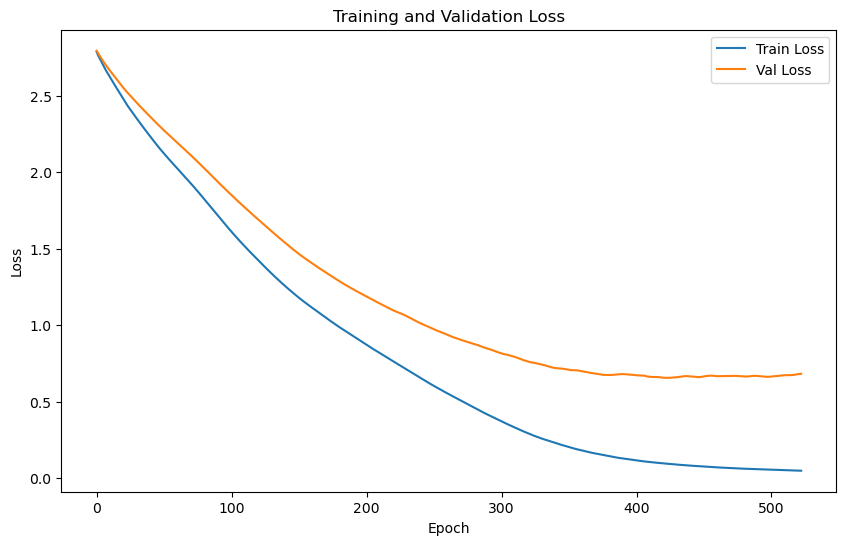

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9412 | Test Accuracy: 78.35%


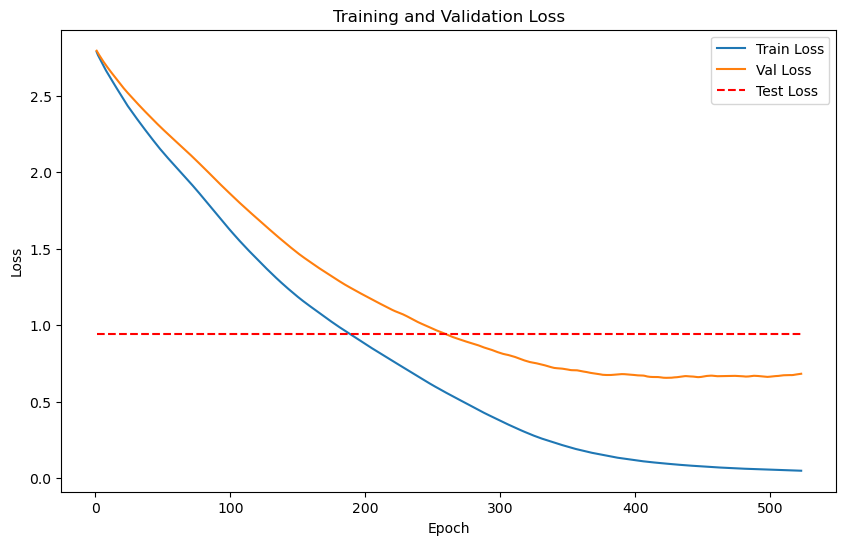

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


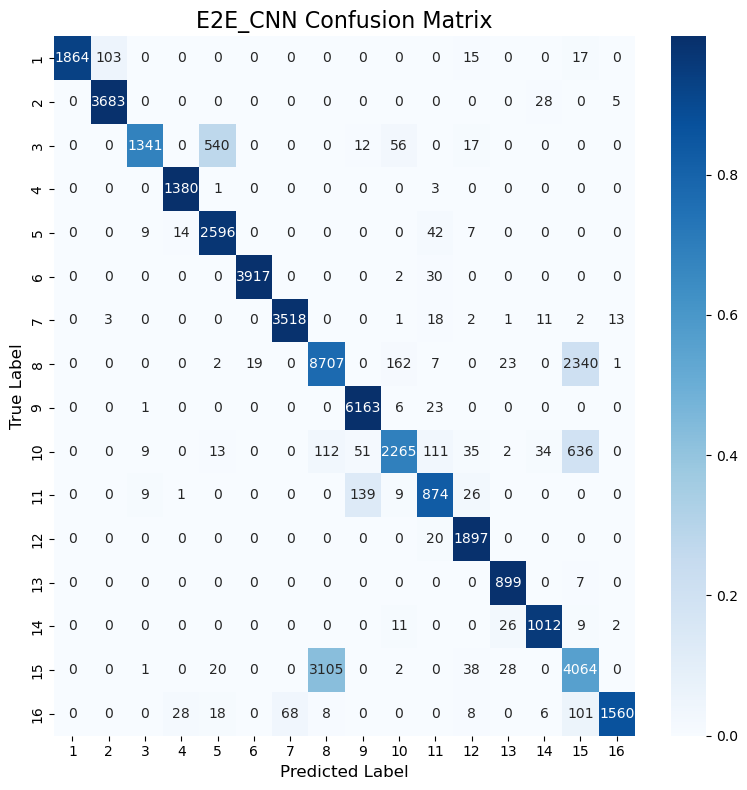

Classification Accuracy: 84.75%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


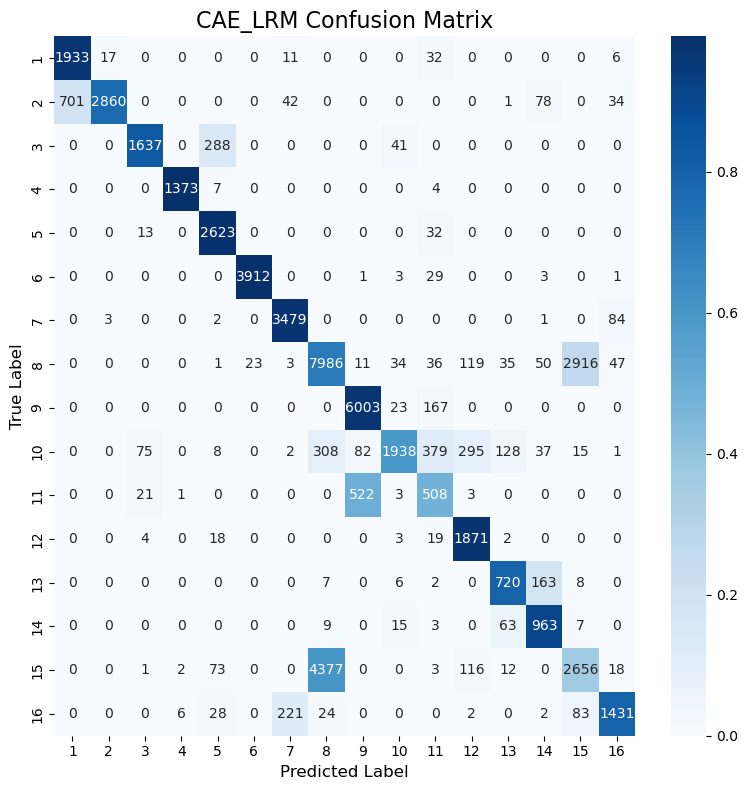

Classification Accuracy: 77.62%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


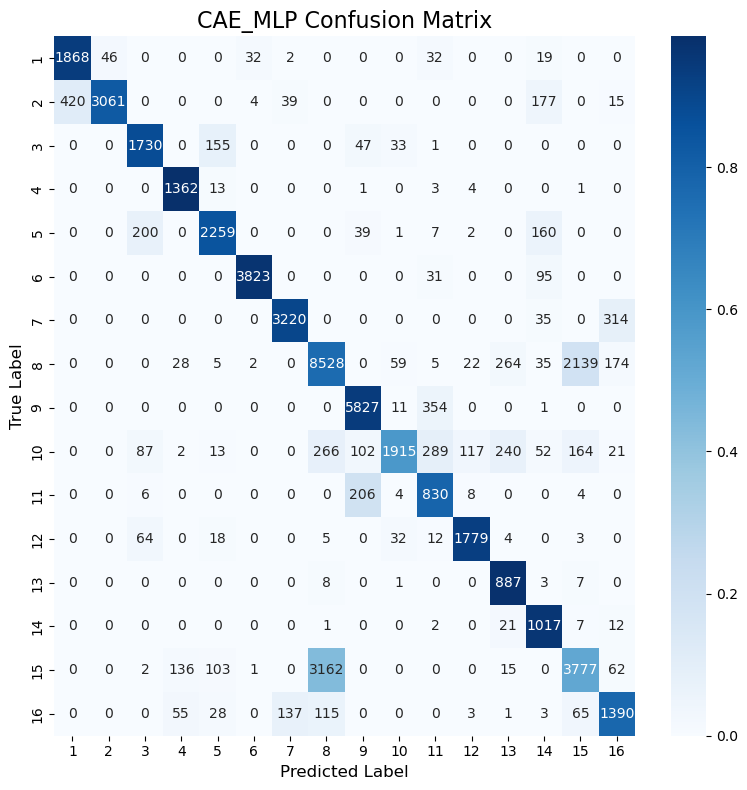

Classification Accuracy: 80.18%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


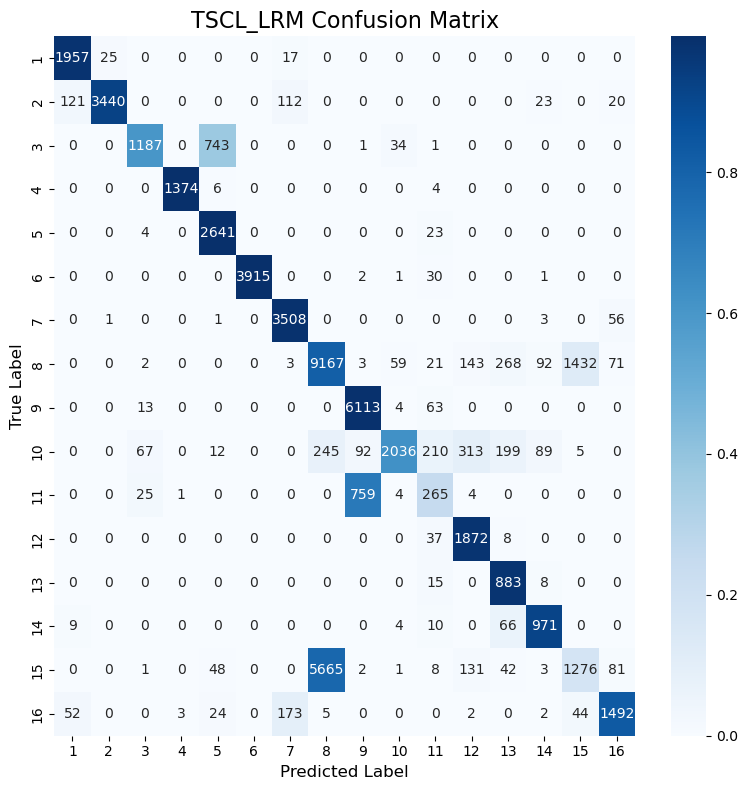

Classification Accuracy: 78.00%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


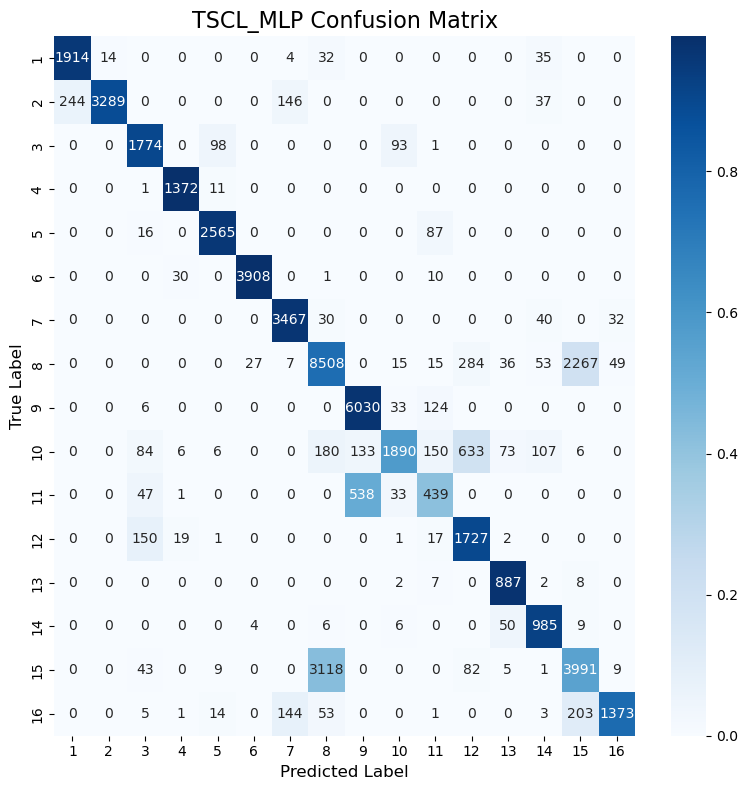

Classification Accuracy: 81.75%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


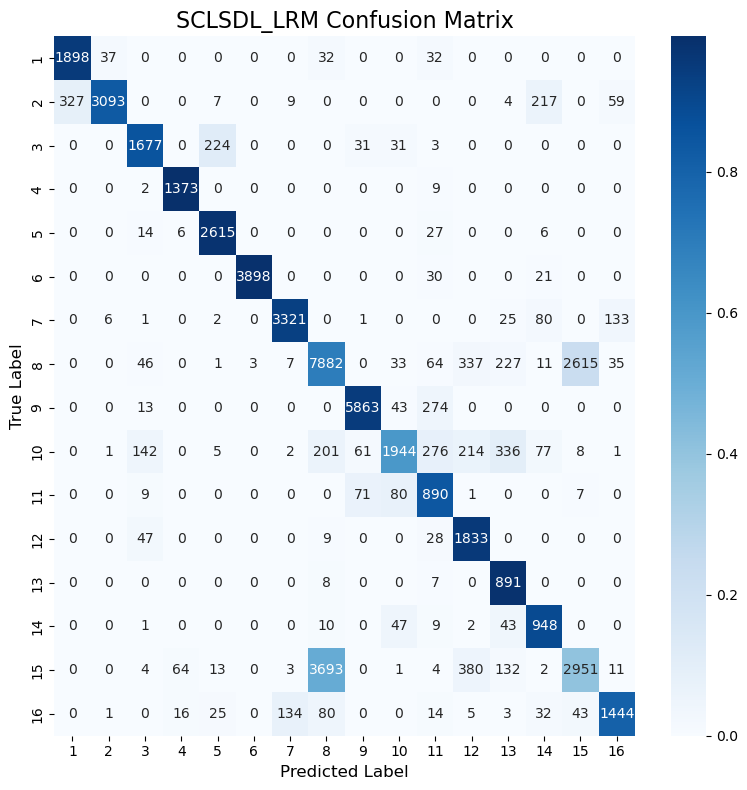

Classification Accuracy: 78.79%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


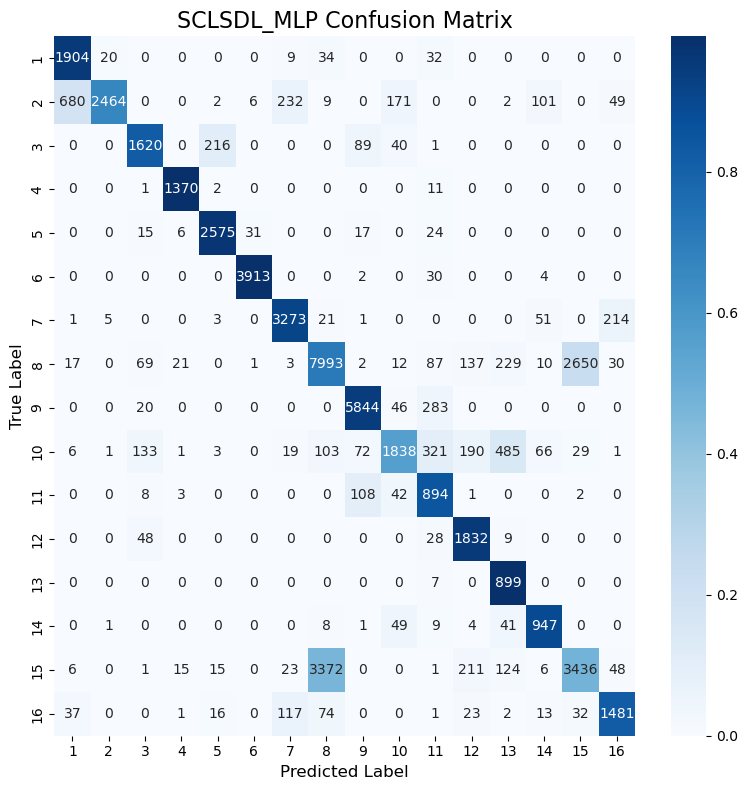

Classification Accuracy: 78.35%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          84.75
1    LRM (CAE)          77.62
2    MLP (CAE)          80.18
3     TSCL LRM          78.00
4     TSCL MLP          81.75
5  SCL_SDL LRM          78.79
6  SCL_SDL MLP          78.35

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          84.75
4     TSCL MLP          81.75
2    MLP (CAE)          80.18
5  SCL_SDL LRM          78.79
6  SCL_SDL MLP          78.35
3     TSCL LRM          78.00
1    LRM (CAE)          77.62
